In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.io import imread, imshow
import pickle
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import keras

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.utils import plot_model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

Using TensorFlow backend.


In [2]:
# Check whether GPU is being or not
from tensorflow.python.client import device_lib
from platform import python_version
print(device_lib.list_local_devices())
print(python_version())
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1222701989741841129
]
3.7.6
1.15.0


In [3]:
train_folder = 'C:/Users/DELL/One Shot Learning/images_background/images_background'
val_folder = 'C:/Users/DELL/One Shot Learning/images_evaluation/images_evaluation'
save_path='C:/Users/DELL/One Shot Learning'

In [4]:
def loadimgs(path,n = 0):
    
    
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

In [5]:
X,y,c=loadimgs(train_folder)

loading alphabet: Alphabet_of_the_Magi
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Arcadian
loading alphabet: Armenian
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Balinese
loading alphabet: Bengali


In [6]:
X.shape

(226, 20, 105, 105)

In [7]:
y.shape

(4520, 1)

In [8]:
c.keys() # for categories

dict_keys(['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali'])

In [9]:
print(c['Alphabet_of_the_Magi'])
print(c['Anglo-Saxon_Futhorc'])

[0, 19]
[20, 48]


In [10]:
with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X,c),f)

In [11]:
Xval,yval,cval=loadimgs(val_folder)

loading alphabet: Angelic
loading alphabet: Atemayar_Qelisayer
loading alphabet: Atlantean


In [12]:
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((Xval,cval),f)

In [13]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=1), kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=1),
                     bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=1), kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1),
                     bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=1), kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1),
                     bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=1), kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=1),bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=1)))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=1))(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [14]:
model = get_siamese_model((105, 105, 1))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [15]:
#plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
#from IPython.display import Image
#Image(retina=True, filename='model.png')

In [16]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(train_classes.keys()))

Training alphabets: 

['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali']


In [18]:
with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Validation alphabets:

['Angelic', 'Atemayar_Qelisayer', 'Atlantean']


In [19]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    print(categories)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets

In [20]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [21]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [22]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [23]:
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 20000 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [24]:
model_path = 'C:/Users/DELL/One Shot Learning'

In [25]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------
[ 62  22 217  75   3 131 136 188 195  67  80 210 162   2 156 181 109 199
 198 216 129 163  24  77  84 202  65  92  96 148 138  50]

[128 100  50   6 188 127 175 106  36 218  70  62 164 158 138   2 136 108
 190 216  61  35  75 202  28 193 161 187 129 119 133 225]
[ 51 164  98 173 205  12 169 160  52  62  13 159 216 101 166 201 140  30
  63  97  83 149 167  55 171  96 139 121 106 181 198 206]
[ 68  30 109 177 191  45 203 155 195  41  78  39 131  53 218  92 175  62
 142  35  71 185  27 121 205 147 124 223 192  84  47 212]
[200 102 100 157  36 138  23  79  75  34 196  24 224 128 129  35  73 177
  26 122 212 197 132  40 158 161 107 125 111  56 201  87]
[ 17 202 187 178 191  61 137  88  99 144 117 158 219  41 116  70 150 199
 143 103 168   3 193 142 118  95 130  76 119 162 186 192]
[217 115 144  99  21  16 208 222 192 214  33 184  50 165 113  25 130  62
 201 152 136  88 198  76 218   8 206 209  24  38   5  13]
[209 205 130 142 

[  7  84 109  68 191  41 142  42 185 143 105 200  56 184  89  31 187 128
  17  18 174  59  93   9 113 180 186  81 124  64 182 126]
[101 129  44 215 152 174  30 161   5 100  33  60  78 114 219  13 175 128
 191 107 220 204 195 164  95 221  23  32 160 216 119 178]
[  9 122  99 176 225 166  78  42 190 112 102 192 214 128   8  53  44 136
  11  96 110 179 132 125  84 169  83  33 155 133 113 107]
[ 54  76 168 185   0 107  89  46  35  21 183  60 123  53 142 135 128 133
 214  51 196 111   4  15  68 202  98  12 147 180  97 144]
[222 123   6 148 141 108 165  54   4 125 139 114 185  99 201  40 115  84
  53  80  31 216  90 128 174 134 107 153  43 161 127  34]
[ 40  32  17 150 225  52  37  36 114  16 192 154 121  60  71 136  39  35
  49 124 169  96 195 122  14 157  33 153  43  22 145 216]
[ 94  82  95 178 132 161  97 174 135 192  39 223  61 209 158 211  22 202
 172 164 225 208   2  40  44  30  51  17 128 150  59  19]
[ 74 180 201 179 165 113   5  41 176 178 194  60 110  48  17 186  13  68
 197 202  

[210 115 112  38  11 131 140 167 163 184 160 109  63  40   9 154  12 136
 143 211  55 198 174 133 161   2 134  43 204  54 135  60]
[175  61 158  27 169 135   5 179 117  33 133 161 178 191 162 106 194  86
 134 125  84 211  67 160 126 115 108  10 219   3 197  45]
[  4 156 144 168  54 150  15 112 201 177 185 174 103  39 160 179  27 209
  31  86 211 176 191 175 181  53 213  74 141  70  38  46]
[130  92 203 119 137 165  23 156 179 196 152 112 175 172  36  76  63  17
   9 166 138  52 225  88  73 134 202  91 103 144 135  43]
[175 180 102  66  21 187  25 209  57 161  87  64 114 203 109 127 204 128
 213  32 192 157  26  54 129 141 162 113 168 120 195 148]
[223 123 147 159 116 154  39 181 144  13  70 157  58 126 151   1   7  41
  68  89 152 198 221  18 192 165 183 128  21 180 212  93]
[ 32  50 130  23  62  55  21  42  75  64  81  34  60  22  53  20  58 190
 202 101 137 157  68 124 156  48 117  26 182   5  69 143]
[ 84 162 101 213 175  91 117 122 188 156  25 133 176 126   3 123  73 174
 100 155  

[183 172  30 122 166 156 173 216 163 128 188  18 223 222 114 213 157 120
  83  20 220   2  43 143 176  67 161  24  49 137 110 214]
[141  17 171 126  90  60 182  73  77 102 137  47 190 206 189   1  95  27
  41 136  39 113 192  78 169 201  55 139 221  94 223 210]
[ 42 213  40  86 138 105  54 123  26  32 210  74   9 204  25  98 189  87
 198 142  53  21 220 161 202  93 196 190 187 201  30 122]
[ 78 129 179  96  48 134  27  76 131  13  54 203  45 133 199  77  43 120
   5 125  34  21 207 108 163 171 149  90 192  46 184  10]
[173 183  26  19  17  33  14 201  49 190 163  37  59 189 128  99 170 153
 120  34  85 186 175  79 222 108 134 130 207 152 184  20]
[106 146 214  82 166  33  78 186 114  18  84   9  24  79 202  21  26 104
 217  66  75 120 201  53 141 154   4 187 103 182  40   5]
[221  75 181 157 123  70  93  88 175  47   9  27   2 156 116  50  20 140
 189 200 110  16  78  33 182  85 212 131  60 112   1 120]
[ 60 195  68 149  21  62 123 126 138 139   4 174  17 207  39 130  30  93
  80 117 1

[131   4 222 115 165 209 139 128 116  58 118  79  21  59 178 181  34 173
 134 164 144 161 225 106 218 171  44 156  10  69  74  96]
[173 118 214 216  77   6 213 167   3 122 115 212   1  71 116 222 196 136
 174  55 189 147 157  97 161 121  99  10  21 181 218  69]
[106  49 218  43 111 175 207 122  57  87 115 107 129 225  33  63  74 143
  29  51  22 112 117 189  25  85 162  94  41  16  54 166]
[  9 148 167  74 104  77  78 198 219 112 124  10  68  91  37  96  44 181
 186 130 211 185  80 152  63 137 178   8  55 197 109 139]
[201 169   3  24 118 185 198 175  44  48 151  71  89 208 145 176  64  65
 224 103  18  58  57  39 100 159 186 195   2 140  79  92]
[ 19  50 139 194  91 142 138 116 159  67  39  51 111 113 170  41 218 167
 120 220 122 184 136  28  26 149 182 204  73  40 203 107]
[ 46   3 173 156 161 210 159 191 152   5 140 115  25 145 100 172 118 169
 211 155 190   2  81 201 158 131  54 109 111 139  14 181]
[221 224  42 119  68 160 175  74 146 203 120 170 194 129   9  93 220 199
 132 111 1

[177   7  90 103  77  93 151 109  73 201  12  48 140  61   4 162 123 165
  17 118  66 132  36 129 197 220  46 130 192 160  43 156]
[ 26   3   4 190  18  37  43  40  81  93 216  50  17  70  83 157  25 110
 186 120  28 177 144  32  89  94  29 217  24 141 205 218]
[102  74 107 220  31 163   6 157 119  86 192 207   1  42 193 194   4  69
  94 103 216 134 155 126  29 151  22  34 152  45  84 146]
[ 58 203 158  22 120  14 196 184 122  56 113  40  77  86  97  15 211 200
  27 109 193 126 180 111 221 108 181  96  10 137 215  46]
[ 54 178 104 190 212  25 215  29 183 221  44  32 223 138 129   8  36 219
  76  90 181 209 161 111  95  49 132 211  86 118 151  43]
[ 35 206 115 158 148  95 109 160 168  80  46 132 146 219  84  40 210 185
  26 220 209 177 207  24 104 134  86 154  55   1 152 174]
[ 36 172 182  47 153 171  58 156  20 191 209 111  65 102 127 222  54 170
  70 139  50 135 189  23 165  82 192   7 212 120 113  67]
[215 128  37  54  88  68 100 216  79 217 206 123  30  57 154 105  83 186
 171 111 1

[130 183 182 137  66 102  58 146 209 199 151 193 118 168 169 172 135 195
 207 131  28 211 173 113  32 141  80 149 104 198  98 129]
[ 97  27 198 148 126 182  75  72  35 215  36 196   9  17  39  33  73  79
  60  22  37 140  45  55 150  31 172  76 119 142  62  84]
[ 68 173   9 104 171 130 155  25  62 164 215 152 210  59 187 117  23 203
  88 131 120 149  50  99 182  12  22 116 218  74 111 209]
[ 86 222 201  58 110 175  48 111 170 148  62 168 211  77 126 127 114  35
 178 171 160  11 183  98 191 185  73  81  40  90 154 105]
[148   7 105 193  69  48  65  63 171  20  31  57  78 147  76 104 141 206
  85 153  88  79 162   5  91 117 177 111 196  75 173 145]
[129  93 113   9 182  13 159  96  82 131  44  59 221 187 170 127 212 163
 147 136 222  17  56 184 164   4 217 102  41 140 189  58]
[117 115  67 217  64 199 153  86 148 220  19  18  71 221  43 166 222 129
   3 214   6 119  68 181  88 120 150  54  60  29  78 225]
[ 14  23   5 155 167  37 111  96 176 209  60 144 179  42 182 181 174  80
 159 156 1

[129  40 185  66 108 159 197 124  26 203 181 106 142 206 128 163  64 134
  56  19 104 188 171  58 103 122  91 192  97 131  57  77]
[200  13  10  37   7  19  72 192 196  74 137  57 211 134 146 188 107 135
 153  61 205  88  50 149 133  90   6 127 159  58  15 148]
[172  28 216  25  55 220 176 154 160 105 151  53 103  12 111  87  73 147
  54 202 127  13 183 225  44 134 184 186 206  83 198   5]
[134  42   1   0   4 188  17 194   7   6  19 157 110  55  10  25 198   9
  32  49 199 114 105  44 164  35  72  51 162 104  61 177]
[ 97 111 175 137  92 208 121  26  75 150   8  31  34 149  66  59  24 210
 174   7   5  16 136  54 127 105  76   4   6 122 159  94]
[185 163 224  23 123 176  68  48 132 180  13 150  86 207 205   6  98  19
  88 165 198  95   9 181 100 199 151 134 222  93  82  10]
[ 38 173  62  73  10  85 157 172 129 109  44  48 113 136 187 202 143 128
 161 150  46 138 114 210  84   9 110  34  64  63  29 155]
[ 73 192  29 156  48 119 182 179  62  97  82 167 151 224 108 125 110 118
  64 180  

[ 87 120 191 136 156 152  72 180 101 162 143 175  48 197 121 214  25   2
 176  24 182  49 190 177 109  54  46 117 131 142 204  61]
[ 72  43 178 100   0  56 108  13 221  18 194  33 150  99 167 132   7 151
 163  48  44   5 152 162 153  25 106  95  51 213  91 192]
[197 207 209 221  88  75 225 212 141 202 198 118 216 103  91 134  28   9
   7 213 139 188 215  53  29 108 187  26  78  65  38 200]
[223 194 206 199 210 108   2  93 141 200  43  98  16  23  66 160  70 134
 106  25  20 150 125 119  55  18 190  82  75 174 212 191]
[ 81 158  32 138 140 127  36  59 110 200  97   4 105 177  35 147  13 104
  76  14  67 111   9 191 154 109  43 113 216  89 176 170]
[151 224 147 182  66   1 206 103  57  77 221 157 123 184 149 134 170   0
 209 192  74  28  79  98 183  65   9 201 154   5  72  17]
[ 15  60   0 199 196   9 106 213  46  45  35 127  14 167 123  80 117 209
  57 144 147 143  44 100  27  76 165  40 157 126  56  33]
[120 122  40  15 103 102 117 115  68 203  96 158 197 221 140  59 217 101
  18  89 1

[152  73  31 221  15 207  94   7 155  22 133 132 110  67 100 106 124  47
  93 217 139 108  16 225 128 205 146 103 187 173 188  12]
[158  20 106  92  64 130 180  63 111  78 192 138  21  70 224 152  13  85
  94 172 163  18  15  22 170  84  25   5  90 129 156 145]
[ 32 112 148  98 210  18 156  76  80 105  79 118 149  62  54 206  17 175
   9 208 190 186 178 169  91   5  41 141 151  55  21 199]
[ 96 121 218 120  44  49 204  68 104 110 158 125 175 100 180  40  87   4
  17 199 138 144  61 213 108  72 133 176 102 173  78  73]
[194 218 150 210 163 165   2 143 100   3 214 110  91  41  80  38  44  86
  17 155 104 105 129 146  94 184 119  21 164 112 123 101]
[103  47 216  98 136  83 167 190 144  66 149 132 154 163 173  40  71  33
  65 113  93  35   5  20  16 164 106 168  68  84  28 158]
[151 100  52 126  86 132 204 197  87 109  61 159  98 209 178 191   3 163
  26 185 203  17 217  51  33 195  96 160 102   0  69  90]
[121  77  27 105   9  99  38  11 126 114 187  67 223  62 145  37 182 176
  73   4 1

[209 192 210  39 173 144  47  42 169  67  68 187 162 117  75 185  27  73
 222  79   6 131  56   4  74 167 109  49  95 171  14  96]
[ 90  27 219 218 126  74 195  12  93  91 180 123   9 114 140  79 207  54
  46 146 184  83 197 183 201 214  36 115  75  42 172 111]
[182  44 114 155  92 145  75 225  22 196  42  13  95  60  86   0 144  97
  26 169 200 205  73  27 143  31 166  37 107  66  99  24]
[ 49  82  93  70  37  85  51 125  13 104 151  98 154 178 173 162 153 119
 203 216 211  80 159 132   9  28  29 123  94  69  50  23]
[ 13   7 113  42 121 179 144 123 173 169 204  90 217  53  29 115 129 174
 214 127 188 193  56 152 108 136 180  15  11   8 146  21]
[  9  92 162 185  65  94 218 188  39  96  77  97 197 132 138 127 136  19
 116  48 125 168 208  43 143 157 133  74 107  56 146  93]
[ 57 155 122 113 140 167  55  53  74  69 171  46  79  37  14  42 134  13
  60 220  67  84 188  83  38  96 187 198 143 108  35  11]
[213 137 198  41 122  20 197  55 208  26   1 107  39  16  71  91  18 140
  68  33  

[106  14 146  63  50  36  61  92 102  26  17  53 140  96  31  65 174 172
  81 113  82 170 129 191   1 184  12  58  15 152 159  56]
[ 65  79 189 162 172  80  22   1   9 163 107 118 129 178  18 202  44 156
 135  30 110 133 222  92  83  99  36 122  27  43 144  54]
[ 47  56 195 139 144 205 148 129 102 174 185 184  57 133  81 211  20 154
  32 206 221 207  75  96 182  59 103 160   1 152  97   4]
[133  21 204 112 191 176 124   8  70 225   3 187  59  29  78  23 177  99
 131 212  58 186 121 118 207  64  18 221   6 172  16 185]
[ 94 110  87  74 134  67  16  92  19   3  53  54 125 111  98 159 208   8
  20 121  27 190 209 210  64  83 207 195 185 172 123  70]
[100  97 155 185  34  46 206  41  17  91 158  12  31 180 109 188  62 135
 166 133 186 102  76  21   6 197 132 201 168 120 152 209]
[177 195  48 225  82 218 146  65 140 192  80  18   0 151 162 143  53  31
 207 178 135  44  24 125 142  37 108 213  22  46 186 194]
[122   7  30   9 104 124  89   5 171 216 218  55  64 114  54 163  31  14
 190  68 2

[120  25  49  68 158 185 117  61  36   0  11  56  89 155 169 122 187 216
 156  58  59 208 157  90  99 221  91 167  74 163 172  44]
[ 64  81  17  70 142 210 173 137  87  33 144 207  11 128   4  89  10 220
  84 169  74  53  29 108   5   1  30  34 141 160 101 202]
[ 51  65  46  23 194  26  45 127 151 184  68  40 179 149 196 191 101 188
 158  49 155  85 212  83 181 225  73 128 219  62 147  95]
[176 210  36 183 106  89  40 127 217 143 123   7 146  35  39 170   1 120
 153 208 224 115 152 110 205 118 178  53  31 147  69  41]
[195 126  90 192 145 214 166   4 155 175  16 204 135 105  14 146  64  15
  71 223 188  11  56 127 174  24 112  97 153  65 206   1]
[ 38 225 146  33  70  19 131 172 140  77 112 211  15 222 165  54 198 133
  30 159  59  55 204  41 205 152  10  90 181 221 111  73]
[135 167  78  60  90 159  24  80 127  67  73 170 133 136 143  75  58 149
  99  81 212  27   3 120  20  39  31 160  89 131 114  29]
[112 124   3  12 104  29 216  36  40   2 209 138 146 201  74 151 122 203
  64 175 1

[109 155 169 204   8 116 123   2 218 157  26 152 136 206  48  66  57  16
  32 149  50  27 143 111 122  23 102  61  30   6 209 103]
[ 31 186 127 151  74 202 115 119 116 109 156 108 148  32 182  98  50 111
 154 201  37  39 101 167 200  34 220 216 189 183  95 187]
[194 203 146 210  87 160   4  17  44  48  86  88 144 111  56  99 113  71
 171 105   1 103  40 161 107  41  38 162 109  52  25  15]
[182 111 225  22 162 137 201 169 158 102 212  90  33  66  23  40  94 174
  72 180 196  31 219  15  51  73 115 103  77 105  62 141]
[178  58 112  72 181  23  14  61 120 110 195 122 139 128 194  35 225 192
  71   5  97  39 163  54   2 164 145  40 204  60  34 187]
[183  83 198  79  95  98  64 165 202 164 102  18 152  73  19  34  43  65
 211 223 177 194 172  27  92  28 209 114  10   5 186  33]
[192  44  63 141  85  16 134 207 121  62 217  60   1 225  86 156  14  46
 196  75 215 142 115 127  58  34  68 143  93  49  74 160]
[ 59 200  70  95  94  40 122  75 203  23  85  58  36  42  37  93 186 223
  31 102  

[166 118  14 128 127 116   1  36 196 152  67 209  94 180 211 205  26 208
 179  82 174 104  89 222 163  93  55 100 160 216 149 106]
[146  59  74 101  90  62 175 161  10 193  14 162 194  18 212 220  28  37
 203  66 118 217  91 144  47 130  94 197  21 211  29  56]
[  9 162 168  90 223 191 130  19  77  66  98 204 117 109 108 182 183 143
  76  51  85  82  89 136  49  78  97 222 196  11  21 118]
[171  50 191  88  30 104   7  62  71  68  63 213 153 122 199 129  66   1
 101  29  35 223 219  39  57 128 170  70  80 192 202 136]
[ 77 104 201  50 176  91  32 198  75  33 214 114  70 200  39 109 146  93
 140 185 127  16  23  54  59  96 178 208 184  55  38 105]
[148 214  83  14 127 205 132 129  84  95 172  29 221 203 178  41 199 103
 113  25   5  86  74  49 201  43 163 128 161  90 147 188]
[ 71  83  99 106  35 126  45 114 118 117 218  94 120 204 202  63 223  40
 174  11 155  61 160 121 119 100 221 195 189 205  55  28]
[ 31  48 107  69  96  33 115 120 134 133 195 176 203  92 113  16  72  30
  44 157 1

[161 191  61  86 141  69 162 137  32 181 172 152 145 148  37  81  71 204
 163 178 102 151 222 217 150 125 179  26 170 127  92 174]
[ 31 132 110  16 168 165  93  90  70 142  21   1 120 125 117 148 195  26
 191  45 154 177 133  12 135  43  73 144 121 225 175 114]
[ 83 210  68  47 128 175   9 164  65 133 171 147 146 123  54 215  80 184
  17 121  58  32 134 139  87  45   6 142 188 220  23  21]
[168 131 119  75 125 127 196  35 156  64  11  91  41 137  19 118 101 174
 103 218   6  88  36 153 193 219  40  39  85   7  50 111]
[ 42 115 187  88 110  51 216 111  27  55  41 119  48 124  43 129  56 205
  75 207 171  70 190  62   6 179 132 194  46 169  81 208]
[189  40  22 116 177  70  89   6 221  83 141  57 203 169 178  71  24  63
 185 194  90 191 201 143 224 136 107  87 161 153  38  52]
[119 129 153  15 185 174  40 152 186 130  82 103  72 205  35  71  23  83
 192 146  63 217   9  98 203 117  39  38  28 164 155  70]
[ 45 127  44  81 217  31 211  54  28 204 218 142   9  53  46   5 115 223
  98   6  

[ 47  39 172  81  51 177 153 166 214 102 117  32 212 223 179 215 193  69
 210  96 191  75 211 144 133 213 129  13  90 181 162  40]
[ 69 126  46 179 221  38  47 203 102  89 180 114  92 162 224 111 121   3
  19 194 119 151 182 159 148  26  30 223  42 145 202  59]

 ------------- 

Time for 1000 iterations: 659.8526273647944 mins
Train Loss: 1.4790210723876953
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 19.2% 20 way one-shot learning accuracy 

Current best: 19.2, previous best: 14.4
[217 123  51  13 220 219   5 161 115 129 152 186 140  54  26 211 110  65
  16  76 160  58 223 184 109  38  77  27 225  62 216  82]
[148 139  78  44  17  91 207 193  57  45  84  13  16 125  36  85 140  35
 133 170 159 105   2  51  66  94  19 114 138 130   4   3]
[103 185  46 180  17 129  36 111 218 159 127 137  59 112  47 170 133  87
  95 201  45 176 160  41  42  76  64  72  74 172  58  63]
[211  18 181  89 158  25 180  48 116  50 217  16  20 215 107  96 216 123
   7 1

[131 149 223  55   2  78 203  82 171 161 165 167  64  47 166 168 118 216
 197  15 207  76  95 100  19  96  92  69  29 205 212  99]
[110 149  49  30   1 205  12 162 224  34  86 126  47  48 154  82 155 133
 194 128  44  10  96 115 147 184  70 146 201 207 180  43]
[204   9  13 210 104  21  17  73 151  99  46  92  16  66  38 211  22  20
 156 141  72  49  62   1   8 172 163 166 100  51 136  90]
[197  59   6  55  39 192 175 106  18 140 148 118  30  42 117  95  88 142
 144 112  94 173 116 149  20  23  52 109  75 160  40 209]
[128  42 107 164  43  15  57  86 184  51 204 144 211  41 203  10 199 206
  58 178 126 131 187 114 127  84  49 153   9  94 151  72]
[180 122 129 206 163 171 172 112 169 114 188  69 124  31 165  14  34 120
  25 107 106  27 195  30  61 116  58  80  52  48 203 177]
[ 64   4  69  87  58  80 195  72  48 196  18  91 136 163  52 138 126 199
  16  30 206  50 154 150  86  57 173  23 193 160 152  11]
[173  42   5  15 150 178 151 114  36 216 140  88 214 123 143 161  46  95
  26 158 1

[224 175  67  13  88  47  84 167 112 207 199  17 107 219  81  69 127  41
  73   4  61 153 161  72 136 108  86 119 111 172 169 100]
[ 58  54 126  47  46  76  48   7 212  31  70 128 192 141  16  85  39  57
  20  65 202 191 200   3  71  55  45 116 195  12 167 124]
[102  92  39 138 188  24 205  44  32 124  77  98  71  11  74 178  22 163
  34  17 103  52 110 169 149  80  56 195 116  26 181  95]
[143  50  80 135  54 173 140 198 160 159 183 188  12 195 154 108 174  22
  71   5 134 201 111  94 107 187 199  29   3 204 172  17]
[167 125 118 211 205  99 215  65  54  23  26 134  18  40 162  33 161 120
  39   6 150 204  97 183 127 193  29  50  63 132 172  28]
[ 93 148  55 160  11 146 111  31  52  98 225 213  20  65 208 199  50  30
  42 175   3 193  57  34 149  75 220  28 152 172 179   5]
[ 90 200 148 211  83 220  96 181  79  30  94 201 111 214 191  48 161  46
  42  92 206 140 102 225  99  93  33  67 197  74  50 209]
[ 68 162   6   7 130  24 122 102 223  86 224  87 141  44  67  69  49  31
 124 176 2

[140 218 183 146 164 155 223  73   7 126  57  41  16  61  92  19  26 137
  28 120 189 220 103 108  94 222  20 212 193  45 143 203]
[ 68 193 175  69  66  65  14 207  42  76 158  32 135  77 220 186  74 102
  59  37   5 133  92 169  75 219 136  22  97 197   6  21]
[ 52  38  44  64 217  73  96  59  97  82 215 148  98 196  48 107  89 118
 182 147 126 106 128 190  28  95   4  10 167 115  26 191]
[193  35 137 141  98   7  62  88 124 172 188  33  81 202  76 201 116   1
  26 128  95 192  65  78 216 194 156 158 212 198 136  53]
[ 85  75 100 188  30  29  22  58  78  91 183 220 118 153 127 185  28 108
 209 193 202 149  18 170  79 139  63 131  61  23 196 182]
[ 73 110 179   8 116  66 174 139 186 222 177  13 168  12 119 173 142 133
  20  50   2 218  99 184  81 214 109 198 146 134  90 190]
[108 223   4  72  51 177  37 153 184  40 204  74 150 143  53 144 139 104
  89  21  47  61 218 196 109 215  68 174  55  77  71 202]
[ 28 185 121  20 131 178 212  11  24  13  26  65  14 197 129 140   9 141
 113 180  

[  9 221  65 102 168 167  58  20 191 193   2 112  24 109 192  81 118 101
  91 121 205  75 218 144 198  70 115 171 175 181  23 224]
[115 153 186  42  60 155   6 156 222 130 200  58  46  81  80  72 206  66
  43 217  35  63  68  82 135 133 116 177   0 219  18 111]
[160 220 139 123  77 186 195 197  58   3 187 137 205  35 135 100  60 208
  59  11 114 103 193  13  72 102 171 182   1  21  93 152]
[218 136 214 177  36 176 198 174 134   2  82  25  29 109 188 121 154 110
  52 195 221 132 196  18 104  84  19  65 111 203  83  99]
[150   7  73 203  24 122 135 175 198 201 138 194 222  44   9 111 160 182
 177  79 139  29   3  68  62 221 118  50 192 219  71  99]
[196 205  62 181   9 214  50 187 164  29  63  86  35  81 210  74  78  98
  45 127 138 202 140  99 184 192 183 222 102  24  76 141]
[161 121 211 188  87  97 203 114  89 174 176 201  42 124  78 180   6  56
 197  90 135 177 151  12  34 163  41   0  31 170 152 225]
[199 216   7 125 124 109 152   0 161  25 108   9  52 191 192 159 116 133
  15  62 2

[ 25 125  16 144  43 147 207  20  36  56 221 122 201  92 179 218 178  40
   8 146  86 121   2 109 110 108 193 198 168 163  51  79]
[157 127  42  75 200  84  35 104 117  64 142 132  17 175  57 136 146  79
  47 141 214  95 168  89  22 177  87  85 109 218 143  71]
[220 212 218 149  12  67 116 122 166  99  35  22  80  37 167 190 113 109
 178 186 157  44  79 143 128 205   9  40 156  87 126 139]
[116  28 131 172  77  93 197  98 103  87 208  49 160 225 179  63   6 194
 180 134  89  34  70  50  45 182  14  30 165 222 151  46]
[183 153  90 200  86 225   8  12  49 210 114  71  79 194 106 144 156 224
  91 137  17 177 168  74  46  14 112 203  45  31  81 197]
[ 75  45  81 129  50   2  48 207   7 186  55 210 184 113  28 185   9 118
  16 208 214  67 195 152  61 128  87 198 221 183  44 211]
[213 129 120  89  55  31   7 170  49  71  82 202 197 212 160  13 153  20
 145 102 171 203  38  65  77  18  85  86   4 154  59   5]
[ 52 135  70 162   7 101  44 204 125  83 106 165 148 156 104 129 222 111
 118 153  

[162  47 147  44 164  61 175 174  43  92 173 101 133 129  24  60 160 109
 179  18 221  72 216  84 184  65  77 189  91 103  71 150]
[171 168 117  90 198  47  79  56 195  80  35  58  61 217 110 214  10   8
 184 111  44 146  21 101 151 180 128  94  74  37 193 223]
[132 215  28 196  20 145 109 214   3  60 198  45  11 162 179  17  99 191
  55 146 220  25  76 170  10 202  27  23  29  21 135 157]
[200 103 170  34  14  39  45 116 186   4 178 223 126   9 225  47 168 146
  54 159 167 145 171 125   2 143 220  23 153  30  31  64]
[ 76  57   0 100 143  26  55  32 120  15 215 222  83  47  75 127  30 138
 209  45  56 118  21  28  22 192  58  31 188 123 166  97]
[ 59  82 120 151 149  12  96 221  16 185 216  23 155 182 203  63 143 181
 100  28 175 163 129   6 114  57 123 211 152  80 209  95]
[ 97 126  58  78  77  63  35   9  69  55  90 195  85 106 150   2 222  47
 192 111 202   0 151 125  43  80 213  36  53 131 201  89]
[ 23  33   2 113  94  38 128  72 184 213 132 208  21  35 140  36  15  26
 217 169 1

[110 213 157 179  55 108 152  12 206 172  64  88  93  34 158 109  98 199
  80 145 211 115  54   6  48 139  40 105  16 207 215 127]
[ 47 224 201 151 168 155 212 117  48 206 184  50 172 196 217   4 142 225
 144 104 149  46 114 163 122  65 170 135 108  38  79 124]
[152  84 148 181  16  29 164   1  17  93 122 139 220 178 159  38 143 180
  21  86  56   4  99  63 188 157  81  35 186 184 174 211]
[208 221 144 185  13 103  23  89 115   9  28 116 123 165  98 130  53 169
 175 183  57  22  37 159  94  18 193  83 194 225  67 107]
[207 114   5 123   6 136 201 174  56  66   4  82  68  11 116 176  86  38
  30 134  57 221 175  40 160 223 216 124 213 139 111 225]
[ 88  51 194 122 177  59   9 104 182 126  73 123 186 154  87 161 200   8
  93 211 212 185 213  23  62 134  21 136 205 189  40 132]
[ 80  20 222 139 211 166 225 195 179  99  32  38  22 134 172 110 144  54
 190  79  59   7 202  17  16  15  81 161  36  71 204  82]
[200  61 150  98   2 220  54  80 111 105 178  70  55 122 146  34 184  79
  64   4  

[ 31  61 129 122  17 143  38  85 118 194 160 148 142 201 121 224  66 199
  97 134 222  45   7 158  34  14  78 103   1 115 173 220]
[196 132  67 172  80 115 182 147 137   7 140  36  45 163 221 190 177 213
 116 111 124 194 119 107  58 113  95 146 193  78  70 152]
[ 78 201 179 118 181  50  68 193 150 221 135   4 191  82 160 109  11 182
  28  81 159 189 119 209 136 146 213 215   3  47 188   1]
[ 82  23 200  88  49 131 215  39 111  40  42  48 138 139 146 140  60  78
  61  86   8 187  85 137  38  89  75  73 117  24  80 109]
[115  37  48 137 198  87 156   6 220 162 193  11 139 214  83  89 103 129
 203 201  75 216 128 154 152 148  94 101 133  38  10 177]
[199  58 161  61  91  84  37 184 196 169  48  13   6 198 158 203   7   8
  90 193  54 202  18  82  32  78 141 147 136 124 182  87]
[ 98  57 110  65 115 223 210   2 143 167   3 124 138  45 205 140 197  74
 125  48 109  29   1 225 120 130 159 128 203  43  62 219]
[ 49 215  47  55 104 184 131 109 194  32 183 134  85  36 173 132  97 111
 192 193 1

[121 210  81 184 154 100 207 209 158 107 195  10  14  70 163  11  60 138
  79 156 129 143 196 167 211   9 134  63  53 177  72 223]
[ 57 112 201  85  30 181  77  23 145 125 109 161 213 105  39  58 114 209
  38  50  61 154 103 139 142 200 212  64   8 216  49  54]
[ 44 197 215 156  99 187 210 137  14 118 200 216  74 208 103 194 143  63
  88 155 148  83 157  93 225   1  28  29 150  68  73  42]
[157 167 121  13  87 131 199 111  68 198 160 148 194  40 146  48 206 118
  32 116 164  62 130 163   5 178 195 222  20  18  54 211]
[ 44   8  16 101 112 154   5 137 116 224   6  30  38  85  47  80 145  46
 180  27 202 219  26  55  35  40  86  45  97  99 133 179]
[  0 217  29  46  15  30 114 193 116 117 188  66 192 129 118 128  90 187
 221  42  44 206  22 125  10  55  41 175 126  24 161  54]
[122 150 159 186 130  88 182  27 153 209 188 104 108  18  76  42  97  53
  72 175 105  58  50  82 163 116 152 103 225  13 139 137]
[126 209  62 181 141  94 170 165  61 207 196 193  10  15  71  41 148 158
  16 178  

[210 192 133 199 191 157  31 172 170  45   3 197 184 195  84  97 212 114
 176 115  30 158  47  74 206 147  85 153  52  83 110 221]
[202 216 141 132 206 187 183 133  65 195 159  82 193 212 221  97 179  95
 106  41 208 220  69 180 181 100 223 150  45 211 186  62]
[ 93 108 148   3  61 197 115 153  44  86  22  60 183  15  10  21 158  38
  68  50   0 152 188  96  63 171 167 162  74 179 126 139]
[211   6  24  79 137 185 191 206 145 201 195  56  10 150 167 142 121   9
 224 151 225 109  96  74 182 159 193 108 172 143  52 125]
[114 126   1  11 104  86 122 120 201 211 138 101 112  38  48 205  34  33
 170  82 199 158 169  56 192 131  70  13  96  22   5  92]
[151 161 187  23  32  66 155 205  42 184  33 179  85 203  73 130   0  47
  48 182  59  63  31  17 140  54  84  77 112 146 181 125]
[102  61 180  76  91  80 148 204  78  22 192  27  25  54  37 211  17  43
 222  42 186 135  74  40 196  14 165  65 126 207 185  82]
[170  80   2  78 208   7 176  26  51  75  12  16  93  91   8 109 183 158
 128 131 1

[ 79  32 164  46 151  29  49 154   0 128  48  87 127  15 145 209  39 225
 152 219 116 207  71  47  59  13  20  37 120 216 118 201]
[ 97  74 176 203  94 174   9  67  37  49  21 219 193 144 195   2  98  31
 101  63  85  95 153 160  86  23 146 180  82  19 120  18]
[ 74  35 119 100  98  90  26 195 149 126 180 213 160 133 184 197  33 104
 210 187 101 154 177 113 172 151   4  78 146 166 116 162]
[ 77 103  95  90  61 200 139  72  82  54 135  88 100 136 156 121  53 202
 195 201  70 208 217  41  84 134  73 184  59  45  19 123]
[ 48 202  72 207  14 185  49  50 177 108 215 176 198  27 118 150 142 143
  47 117  60  11 188 191 218  32 224   3  30 105 140 197]
[  1  66  49  59 211 108  37 132 154  86 125 158  98 163  50  89 166 170
 106  21   0 216 192  30  87 104 160   8 137 168  10 153]
[129 132  83  44  98 131   3 208 204 212 159  77 118 196 154 119 124  52
  81  27   5 224 214  53 170 140  50 213  84 133  15 203]
[104  91 223   0 213 134 112  96 185 194  85 164  27 170  50 119  55 188
 144 146 1

[ 17  50  76 192 145 215  22 137  63  88 208   6  95  18 203 124 164 217
 180 163  80  47 170 150 219 167   5 162  96 116  78  49]
[191  94  73 151 218 123 127 140  90 137  49 159 180 174 121 143 210  30
  46 212 114  33  71  74 209 111 165 178 177 200 211  35]
[193 133 179  44 201 157 165 152  69 111 200 204 215  81 147  27 216  59
 183  66 141  85 120 203 101  26 189 211  83 208 222  86]
[120 203  47 130 188  15 207  71 137  89 224  18 170  59 163  68 144 119
 111  42 174  87 112  74 155 126  39 138 216  38  81 166]
[ 29 190 104 144 123  96 164  67  94 208 167  30  40 216 222 223 206  49
  45 101  84  15 205   9 160  87 136  36 112  33 210 117]
[199 170  98 129 130  91 138  74 166 169  92 150  60 141 113  65  20 213
 195  85 112 142 154 186  47 185 210  15 161 122  94  70]
[ 71 184 100 111 182  44  23  17 114  99 105 148 134  89 117 174 150   2
 206  93  60 202 214  82 190  24 161 207  21 122 164 223]
[111 107 160 203 142 112 162 163   4  59  66 178 189 170 190 128 138  49
 172  21  

[ 89 121 173  98  53  85 117  38  49 135 223 170 115 161 184 176  84 225
 185  74 205 111 148  81 165  82  19  80  59  37 155  11]
[192 121 161  14  94 164 104 129  39 126  90  67 186 102  28 194 153  63
 160  78 118  86 125 123  24 184 210  79 213 202  36 142]
[  3  83 162 116  43 202 206  45  93  37  17 184 208 130 122 173 169 179
 199  98  60 110 153 164  80  86  48 132 129   6 207 218]
[100  15  64 214 129  47 111 106 178 219  45  85 142 175 202 189 180 209
  88  76 164 212 183 114 118 121 163 112   8 140 203 176]
[ 33 171   7 193 138 141 199   5 168  46  12 217 130 183 223 105   2 198
 158  90 151 133  80 112  53 156 103  68 215 139  52  77]
[131 108 180   2  81 204 153 157 149  54  89 101 144  22 133 130 146 118
 199 210  63 138 192 107   1 203 151  61  98 135 224 166]
[104  55 162 220 193 223 219  90 191  35 147 166 208  53 222 186 189  87
 221 109 102 153  79 118 105  48  70  41  68  46  31 141]
[ 17 140 218 119  88 154 113  30 222 120 147  21 132 124 100 129 139 117
 133 221  

[  3  67 119 146  89 122 143 139  48 192 105  87 179 104 197  16  82 141
  22  94 206  31  18  69  74 184  38 161 114 128  93 223]
[224 207 192  82 219   5 188  27  92  75 146  33 155 221 144 182  20  55
  86 133  74 158 136 140  18 185  11  71  37 204 216  57]
[ 13  84  97  59  81 204 151  31  95  44  24  92 184 174   8  35 197  45
  71  72 147  18  80  73 216  74 140  42 122  68  87 110]
[154  73 169  47  92  74  66  75  79  37 180 210  98  99 191   7 101  85
  10  20 110  69 133 104   6  11 172  30 156 103 219 134]
[197 160 167 169  84 166 115 124 187 139  92 157  28 168 209 224  79  62
 222 138  13  48 193 182  65 207 137 140  77 112 185 179]
[177  32 141  72 130   1  37  90  30 199  31  18 136  99  24 144 185 211
  86  80  88 196 124 221 195  49 159  44 134  59  26   6]
[ 51 186  40 161  65  84 216 142  10 218  21 158 196  68 192  18 151 194
  77 175 176  95  71 144  44  31  88  41 148  75 185 217]
[108  20 172  50 155 109 205  67 178   5  84  74  62  36 131 159   8 165
 134  30  

[190  47   3  45 200 169 165 116   7  78 175 171 153 108 170   0 102 177
 189  80 188 149 124  43 117  83  24 133  54 161   4  13]
[ 35 205 180 139 123  71 173 219  18  99  57 102 120 189  54 112  38 212
 211  37  81 215  16  42   5   2 107  63 124 116 220  46]
[119  22 114 212  23  47 184 135  80  64 151 120   0 103  42 210  52 113
 174 214 188  21 170 192  36  87 105 143  24 110   3 159]
[101 132  51 156  94  53  89 171  59 106  42  66  27  60 213 188  92 136
 225  54 187 152  88  30 100 126   9 144 197  83 164 165]
[219  90 137 111  62  55  18 172 123 112 186  10 104 162 215  94  60  12
 184 151  71 167  80 195 168  77  56  34 152   2   3 129]
[215 162  18 223 159 183 105   6 201 133 179  77  47 189 208  14 108 119
  17 116  34  85 176  79 190 148  11 104  64 102  48 202]
[120 218 125 142  19 225  33 210 119  64  84 189 199  87 171  17 123  70
  25 128 180 109  14  39 157  24 107  27  29  77 134   1]
[215  68 203  61 172 133  83 126  32  27 204  79 176 216 193 124 170 125
  72 159  

[ 47  90 196 182 199 138  60 132  59 107 176 109 108 124   0  39 105 141
  79   7 166 188 178 219   6  71  78  10 125 168  94  62]
[222  12  27 105  14  59 106 157  32  71 204  46 120  73 209 148 197 167
  65  37  56  18  62  31 149  10 164   5  40  79  24  87]
[ 74  50  34  26  76  94 180  71  98   1  54 168 107 181 177  15  17  64
 214  78 119  61  30  44  87 100 190 133 109 161 112 178]
[ 30 114  57  36  20 127 224  90 169 150 166 216 211 128 176  12 145 115
  18  26   4  38 209  89 167 102 201  84  98 175  53 124]

 ------------- 

Time for 2000 iterations: 743.6994663278261 mins
Train Loss: 1.075446367263794
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 19.6% 20 way one-shot learning accuracy 

[170  33 129 215 206 163 162  11  40 138 124 178  44 171  95 154 202  68
 198 153 117  41 161 223 159  51  27  92 188 152 140 128]
[ 14  94 107 120 144 183 194  64  44 156  13  58  45  56  71  88  80 167
 133  49 219 198  11 210  17  99 143 102  55 17

[135 106  38 196 201  51 136 169  44 223  90 115  46 105  56 145  55 138
  54 110 104  58 146  52   9 139 183 123  98  16 102   6]
[106 116  93  12 113 162 207  42 185 220 155  91  74  27 198 119  25  56
 194  11 133  15  47  18 140  30 128  84 157   2  49 103]
[182 127  23  17 214 215 159  90  94 161 169  53 102 111  32 120  76 131
 112 201   5  66 204 104 168  31 174 170 216  39 181  12]
[111  94 123 141 173  46 218  55 210  17 190  83  13  67 164 144  19  61
 219  40  10  86 204  15 125 220 188  92 163  77 106 175]
[162 141  46 189 113  80 138 225 182   9  95 210 172  83  28 101 147 124
 149  36 112 114  47 164 118 216 145 133  66 127  42 119]
[101 173  79 183 194 193 153 156 203  35   7  45  86 157  44 184 179  72
 154 199 175   6 177 172  49  24 141  70 131  22  51  11]
[140  49  61 193  88 192 171  79 206  39 198  53  78  17 158 159  16 176
 172 218 155  56 223 191 145 126  25 182 149  27 160   7]
[188  23 100  97 162 205 128  84 123 133 198 103  61 222  50 110 142 213
  43 200 2

[ 33  30 110 150  97 186   9 187 182 218  47  96 156  55  90 100 188 184
  36  62   6 193  79  39 174 180 168 153 223 130  29 179]
[ 10 101 120 223  81  98  73 181 100 107  14 129  46   9 219 144 207 211
 210 158  23  86 206  38  71  16  96 177 215 159  28 174]
[165 132 154 182  76   0   8 163  52   3  88 219 217 166  48 220 109  39
 120 206  20 123  83 130 210  58  91 105  57  74 199 127]
[  0  12  65 104  89  86  57  93 113 100 218 103 192  46 152 209 197  19
 199  81 126  15  78 145  80 175 183 217 212  29 141 121]
[180 152 157  50  28 218  35   4 147  58   6 201  32   7  74 178  15  24
 170 162 184 130 208  85 222   0 188  26 204  94 142 176]
[197   5  26  63  83  56 105 175 131 116 157 137 186 165  90 135  10 159
  30  87  75  71  24   6  22 221 117 182 119   0 111 112]
[127  24  94 131 156 126 145  83  36 169  57  59 133 198  13 122  26  78
 213  53  52 135 100 212 136 224   9  89  38 121 189  77]
[ 90  88 135  13  54 192  50 148 199  42  72 194   4 137  33 141 109 152
 129  20 1

[107 177 206  33 146 122  83 200 207  19 104 117  27 176 156 163  85 112
  20  72 214  82 187 111 106  13 204   6  79  44 134  63]
[140 174 206  61 114 199 131 190  40 194  69  48  74 158  83 182 134  33
 170  89  99 179 141  73  54 102  42  68  78  91 117  29]
[209 144 158 189 121  37 140   9 153  40 137 213 208 118 150 168 192  94
 216 199   1 197   3  72  80 123 173  92   8  74  97  23]
[183 211   5  38  98  47 189  22 157 109 144  95 121 105 222 213  82 119
 191 174 185 209 137  85 178  58  89  90  69  63  72  93]
[ 14  76  73 145 202  88 182  10 206  15  78  95 116  64  77  20 131  72
  36 161 129  35 125 111  99  51 109 210 158 166  23  24]
[107  16 213 127  42   1  26 205   5 152 166 100 142 175   2  73 206 123
 112 187 154  95  97 104 115 199 150 147  39 141 172  58]
[212  45  11 152  61 106 115 183 221 180 176 107 187 169  36 207  66   6
 211  94  29  27 144  57 131 112 100 191  85  44 101 186]
[192  12  92  48 113 118 115 119  89 137  55 208  28 174  78 102 169  99
  39  60 1

[ 99  21  81 144   3 165 159 183 187 148  49  15  35 208  79 174 142  59
  93  70  89 178  10 182 117 106  13  34 149  75  43  40]
[162  56 109 116 213 148 192  87  55  74  25 174 134  39 193 190 206 145
  49 201  40  81 121 196  18  88   8 171 113 205  89 164]
[ 57   9 204 182 220  83 186  62 116 176 156 175  30 124  19 139  52  76
 172 216  37 148 215 201 187 209 158 214 147 155  34 200]
[185 219  33 153 127  64  81  59 215 198  78 143  65  76 205 148  16 184
  19  73 128  31 158   9  13 155 131 135  56 120  18 217]
[202 133 207  99  54 221 177 104 123  38  43  60  28 115 212  18 109 224
 126   2 213 173  59  21 158  63  39  41 160 129 132  48]
[102   2 128  74 184  95 131 159 201 104 121  78 106  97 111  58  18 113
 210 182  56 156   5 198 149  25 162  75  23 191 118 200]
[ 96  79  68  26  41 211  62  52 107 105  91 118 158 214 182 170 203  70
  20 178  50  75 136 177 143  95 188   4 201 101 135  25]
[122  64 151  78  19  16  99 209 110 119  88  72   2 145 139  60  73  80
   9 154 1

[186  53  70 213 175  12 200  92 134  23 179   3  84 204 203  61  28  47
 111 177 191 157  72  24  11 143  62 138  85 116 160  90]
[ 89 114 123  88  54  32  81  99  30 221  58 195 141 158 203 134 219 115
 130 116  14 128  44 169 122 145 183 215  61  87  66  36]
[ 44 220  55  11   7 154 119 109  62  96 198  77 126  68 107 133 203 144
  84  15 127 132  61  33 158 162 142 219 131 213 134 201]
[ 32   7  79 179  90 186 132  64 124 157   0  86 216  88 165 187 148 117
 112  99 147  58  68 119  92 142 144 206  81 143  76 160]
[225 129  99  12  92 211 143  80  33 120  86 200  81  83 101 118  26 136
 209 131 159 191 170   8   9 189 119 148   1 166  79 171]
[ 43 188  40  68   3 109 147 215 194 214 100 210  86 138 127 104   6  97
 196  19  83  63 159 144 168 198 182 129 114 185 191   8]
[175  52 202  72  40  26  75  81 211  88 212   7  85  30 209   5  21 116
 112 121 136 159 140 104 198  27   3  63 145  29  24  51]
[ 47 225 188 133  85 224 191 221  22 208  97  71 205 114  69 211 197  81
 109 136  

[ 66 112   5  38  98  23 176  25 213 110  47  22 103  73 215 181  67  52
 218 171  89  41 115 170  36  29   2  31 214 187 137  43]
[ 14 197  44   9  94 204 118 201 194  99 184 206  95 179  30  63 173 139
 182  24 193  73 208  19 170  66  39  35 167  27 188 178]
[187 219 164  22 137  16 217 168  62 100 113  56 181  92 139  50 124 209
 188 142 170 176 120 106 198  67 151  18  63 202  20  12]
[ 69  43 176  65 150 110 198 105  13   5 183 164 194 210 177 219 121 128
  16  34  50 113  22 165 140  15  58  83 139  29 147  20]
[220  68  39 156 194 189   8 122  76   1  95 209  34  64 208 148  37  75
  63 100 184  70  49 133  91 154 103 110 204  54 174 186]
[ 54 194  26 165  49  82   8  16  34  42 110  61 209  73 212 206  50 163
  88  27 109   3 111  93 158 201 113 184  71 104  51  15]
[ 72 169 132 187  38   3 162  48  13   0  86 147 184  77  47 119 135  31
 178  74 139 198  34  87 213 199  73 154  43 103 114  12]
[183  28  30  37 203 118   4 170  44 214  15 187  69  22  75 126 115 163
 172  62 1

[ 17 175   7  19  57  83 178 108  73 145 111 194  69 135  41  20 200 184
 119 217  37 165  12 130  66 212 222  25  31  80   8  95]
[ 43   1 180 114  42 150 144  31 133  59   2   4 171 131 166  29  81 113
 129 195  15 205  46  71 185 146  52 206 220  53 176  97]
[ 68 132  42 221  81 106  48 147 139 222 163 129   1   2 143  18 201 204
 202  23  79  41  55 212  98  13 120 168 172 187 182 176]
[182  39 196 130   5 163 144 197  13 131  89  88  14 104  30   7 211 156
 114 172 119  97  31  40 169 204 179 162 168  99 174 164]
[101  41 187 150 194  56 100  63  27 148  15 105 131  45 104  99 166 160
 134   1 138 200 135  26  51 127  44 132 213 188   9 196]
[ 29  21 100 117 215  64  93 108  73 147 183 154 172 105 220 176  97 197
 196  48 129 130   0  59  61   4 173 109 139   6   9  37]
[164  80 128  55  43  39 102  66  83 213 222  27  57 225   4  60  12  53
   3  36  76 156  10 134 207  61 181  38  71  24 195 171]
[216 112 122  81 127 209  29 126  97  51 166  70 134 220  14 221 212 101
  94  86 1

[106 146  59  37 221  22 136  23  40  47 103 109  41 187 164 195  36  20
 206 207 189 165  68 130  57  45 200  46 127 150  78 135]
[ 44  72 176 144  73   1 172 177 120 162  39 124 205  26 118  46 208 204
 179 168  22  51  58 105  64 137 221 198 151 117  74 104]
[178  33   4 113 120  13 185 126 147  12 211  44 214 121 218  14 194  66
  22  60   7 127 181  42 225 136 197 109 188 117 187 157]
[ 46  61 218  29   9  31 200  95 167 126 176 193 122  15 212 147  49  84
  43  56  73  21 216 199  82 123 151   2 213 215 223 105]
[ 26  37  13   4 103  95 114  52 207  86  30  20  79 105  71  55 210  77
  99  28  36 208 183 152 217 212 115 146 195 220 201  32]
[ 31  71  25 123  80  78 143 176 115 141 162   2 177  96 188 152  69 154
 159 197 107 140 219  65 164 119  61 193  64  91 127 148]
[185  59  42  38 147 215 118 128 144  48 160 125 117 222   2 127 165 112
 133  24  16 202  55 142 102 214 196  28 148  15 168 129]
[ 46  34  59 166  51 197  96  48 165  10 107 151  18 178 179 207  93  12
  39  28  

[ 43   3 170  93  47 108 156 154  42 172 143  49  55  34  74 119  71 159
 115   6 187 148 202  18  29 199  23  78 139 113 180  89]
[145  37 173  48   6  24 114  31 193  46  88 131 133  72 217  52 117  51
 162  94 185 196  90 171  39 197 143 186  28  19 188  35]
[116 222  29 142 126 144  92 196  30 159 206 163 157 199  17 161  88 193
 218  51 225 213 165 211 183 201 166  69  40 134  64  75]
[137   4  15 210 212  64 178 185 141 119  59  77  89  93  13 100 112 167
  39  76 109  29   3 193 221 103 135  63  44 219 110 117]
[136 184 109 206  85  25 117  79  57 207  70  88 103 195   5 203  48 189
 134  40  77  15 201 111  51  45 175  32 222 219  34 137]
[ 15   4 137 178 210 185  95 132   5 155  50 149 111 148 195 123  48 192
 219  91 168 161  24 162 118  94  43 177  37  49  82  54]
[192 223 215 178  77 224  74 142 131 141  16  38  50 198 212  47 115 204
 101 113   6 184 134 181   8  44  15  26 207  98 162  28]
[ 59 194 224  90 178 182 136  13 134 210  97  14 218  84  56 162 168  55
 100  67 1

[137  65  58  48  93 139 224 194 107 100 160  20  33 144 155 206  87  91
 141 204  11  70 186 210 152 223 180 112 216  72  25 130]
[ 54 112 192 160 152  37 187 183 136 208  41 193  43 161 196  50 114 166
 165  27  45   0  77   4  23 170 122 206 103 195 106  71]
[196  61 106  25 134  53 218  69  56  51  22 214  16 118 138 202 158 177
 193 185 101 108  49 129 169  26  18   0 182  80 148 167]
[  5   3  96 113 109  27  30  72 144 170  70 207   4 103 157  87 209  19
  94 173 196 139  22  50 124 126 121 217  53 135 156 197]
[  0  65  48 179 201  18 139 109 103 164 150 135  16 190 220 112  33 174
 193 111  62   6  28  58 108 126  82  98 113 141 167   7]
[192 165 183 206 225  48  92  96  57 223   6 155 153 154  72 133  84 167
 143 159  34 194 209  44 134  82  85  67  20  63   1 177]
[ 21  59  85  29 138 166  96 216 101 183 129  78 177  43 144  38 114 173
  54 145  82 139 206  75  81 225 121  49  20  57  14  15]
[ 50 224  95 179 200 122 209  89 116  75  23 175 180 205 203  82 167  69
 192  64  

[127  43 119 160  77 164  42  11 167 220 115  25 135 194 211  99 183  44
 197 175 125 223 172 121 126 193 161  45  73  20  83 185]
[ 38 193 105  92 110  89 184  70 176 224 131   6  39 223 108  77 118 129
 126 164 218  51 151 124 138  54  33  66 170  84 212 160]
[197  40 129 212 176 131  79  99  65 123  31 179 144  33 201 198 116  18
 192  51 161 205  66 155 109  91 147 204  98 190  76 145]
[ 66  71  80  88 181 147 206 125 212  24 101 165  21 138  48  86  54   5
 152  11 169  17  60  46 167  45 127  13 202  36  78 215]
[152  14 201 153  19 220 139  80 223 176  74  73  99 200 101 130 213 219
 110  10 107 168 116 113 131  79  56  85 165 154 155  43]
[133  13 102  42 123  96  38 126 142 208  91   3 203 215 179  81  82  76
  37  61  44  10 170 152 155 149  32  26  39 176 156  29]
[113  72 198 195 221 218   4 100 121 200  64 178  25 148 122  86 187 194
  45  69   8  85 211 119  71 222  87 171 202  29 147  62]
[ 31 160  25  13  99 212 175  46 197 214  56 104 151 189  40  77   5 111
 139  36 2

[ 18 137 122 216   0 108  52 193  46 106  97 116 210  15  33 220 149  48
 129  50  74 148 206 118 200  69 124   8 139 114 199 198]
[  3 166 175 161 222  42 156 103  79 202 160 221 107   5  94  98  73 131
  64 219 210 220 138  45 162 157 167 173  60  67 112  31]
[ 84 137  12  77  85  15   7 119 221 210 187 134 113 106 172  28 130  35
 146  60  57  31  26 190 218  48   0 100 147 123 114  52]
[171 149 192  58 100  51 201  13   3 190 206  81 202  45 153  15 137 189
 221  64 176 167 203 144  59 161 119  18 128   6  60 219]
[162  77 196  46 125  20  26 131 137 178 112 185 146 104  25  18  54 176
 177  81  69 128  23 108 204  99 169  87   4 158  59  68]
[158  61  93 119  73  48 168 129  76 179   2  30 160   6   8 178  84  14
 186 222 121 126  33 151 139 149  38 101  53  29  39  69]
[  2  71  22 117 107 165 179  81 118  86 147   6  20 182 214 174 177 153
 116  82  16 138 141 101 131  56 181 223  83 186 222 125]
[  4  31 117   2 152 193 132 185   9  26 183 107 122  85  65  80 180 140
   6  79  

[ 24  89 200 206  45  85 189  10  60  22 106  62 202  14  93 159  91 166
 187 128 102 147 170 191 164  21  77 184  26  17 180 185]
[199 211  85 205  32 178  82 220  74  28 155  21  46 138  64 215   7  80
  35 157 140 185  26 171 210 219  22 223 193 221 196  56]
[165 180 214 219  81  72  39  74 102 154  41  84 198   7   6  82 172  90
  16  97 176 152 168 100 155 190 126  15 116   4  77 135]
[157 111 101 177 221  87 160 175 161  76 182  58 150 203  35  78 162 154
 174 197 124  97  90 167  83  16  32  23 214 142 163 171]
[  7 156 108 121  32  19 183 167  29 131 160  24 190  17 165  37  68  90
 144 199  84 224 137 127   2 123 113  42 158 205   3  51]
[ 81 103 113  95 153 200  72 163  22  20 177 136  73  63  70  99 175  57
 221  10 101 164  34 190  89  85 154  92  44  62  77 189]
[178  14 171 195 108 203 123 169 107  42 133 191  22 214 190 136  52 217
  85 146  86 153  45 210 130  63 184 140  69 104  73 185]
[215 157 105 148 113 121 162   7 133 114 147  94 140  50 199 182  14 214
 106 194 1

[105  59 143 138 219  87  82  23  27  96  54 190  32 224 140 220 171   0
 223  43 104 187 100 221  65 182 173 113 108  75  95 196]
[212  42 147 153  20 173 166 113 123 222  67 205 177  37  13  74  19 194
 195  84  83 178 185 214 219 179 181 190  54 183 199  82]
[ 87 120   4 133 109 205 185  33  89  41  48 108  96  68 121 100 208  76
 125  36 210 137 165 192 107 198  79 197 105 178 221  10]
[109 186 207  50  93 137  49  74  36  19  23 183  26 205 108 161 174  75
 185 222 175  43 166  11 196 158  56  15  28 110 114 130]
[192 163 133  43  41 218 190  77  61 171 207  86  68  35 217  24 182 216
 170 114 186 106  14 198  40   3  85 221  63  73  98  16]
[181  29  84  68 113   1 201 138 220 132  95  63 108  51  21 167 199  65
 122  27 182  80  53  56 119 223  10 135 207 169 123 159]
[ 53 113  23  46  93  31 116 164 207  92 210  52 102  73  91 162  51 142
  89  22 145 222 159  97 126 103  33 105 127 163 171 195]
[115  62 186 189 168 176 179  17 140 203 122  33 205  25 138 169 187  91
  70   4 1

[182 218 151 185  12  63 144 186  71 132  24 207 212 175 114  10  62 174
 194  15  11 205 208  66 196  87  19   6 161 126  90  77]
[ 54 101 196   9  92   5 149   1 121  86 153  17 212  74  42  57 184  41
 166 150  84 145 175  20 131  58 120 188 119 207  71 144]
[205  53 122  41 131 171  15 109  89  14  67 207  63  22 102 121  32  92
  82  49 107 173 212 164  93  79  12 194 195 167 159   6]
[174 161 113  81 105 131 203 123 108  21 132  93  95 152 106 184 154  69
 117  43 211 188 182  85 110 148 151  83  41 147 129 139]
[ 94 221  62 191 143 101  14  38 182 152 148 155 213 153  11  59 150   4
  33  47  53  37  19  26 127  58 111  57 169  92  72  73]
[122 139 213 209 219 143   8  57 125 174  62  45 171  56 131 191 196 164
  64  58   2  96 169 216 108 124 144   0   9 179  70 208]
[194 217  21  14 105  65 223  77 123 199 147  60 163 222  80 134 104 139
  95 126 157 200 205 177 129 108  62 207 214 196  70   4]
[203  64 137 139 101 147 119  83  74  82 125 204 155  26  43  53 132  13
  94 105  

[ 81 198 185 132  92 149 119 220 167 221 179 211 116  40  58 109 207   2
 163 105  20 111  95 209 101  59 223  65 173 203  86 136]
[149  56  52  81 177 175  38 143   4 191 211 125 161 218 153  90  21  72
  87  47 179  78 124 216  55  48  89 195 186  50 199  22]
[ 99 193 191  49 152  68  77  79  14 209  89 225 206 140 165 203 120  65
  67  59 112  50 202 150  54  66  69 143  72 111  45 130]
[150  39 109  70 164 147 201 216 188 212 206  51 125 116  50  37 132   1
 153  85  81  31 177  89  97 181  29  91 209 117  11 222]
[ 36 207 219  79  44 193  66 129 201  25  49 187 152  54 199 147 109 159
 221 218 184  57  61 183  96  87 143  94  85  20   1 122]
[155  60 108  74  98 186  25  64  89 215 124 176 214 216 121  12 185 207
 192 130 160   6  27  71  95  97  35 118  62   7 101 109]

 ------------- 

Time for 3000 iterations: 824.4024996320406 mins
Train Loss: 0.5732415318489075
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 38.0% 20 way one-shot learning

[ 29 189   1 216  91  26  12 197 113  59 176  61 217  79   9  33  35  86
  10   8  83 162 161   6 184  55  30  44 174  41 110  87]
[186  83 159  16 196 175 129 149 210 171 142 127   3 103 123   4 174 222
  60 155  90  35  70  67 203  56 193  72  17  38 202  98]
[180  76 124 134 155  78  65 107  28  56 203 221  25 217  50 101 137 202
  62  27  12  63  20 207  21 117 128 192  26 147 132  90]
[144  20   6  13 173 148  16  14 116 161  12 188 222 107 113  68 167  40
  80 155  64  17 195   9 149 212 115 199 191 104  71 127]
[162 191 156 147 167 128  92 148  55  38 134 112  37  12  89 152  80 192
 218 111 159  32  28 208 101 182  23 188  18  35 155 211]
[ 58 123  71  15  35  64  94 185 181  52  80  11 211 128  37 188 184 140
  78  21  16 171 159  30 117  79 126 222 151   3  53  41]
[164  19 111 102  48 136 180 133   1  22  29  34 225  37 151 131  73 116
 207 171 118 113  24 173  77  75 147 169 184 170 138 192]
[ 45 202  79 153  99   9  20 148  76 207 131  35 159  68  39 209 196  82
  52 113  

[ 48 154 168 131  19  56  86  62 128 183 181   2 187 217 179 119  36 211
 198 150  68 100 151   3  84  55 106 208  73  98  18 197]
[ 60 191 148 216   1 105  20 165  95   2  33 205  78  48 193 200 201 158
 194   7  63  75  81 220 124 175   4  86 112  45  34 221]
[199  29 222 154  39 122 153  81 223 110  92 120 174  82 225   6  34 139
 117  64  53 215 175  51 106 204  40 148  16  28  96  77]
[123 148   7 153  90 160   9  64  13 116  76 117  49  74 192 191 144 208
  61 166  50  55  15 214 193 187  58  67 158 100 197   1]
[ 67  75 144 150 129 140  14  11 154  46  42  20 161 212  10 169 185 126
  71 191  97 182  27  12  17  30   0 214 111 200  96 193]
[151  49 204 121 126 114 208 179  51  34 125 195 206   5 142 181 220 177
 139 219  73  26  29 158 109 199 154 135 108  67 130   4]
[ 55  65 182 179  91 131 160  11  78 113  83  59 194 155  19 187  99 112
  64 173 204  67 159  80 214  23  86 170 174  61 104 145]
[144  81  68  14 165 149  78  22  60   0  53 143  75  70 195 172 152 133
 118 225 2

[170 133 169 117  66  38 147 128 121  62 159  37 177  92 146 202 189  13
 118 135  98 194 221 224 112  97 166 209   7 109 191 213]
[ 88 216  42 161 214  11  56  81 176  97  62 122   3 211 127   4 126 219
 212  83  85  94 129 210 201 164 123  70 124  21 114 171]
[191 225 115  77 224 193 211  86 139  92 141 112 181 143  15 103 209 124
  79  71 132  51 210 173  74  60 179 135 206  66 208  35]
[146 100 161 208  26 218 126 120 167  74 141 144  67  40 102  27 180 109
 132 128  84 137  77  28 162   8 224 129  25  73 125 142]
[167 129  10 105  90 140  44 145 124 192 159 119 188  83  50 133 107 157
 204 217  19 195 110  14 184  45 144 214  55 206 180  41]
[206  28  16 181 171 136 208 173 185  57  48  51  45 176 211 165 117  43
 220  66  98 207 127  22 157 214  87  23   4 152 100  27]
[ 96 111 211 144  60  88  59 179  54 199  11 102  73  57 161  82 164  61
  17 212 183 107 210  71 117 142  95  91  22 222 224  90]
[ 68 177  70 114 193  99 101 169  24 170  25  81   9  42  91 164  60  14
 219 115 2

[131  60  32 208 155 171 215 109  66  18 104  55 169  67 124 111 106 125
 150  49 158  61 110 225  29 194  77 172 174  62 223 221]
[209  43 195 138  78 122 200 194 146 212 106 139 101 222   7  58  55  88
 143 211 217 210 207 136 180 126 148 114  52  76 181 206]
[ 22  13 136 138  75 184 195  95 163 143 132 213  47 154 168  10  12  49
 175 130 114 159 199  78 103 155 144  41   5 104 125 198]
[ 31 177  48 108 161  58 139  64 137 198  50 189 193  34  32 128 192  51
 159 169  80 124 148  97 222 190 115  67  13 219 127  18]
[132 214 205  55 101 197  91 115 160  89  51   9 113 143 121 122  45  17
  18 119 114 166 102  61  39  81 194  83 148 222 176  92]
[ 95 195  35 191  13 117 175  80  92  37 171 131 157  33 196  45  31   5
 127  66  39 184 225 176  91 110 218 189  41 139 224  12]
[ 26 149 204  44 147 190 163  70 221 127 129 193 182 198 212 155  30  91
 151 206 132 160  56 185 125 159 154 114 205  18  47 145]
[210 121  54 155 160 151 182  78  46 203 154 152 162 131 104 188 191 185
 119  14 1

[ 72  49 129 163 167 128  84  77 155  11  13  20 110 114 159 201 171 100
 208 209 180  52  71 168  85 152  17 118 145 214 192 212]
[ 44 215  16 131 147 166  38 130 115  46 179 172 101 118  29  49 128  88
 208 222 186 141  18 192  82 199   6 209 114 162 204 181]
[ 74 108  94  56 175 184  19  32  77 152 106 200  75 161  82 181 147 205
 203 198  18 103  13 188  90 132  68   3 134  53  57  11]
[201  80 203 171 126  70  92 135 195 217  72 189 156 102 119  25 220  84
 108  47 147 106  77 129 179 166  41 175   1  36  22 148]
[174 100 163 175  49 105 170  52  64  77  61  27   0 122 158 115   8 188
  76  66   9  45  53 130 220 179 169 116 131 200 193  23]
[184 161 103  87 113  26 137  27 189  82 190 101 165 159 164 131 107  95
 216 178 188 111  62 106 100  74 220   0 180  59  34 179]
[ 77  79 181 129 134  39  10 111 177   6 112 141  16 158  76 144 217 202
  18 104  78  42 208  15 198 164  34 215 206 156 135  52]
[138 173 105 120  86  28  48  30 136 194  19 221  18 160 208  75 115 176
 164 203 2

[ 64 160 151  90 216  15   6  55   9 220 184  82 211  83 166 138 200 221
 170  61  72 199 181 120 176 129  35 214  13  78  19  81]
[171  47  51 200 201 122 112  58 164  89  70 113  57  61 100 157 215  69
  86 159 137 102  90 129 177  11  59  60  36  81 189 144]
[120 184   9  36 214  37 203  15  41  72 213 211 186  73 123  52 101  97
 160 176 115  83  99  75  54 190   3  30  47 148  45 125]
[ 13 178  91  62 176 125 113 155 158 196 107  71  63 184  47  78  11  82
  97 212  69 224 142 173 128   3  88 211  83  25 181 220]
[200  42 138  30 218  63  66   4 217 119 173 208  53 194  15 104 215  91
 112  95 162  24  23  73   8  21  62 216 123 126 146 213]
[ 51 223 102  63  98  54 208 139 126 197  45 169 185  97 155  92   8  87
 146 194  93 116 209 172  28  61  74 130 179 191  76  49]
[117  74  81 206  51  72 216  21 105 135  76 191 163  98  12  91 140 104
  86 103 223  33  34   4  60 205  40  37 195 204 218  19]
[205  34  96 144 110 162  33 217  25 139  57 185  23  70   3  72 215  28
  97 204  

[169  70  35 176  67  14 175 135 160 224  36 113  53 205 103  17 185  22
 225 145 221  58 199  21 119 111 144  65   7  75  98  40]
[151 217 138 160  26 110 139   3 145 191 213  80  97   9 142 115 177 126
 127 109 225 182 197 121  43 154 128  89   1 132   0 224]
[184  59 174  95  67  55 187  86  11 181 164  30 115  77  84   2  36  63
  74  60 210 156 145 152 141 155  10 153 102 135 108  51]
[135 116 115  27  74 119 156 185  77 217 214 132 196  87 136  45 108 224
 181  19  57 210  10 207  76  24  69  60  61 104 126 183]
[199  45  35  12 210  23   8 165 184 206 155  65 208 160  81  73 225  31
  49 127  15  27  26  11  33  82 134 129 104 120 145 100]
[156  44  21 194  88 152  82 220 106 124 178  17 184 154 195 209  36 108
 120 143  69 165 123  68 113 170  40 130 186 225 188  91]
[178  93 206 144   3 116 186  86 163 132 143 161  77 208 198  51 128 105
  96 125 222 197  41 220 164 185  70  97 133  91  18  52]
[ 68 129 204 220  50  17  87  72  61  29 191  57  16  35 127  21 165  47
 141  92 1

[159  37 121 174 127  63 132 179 158  22 166  49 155 131   0  59 138 154
 116 204  61 200  45 124  84  39   1  56  92 219 197 185]
[113 144 138  40  15 117  43 178 205  20  13  66 158 168 217 209 221   0
 136  90 135 169  30 139  64 174 104 224  10  91 157 186]
[210  67 156   3 198 130  82 204  26 186 170  35  99 160 149  46 151 205
  31 175  56 187 172 135 112 225  50  98 224 120 223 126]
[210 204  28  38 170  23 121 141   8 119  32  19  93   2 225 180  12 169
 134 150 100  33  73 217 102  53  85 190 213 199  21 186]
[ 78 148 156  28 172   6 152 179  38  61 114 197 165 223  11  12 106 218
 150  70 105  76 183  65 155  35  84 186  96 131   2 108]
[ 35 132 171 175  79 180  28  94  84  31  42  20  76 141 155   0  49  41
  11  38   4  26 206  56  85  90  83 120 223 218 172 121]
[ 14 198  96  79 197 141  56 150 156 187 102 221  16 213  28 100  19 128
 222  94 192  25  38 224 162 108  10 219 166  99  76  87]
[225  97 218 110  49  18 143  38  14 101  48  55 215  47 154 222  24  51
  79 129  

[180  61 217 208  92  42 192 157 162 128 129  38  94 210 123 101 159 183
 130  83  49 172 203  15  59 127  98  35  17 214 133 165]
[209 158  13  85  51 201  30  94  29  17 205 140  75  39 139 104 202  91
  27 149  32  68 221 177  40 120 182  43 136 170  59  56]
[ 48 206 158  35 141 181  37  84 199 137 102  89 127  22 224 186   1  76
 173 120 123  27 156 161 194 131  86 116  36  75  23  67]
[ 44  75 112  20  94 218 211 128  50 102  80   6  19 110  58 117 224 201
 103 145 120 186 114 109  93 105 124  52 147 163   0  17]
[130 117 205 212 202 163 221 203 200 169  32 167  78 222  80  98 119  60
 160  15  12 224  83 186 215 171 120  92  88  13  22  49]
[217 174  37 102 198  76 221  16 175  79 157  63  41 194 185 148 170   7
 162 108   0 136  78 106  77   9 178  24 153 168 224  62]
[185 136 181  16  26 204 223  42 157 147 221  43   4   8 125 139 156  46
 173  60  86  35 148  23 178  72  27  92 192 134  45  84]
[ 11 105  50 224  25 180 206 192   3  68 141 182   1 197 205  84 222  99
 114 209 1

[179  36 129  12  11  22  50   7 121  42 172 164 110 159 204 221 109 127
  60  95 190 117  77 119  32  10  65 184 131  85 197  59]
[114 118 165  38  18 131 188  56  20  29 110  12 145 196  42  15 140 202
 132  79  59  30  78 192 167  48 116 181 133 104  44  41]
[119  72  88  26 205  41 181 128 180  16   3 101 206 212  56 224  13 122
  11  12 178 147 135 146 132 189 225  63 214   6  89  92]
[  8  33  15 143  44  69 188  68  29 114 120  17 135  48  89  74 172 170
 217  78  59  28  52 206 177   4 209 163 204  92  32 162]
[ 56  96 120  68  42 216 152  81 102 129 170  69 221 206 161 204 178  17
 173 106 169 156  25 171 220  48 162 211  54  19  15  44]
[ 65 137 205 145 131 143 175   4 195 108 146 105 183 202 155 225 217  46
 184 190 179 216 219  64  29   8 222 209  87  86 106  97]
[155  33 130 173 158  60 203 221  89 136  28 132  41  72   4 106 176 134
 215 138 187 204 123  66  46 161 208  65  82 142 127 201]
[ 94 150 146 118 167  68 111  73  89  97 222 147  25  30 215 177   7 121
 192   1  

[122  73   3  83 161 116 200 130 118 151  79 119  35  47  49 108  71 218
  10 219  31 148 156  97 104   7 134 167 194 182 159 169]
[145 201  97 190 136 109 220 197 193 194  48  91 217 184 107  89 120 116
 131  19  38 159  63  88  67 142 157  84 144  29  81  79]
[ 43 215 203 139 224 109  96  11  22 207  83 144 122 115 158  80 135 205
  84  21 159  42 117 202 184 162  37 166  63 134 212  50]
[158  51 133 159 170 182 143 111 110  63  54  32 114  87  17  44 195  95
 185  78 150  42  41 116 117 201 216  56  98  33 194 166]
[ 85 111  73 213 114 128  95 183  68 219 207 125 113 182  56  93  66 195
 105   3 142 152 124  84 147 120  24  63  19 192 176  77]
[127 138 141 130 102 137 220 196 185   4  51  97 166 212 160  62 125 139
 163 150 158 165 144 198  90  87   1 205  55 216 218  99]
[192 143 214 225 105  36  34 224   0  62 148 111  46 107  78 157 131 167
  55 203  50  20 103  24 174 187  56  22  33  35  81  52]
[ 53 198  39 215 166 211  45 147 118 193   4 199   6  63 134   8 194  33
 110  35 1

[  9  43 106  56 204 193  53 192  77 225  37  79  42 207 160  48  63  40
 145 164 104 191 224   5  74 180 190  78 128  34 197 127]
[ 32  14  17   5 134 146  35  63 155 147 189 128 211  18  43  55 176  62
  38  36  85 145 169  82   7  39 136 109 139  97 161  13]
[ 86 222 105  39 170 223 116 176 157 217  34 137  73 169  10  68 207 215
 212  77 134  56 142 173  22  94 213  66 224  42 127 125]
[ 72 113  78 181 225  26 111 216 143  50  43  10  76 169  56 182  74 147
   4  73 162 120  64  24 193  44  46  54  70 158 118 146]
[178 104 106 159 137 215  79 127  65  95  50 135 172 151 196  46  45 119
 165  49  68  53 124  40 185  60 218 139  34 152 122 140]
[212  71 208 179  87  61 205 150 189  56 104  73  44 139 186 200   0  63
 187  76 207 161  28 158  49 181  21  41  18 122 163 216]
[193 130  48 142   5  83  72  73  37 162 152  25 141  87  50  14  47   8
 120 175  92  66 154  88  56 191 172 118 133 132 212 111]
[146 116 186  14  99  62 208 111 162  26  88  38  30 122 128  79 114  98
 156 157  

[ 85 131 105  79   4  50 216  58  35 212  29  23 151 125 180 201  59 194
  48 224  47  76  33 187  91 138 115  70 154  65 202  71]
[180   2 212  42 160  60  44 123 225 189  12 157 192  24 129  66  16 111
 142 125 176  71 188 118  56  23 198 190 182  52 185 146]
[216  16  91   0  21 199 188 162 186  26  40  76  56  67 220   7  78 172
 105 126 169 159  81 145 166 164 101  47 191 214  43 123]
[175 185 105  55 113  26 209  28 129  76 127  44 112 166 201 116  35 217
  97 106 120 174   1 145  37 126  78  73 151 117 189  84]
[223 146  15 135  49 117 209 201 206 183 124  56   8   5  48   6   4 138
  96 220 115 195 169 145 193  78 129  37 171 154  68 139]
[ 14 143  21  61 144 100  85  28  29 112 109 102  99 197  45 118 115  76
  60  89  51 189 172 108   9 119 212  12  24  69 145 117]
[ 35  92 123  83  75 128 205 100   4 107  59 136  18  99 126 137 190 131
  43 178  54 223 157   1  79  73 153  91  90 165 140 160]
[138  95  33   5  64  25  83 178  24 117 144  51  35  90 145  94 128 197
  28   0  

[182 183   3 164 122  57 173 192 175 159  14   8 224  29 105 215  64  80
 178 149 185 176 126  50 141 115  10  27 148 204 134  89]
[ 34   8  52  95  60  99 179 144  81 192 198 109 178  46 132  57 119  55
 130  42   0  16 217  51 102 155  15 221  88 215  27 127]
[221 100 213  17  48  15  96 199  92 206 179 109 131 163  13 148 188  81
 222 117 114  83  14  61 105  85  56  95   1 157  60 120]
[202 120 124 208  94  25 219 203 141  18  52 225 145 199  43  16  99 184
  21 129  32 161 159 221 135 138  19  55  51 113  54 104]
[  2   7  54  40 151 124 156 170 135 172   4 118 163 127 132 129  49 100
 198 203 122 121 204  14 117 202  90   6  57  64 153  78]
[ 21  80  82  69  57  30 157   1 129  39  76 148   4  32 188 146 177 204
 225 176 105 119 191  37 149 195   7  17 135 126 151 145]
[ 83  84  58  90  68 157 139 209  81 151  73  79 152  37 198  33 106 167
  69 118 158 191 133 211 190  66 222  44  93  22 126 140]
[ 58  61 189 221  34 166  23 215  90  56 149  43  89  72 161 223 109  87
 130 153 1

[ 71 123 156 142  14 109 130  73  64  59 206  39  15 198 170 215 172 211
 139 185 149  55 163  72 173 155  96  66 222  65  54  93]
[154 100 124  26 117 104  88  35 187 119  60  90 205  13  22  34 184  78
 147  42  41 207  79 179 196 214  84 201 135 101 195 213]
[ 35 110  59   5  78 172 128 130 161 100 194 198  70 174 208  72 193  25
 222 162   8 139   0  26 195 191  50 132  67 103 114  30]
[ 53 147 175 201  27   0 162 217  81  77  69 124 158  55  87 204 148 151
 180 216  44 126  74  12 132 220 165  72  67 206  76  56]
[151  70 180 131 224 198  99 126  48 168  98  65  76   7 136  80 113  38
 148 193  90 202  10 154 153 197  77 120 222 205  53  14]
[ 37  98  86 161 144 150 210 176  10  81 116 121 112 173  92  65  72 128
 175 167  74 207  50  60  87 197 184  63 170 127 193 202]
[120  50  58  41 223 189  55   7  89  86  69  87  67  33  17 197  37 152
  95 138 114   9  99   3 160   8 166  94 220 118 143 187]
[136 111  19  46  78 222  68 129 122  50 208 174  48  40  58 153 199  76
   6 187  

[ 42 119  10 128 161  43 110  29 203  94  61 149 116  49 188 174  31 155
  86  33 153  72  98 126  71 209  88 182  80 145 152  37]
[219  38 126 204 194 175 214  24 180  11 153 155  30 108  55 134  71   6
 181  92 162 198  20 174 141 205   2 179  87 210 201  32]
[100   3 150  17  76 197  25 216 104 184 169 163  75 210  16 187  20 193
 129 133  58  66 200  87  95  62 166   2 181  43  31 115]
[  0 110  83  67  94 224 181  88 126 225 194 125  25 166 207 147  38  33
 132  31  75  43 146 174 201  71  55 106 220 111  37 152]
[ 45 203 223 140  54  68  78   1 145  71  97 163 187  53 182 112  74 130
   3 114  83 198 115  90 181 190 209  15 156  47   7  63]
[169 205 163  72  18 196 176 105   1 120 210 102 121 107  17  96 177 104
 207 132 141 220  28 219 208 119  63  48  42 151 109 152]
[  5  11  91 177 192   4 159 109 223 198  26 127  99  35 185  13  70  62
 141  30 151  85  64  39 214 101  95 104 171  52 114 135]
[108  28  76 143 212  49 114 157 153 177 126  12 109  63 136  46 167  62
 187  97  

[136 184   8  88 117  58 168  17  46 179 143 123   1 180  62 156  94 198
 213 127  32 167 181  48 103 217  39  72  63 188  87  57]
[ 98  62   6  89  42 179 124  84  61  65 208  81 215 206  35  59 131  38
  76  71 203 104 127  72  67   0   7  41 123 100  74  90]
[224  41  20  64  86 193 185  67 116  88  26  31  58 190  25 161  68  59
  74 148  13 127  48  91  92 168 122 114   5  69 212  95]
[197 225 220  44 105   3  16  42  56 174 146 121 224  74  34  85  23 199
 158 140 190 212   9  14 198  43  35  76  96 145  13  68]
[ 72 146 198  10 126  70 223 149 105 225  35   7 106 175 117 214 144 115
  19  22 208 111 155  65  77 200   2  34 203  85 181 187]
[174  49 178 154  95  87  38 106 158 132 151  69  18 155 221  64 161 112
   6 159 166 225 114 100 187  41  77  44 116  17 207  57]
[ 65  32 130  95 135 182 107 157  60 148  28  80 100  88  51  81 133 187
 118  33 168 125 152  36 178 142  38 208 126 205 149 144]
[ 74 204 180 207 186 105  68  89   5 203 190 212 141  82 218 133  26  75
   8 100 1

[130  36  73 172 171  83 155  13 129 214 134  48  38 131 101  70  66   2
 199 224 162  56 136 143 212 132 180  63 150 103  35 210]
[138 159 194 107  13  47  81 212 139 152 131 215  86 136 133  62 185  30
 162 153 177   9  55 213 160  89 219 167  10   1 127 155]
[ 71 120 101 128 178 180 126 110 147  60   2 161  66  50 142 100  96 216
  25 183  18 166   0 214  34 151 222 196 139  99  88 171]
[175 202 118 196  37  61 174 201   1 117 158   0 162 142  83  84 213  96
 116  68  29 113  91 183  28 189 171 131  88  54 140 141]
[191 124 139 171 110 105 111  71  73 168  49 109 135 107 196 172  35  45
  36  96  27  32 218 179 132 180 195  78 126 183 131 154]
[ 71  93   0 119 169 155 179  49 220 145 163 216 120  38 139 206 103  90
 209  64  51 170  25 205 219  35  39 115 143 116 183 181]
[ 99  17  60  53 160  74 190  85 196  88  33 101   7 184 181 133  58 118
 187  64  94 108   9 159  70  91 193  32 155  21  65 140]
[ 93 122 130 155 131 133  86 189 149 105 188  90 125  91 211 140 124  34
 173 161  

[ 96 162 107  95 156 144  21 188  82  88  68   7 194  39  10 113  20 153
 185  45 199  49  48  61  22 115   4 180 213 159  51  12]
[ 73 217 134 218 205 136  18  72  11  59  52  44   1  94  58 199 125   9
 189 130  97 168 126  31 150 171 224   2 219  83 110 139]
[192  88  63   2 128  19 188  57 171 131 158  46   5  70 118 200  73 116
 211  83 107  20  24 209  39 183  25  81  84 213 123 177]
[184 108  28 166   8 198 138 136 162  56  61  42 213 157 218   5 205 111
  37 170 206  23 127  45 117  62  17  22 180 144 148 178]
[ 58  80 187 210  41 143 200  45  82  23 115 166 145  63  18 112 213  75
 131 223  70  77  54 121   3  52 129  55 183  84 162 204]
[ 63 155  70 215 181 163 172  64 144  12  82 133 177  80  50  41  99 143
   7 112  65 102  40 200 205  18  35 109   8 192  10  77]
[ 29  20 130  78 185 225 115 182   3 137 191 126  50  24  13 124  21  30
 148 199 146 210 145 144  88  49 131  84  45  68  98 176]
[ 25  36 156  60  93  70  35 147 133 131 180 144 155 139  56 138 160  24
 198  50  

[ 76 143 156  79  33 111  15   1  11  32 184 216 133  44 212 190  34 201
 181  82  71 159 160  46 146 136  43 163   7 197 162 177]
[122 109  44  18  93 121  42  20  21  41  84  51   1 186 100 120  91 142
  57   7 169  38 168   0 130  36  72 221  87  55 102  94]
[ 20 218 208  93 157  23  94  69 175 162  61  22  96 159  55 206  29 186
 184 188 115 191 224 160 134 105  99  48  40 170 198   5]
[197  20  21  31  61 159 124 183  56  25 193  84 161  12  30 141 184  85
  14  82 222 137  57 117  23   5  50  60  79  40  49 213]
[185  31  65  54  44  36  17  18 166 224 111 163 160 132  21  80 195 162
 203 159  45 113 136  42 158 155 167 151 146 171 149  87]
[ 16 110 176 131  19 217 143 137  40  69   0 183  50  51 114  56  67  54
 125   3 151 133 135 225 219  92 160 169  31  43  10 193]
[ 27 101 121  34 191 143  37 113  13  36  32 224  28 201 184 123  74 205
 196 125  60 154 208 133  86  43  26 214 186  29   6  16]
[214 225  96 178  16  63  82  11   2  92 165 149 115  75 164 184 132 204
 193  39 2

[ 57 134 208 152  38 223  99 181  88  18 149  87 202 122  61  20  85  55
  91 207  45 156  49  44  31  94 221  15 142 138 130 140]
[215 166 218 109  83  41 181  75  23  31 147 145 169 204 108  66  93 224
  28 101 154  18   0 104  85 185  57 175 121  63 115 152]
[131 139 117 146 187 201 118 123 216  37 142  70  93  84 220   9 221 115
 154  17 178  88 218  56  69 103 204 207  33 148  91 151]
[198 157 168 223 165  33 184 107 216  60 136 135  67 139 159  72  17 133
 125  45  25 160 127 109 200 154 164  97 196  92 169  54]
[ 59 204  18 143  76  75 167  83  45   9  94 100 111  99 101 165 216  97
 205 181 225  40 119  82  49 221 163  69  12 132 180 114]
[ 25 107 126 219 188 162 224 100 177 200  18  49   9 160  66  60 181 190
  40 127 175  45 161 215  90 122 149 110  34 171  43 136]
[197 193 210 131  62 181  16  69 135 146  61 136 194 221 172  44 211  98
 177  79   9  94  17 155   0  73 159 150 212 189  42  41]
[ 26 155 217 218 107 147 105 202 190   5 153  96 101 110 139   3  97 144
 210   2 1

[ 69  99  11  70  49  47 197 211 129  87 179 132 119 163 220 196 109  29
 118 147 199 159  76   5  13  57  25  89 205  53  94  39]
[ 87  18 100  55  28 128 109 148 124   5 194  27 157  16 145 218 200 139
  93  23   2 176  48  85 210 187  97  95  98  15 189 206]
[ 27   7 172 114  38   5  56   3 213 107  82 120  67 205  20  84 203 124
 150  43 135   2 210 106  85 104  12  42  95   1  23  93]
[ 68 140 157  49   8  12 148  51   7 208  40 222 102 180  34 203 101 167
 151  11   0 170 207  28 189 200  95  70 166  85 216 177]
[140 189   2 209  18  79  31  97 207   6 115  57  83   5  55 106 182  38
 186 173 194  46  37  58 107 168 178  94 195 222 132 162]
[194 171 100  94 148   6 190 174  92 215 172 211  87  29 189 201  46  34
 119   7  61 118 205 128 110   2   8  82  21 152 153  53]
[164  76 201  91  58 143 129  85 197 102 123 168 122   4  17 115 189  61
  47 182 113 212 183   1 111  68 169  27  66 159  82 121]
[195  79  76 111 144  95 187  39  93  30 185  29 150 116  73 159 108 119
 161 207 1

[115  97  37  46 127  78 147 132 134 164 219  91 217 183 184 108 171 130
 104 111 152 185  43  32 197 136  80  17  35  31  29  47]
[161   4  20 176 207 111 165 149 157   9  31  33  94 128  71  64 179 129
  74  86  49 173 195 214  30 115 178 146 218 118  61  24]
[214 180  58  99 174  52  17 198 122  87  32  95 164 186 191  29 157  59
 107  88 219 225  97  85 212  71 184 143 121  50  56 168]
[  5 159  97  98 121 133  85 219  72 167  81 225 212 113 197  13 164 200
  73 152  18 151  92   2 171 110  38   4 201 134 218 128]
[ 10 142 100 220 102  32  67  44 168   9 164  75  25  95  39   7   0 107
 161 101  63 148 182  87  64 159  70 158 125 212  81 185]
[187 158 112 147  34   2 161  33 114  15 141 126  48  39 220 149 115 127
 225  67 205 145 191  70 221 107  18  92 208 209 177  60]
[124 152 215  78 206  30 177 154 145  90 198  65  92  76  63 158  55 209
 151 212  60 186 140  61 197  11  68 168 150  15  23 106]
[166  89  23  28  32 197 177   5   8 196  75 224 192 187  74  25  24 175
 163 155 2

[ 16 143 127 102  92 113  70   2   5  94 129  20  75  36  96 114 175 119
 203 128 210  38 132  33  52  24 172   6  18 204 126  56]
[ 73  41  52 181 136  87  78 131 197  34  75 138 225 120  35  15 133 198
 114  82  53 215 187  49  45 217 184 183 169 176 188   5]
[  5  61  78 144 215 172  85 219   3 193 175   2  75 119 134 197 202 153
  44 112 216 143 204   4  76  47 155  93  74 167 101 224]
[198 178 215  78  38 177 173 119  56   1 191 132  69 187 212 189  19  17
 204  71 167 219 101 153   0  18  23  28 197 199 193 125]
[ 78 222  97  65 152 221 195  60 176  47  20 198 163 135 165 192  80  44
  91   7 172 123  11  43   8 125 214  56 150 106 114 147]
[ 76 210 184 102 208  86  91 101  88 161 197  67 100 202  35 103 122  78
 149  22 215 201 118  59  28  77 134 155 140  33 183 125]
[151  64   5  49 135 148 160  47  73  86  96  27 134  74  36  11  33 201
  32  16 212  31  48 172 210  20  34  83 144 166 211  15]
[108 136 212 139 115   9 137  10 203 190  75  26 154   3  63 104  20 113
 170 213 1

[ 75 210 220  10  57 131  58  90 110 151   6 183 155 114 176  78  18 204
 124  71  59   7  21 125 148  17  26  85  16 173 214 215]
[222 107  64 193   8 135  96  65  16 220 170 163  92 212  75  86 145 174
  89 199  77 184 158  38 202 120 157 132 137  98  94  19]
[121 115 102 129 101 146  24  13 108  93 143 144  97   0 222 138 160  29
  21 140 136  59 217  81  31 198 112 176 158 153 120 210]
[159  24  65  11   4 189 106 175  47 173 113   6 199 122 132   1 163 179
 186  70  99 148 187  89  69  16 171 225   9 213 172 164]
[168 197  94  52 208 114 224  41  12  93  96   6 225 132 121 172  89 165
  64 184 140 137 195   1  23 117 135  50 136  34 177 221]
[110 178 100 167  71  93 201 215  76 183  54 211 113 165  75 157 194 202
 195 188 140 127  64  12 118  57 168  50 131  33  31 114]
[195  62  86 120 205 144  79  16 113  58  65 150 225  76 196  99  43  97
 145  82 157 221  67 223   6  15 162 131 135  63  80 146]
[ 94 156  12 133 131 209  44 180 145 162  16 192  77  66   7   1   4  99
 144 225 1

[ 74 153   4  77  76  54 132  26 194 157  65 208  63  55 181   5  52 135
 206 210  81  37 147 122 120 193   9 167 133 139  21 130]
[166  80 101 106   8 105  66  41  11 111 123 132 157  45  39  87  72  61
  54  74 134 224 212 215 137  90  32 131  22 120  56   5]
[151   3  28  56 170  34  33 153 100 116 214 143  17 196  95 206 101 174
 160  50  47 109  65 133  36 209 173  91 217  46   2  14]
[127 102 155 165 215  87  10 180 138 154  51  70 152 208 169  36  84 212
 131 107 196  90 192 213 220  39  45 181 222 219 211 121]
[119  23 146 104  47  16 137 138 134 198 219 182  74  60  83   8  99  79
 156 150  89 169 183  64 136 157 151 191 125  52 130  12]
[ 56 113 101 139  74  72  76 150  24 165 118 170 184 194 143 164 202  71
 136 210  88 201 120  99 223  41 204  33 195 157 196  34]
[157  97 202 218 148 224 178  67   4   3 201 160 131  53  29  25  84 159
  94  38   7   5 212  12  91 103 167  57 152  83  35  33]
[134 148 135  80  88 164 107 180  13  31  66   1  33 171 198  61 140 101
  53 106 1

[ 84  46  71 143 126  76  86 212  70 147  96   0  10 168  16  11  91 132
 156 204 186 171 146   4  78 153  18  85  75  40 188 141]
[223 194 125 126 151 161 141 104   9 189  56 206  74   1  35  46 213 172
 108 198 207  12 174 210 101  43 117 197   2  49  99 166]
[106  75 179  43  76 154 213 145   0  41   6 158  15 100 181   7 161  99
  98  81 203 167  21  14 104 200 108  26  87 118  55  42]
[199 106  20  24  27  61  95   4 100 161 150  86  40  31 179 111 149  18
   2  17   3 147  28  35  74  87 181  57  34  91  25 137]
[129 177 134  58  34 127 107 182  47  96  15 117  69 147 209  20  24   9
 109 172  72  87 173  54 224  90 219  13 111 118  94   2]
[211 201 169 105  89  54 225 126 190  55  10 121  33 149 158  37  16 130
  61 220 167   1 170  26  24  80  82  58  73 143  70 109]
[182  23 128 179  13 185  65  30 153  94  91 125 103  56 184  40 133 118
 183  57 130  83  76  49  95   7  12  88 102  26  19  78]
[ 44 196  69  83 149  79 181 171 108 183 157   5 174 203 122 194  88  29
 197 104  

[181  68  92 193  93  59 140 224   0 221 123  39  54 163   6  63 183 213
 171  53 212 225   3  26  37 124 139 142  60   1  79  70]
[137 131  95 174 171  12  80  37  19 181   7 220  42 197  93 129 136 223
  98 170 119  38 211 166  78  92  10  34  21 208  43  60]
[132 184  41 207  28 106  66 172  20  31 164 208   9  94 195 192   2  39
 138 127 191 103 196 141 223 112 182  43  44  26 153  40]
[ 39  38   8  84  40 174 207  66  36 130  18 213 168 195  43  22  75 224
 109 199  87  85  81  33  79  78 153 197   7 201 138 166]
[165 167 108   4  49  81  60 102 203 119  77 219 171  96  31 224 116 129
  39  13  67  76  51 170 132 186 218  16  73  93 222 185]
[154  92 225 109 165  28  22 130  84 205 212 208  68 111 196 183 128 170
  86  63  56 173 140 158  87 125  70  29 189 131 171 184]
[107 125 113 119 204 178 197 104 153 159 117 176 161  59 175  21 205  70
  18  14  10   5   1 127  66 198  99  53 224 192  27 101]
[105  16 222  54 109 189  55  75  40 173  69  33  79  83 118  76 167 140
 124 110  

[ 47 154   9  51 157 125 148 206 112  58  78 218  28  22 216 224 171  41
  55 164  86   2 188 141  12  97  74 196 205 123  76  68]
[118  94  82  17 213  18  48  88   6 211 107  55 100  77  13 195 178 169
  76  58  60 157  96  62 139  36  26 117 103  39  98 102]
[154 208 169  77 167  45  17 193 183   6 196 186 205  99  68  41 146 190
 173 174  91 131  80  85 126 156  49  51  15 152  34  13]
[217  62 128  95 118 127  42 104  21 124  55  84 159 193  39  52 209 195
 108  90  73 221  36  74  72  88   1  94  67  98 119 145]
[114 186  76  27  83 195  56  84 189  26 149  32 101  94 170 160 217 131
 159 138 148 207  55  41  51 187  46 128 179 172 109 201]
[106  63  92 140  13 150 203 174 181  86 213 195 134 172  95  29  76  49
  47  14  35  15 219 102  82 225 178  34  48   9  22 173]
[219 173  94 108  28  90 152 132  61  58  59 143 145  51  86 185   4 210
 191  70 170 130 102 137 110 106  27  24 202 224  35 163]
[205 156  81 176  67 141 192  82  84 146 126 100  26 189  47  97  69  98
 160  78  

[139  15  47   7 170 158 132 134 103 188 108  27   9 151  65 171 110   2
 176 149  57   5 195  38 116 205 187  83  59  64  70 173]
[225  97  15 208   2 223  27 189   6 171  92 212 115  74 104 164 129  29
 111 132 136  64 217 103 148  25 142  39 216  86  50 170]
[ 52 149  25 172 104 212  88 119  29   5 113 148  98  26 179  12 176 142
 103 114  95  75 180  45 116  90 124 123 206 185   3  17]
[ 51  50 130 107 183 195  91  39 142 171 223 148 104 114  15 216 108  78
  31 134 136 133 159 201  56  87  86  94  67 100 182 205]
[176 155  29  39 223 121 162 141 185  43  98 144 196 135 217 104 126 165
 102  72 183 161 179 184  26 138 177 122 136  66 204 199]
[134  75 111   6  52 215  42 129 190 202 210 194  39 198 108 191  16 188
 112  31 201 125  21 207   1   8 159  48  57   5  22  28]
[ 40  89 212  50 149  19 156 185 147  47   0 210 160 180  42  36 116 174
 163  15 221  56 175 136 150 131   8 170 123 224  74  48]
[ 57 177 129 185 191 223 157   1 182 225 197 194  34  90   2 224 146  40
 110 181  

[157 104 164   6 161 109  53 218 225  24  11  50  26  54   3 174  38   9
  71  17 113 191  68 205  44 125   7  48 179  79  42 148]
[101 184  90   9  46 145 126 208  35 133  95 111  53  97  80 104   8  99
 193  47  49  70 171  30 141  68  83 151 160 130 186 162]
[ 13 192 165 134  89 196  47  68  87 222 136  97  56 207 204 148  29 158
  96  41 156   1 179 147   7  51  50  48   9 157 145  16]
[114 133  58 190 124  87  36 111  66 132  39 214  70  14 221  40 178 200
 165 220 211  20  76 219 161 129 159   4  23 113 139 210]
[  8  87 119  58  81  75 165 199 181 164  44 133 145  64 189  90 153 140
 128  23 202  55 120 204 110 206 144 205 118 173 156 160]
[  2 115 193 163 172 141 117 168 162 112 203  20 210  15 223 123 194 138
  29  81   7  70 192 217  55 103 134   5  57  37 147 130]
[224   8  55  35 112 222 184 223   0 187  76  67  38 109  84 136 138  18
  89 189 113 115 179  10 201 168 199 134  29   6   2  15]
[221   7   4  67 218 153  86  22 178  97 102 181 173 187  83 108  65  61
 170  47  

[ 94 186 210 112 197  15  53  34 150 173  45  63  76 103 124  41 167 183
  21  18 214 209 109 215 204 196  92 102 190 224 111 104]
[121 150 166 104 120 138  59 160  82  63 143  83  20 207  88 209 203 170
  46 204 211  92  54 177 159  43 200  44 102  30  87 148]
[  9 160 137  40  57  75  63  86  54 219 188  46 195  76 144  42  99  83
 102  90 130 111  23 168  59 212  88 128  65   7 157 207]
[ 51  46  58 171  10  13 150  18 215  29 126 101   5 114 173  52 183  28
  33 122 182   3 145  54 195 102  24  73  16  20 208  85]
[ 54  98  81 162  62  34 157 130  51  60  29  43 181  13 193  58 212  12
 199 224 117  55 183  53 110  30  63 124  23   7 121 123]
[ 10 217  92 154  52 219 155 211 158 104  45 146 203 107  59 192   9 153
 193 186 195 185 199  25 157  67 184  95  22 191 123 132]
[192  39 211  96  75  46  99 137 152  25  62 134  27 206 138 188 183 124
 201  93 128 194 196  20 189 100 131  41 187 212  92 116]
[183 204 150 211  67  74 176 162  18 177 129 194  10 212 200  68  72  94
 149   6 1

[109 155 149 164  90 163 172 224  61 194  45  62  77  51 182 112 152  30
  27 192  31 186  58 143 190   8 136  40  56  80 146 209]
[ 29 217  26  60 222  36  53 193 173   3 150  39  23 184 216 141 198  16
 116   4 202  66 178 195  10 157  70  93 200  62  90 213]
[158 137  23 112 176 156  49 186  98  10   0  66 206 165 222  43 139 149
  65  97  71  32 203  15  67  73  44 104 140 125 161  58]
[219 172  86 124 168 118 207  27 149 186 109   2 129 150 105 159  48  44
  62 153 128  12 120  11 133 116 147 196  20 192  54 113]
[219 223  88  76  38 161   5 153  67  26  89  79 128 207 174  48 144   9
 183 215 136 220 206  13  98 191  65  15 165  21 203  81]
[ 64 180 127 139 107  30 224 100  77  15 174 159 102 117  17  74  11 141
 129  20  33  35 183 161 178 125 203  22  98 138 143 121]
[ 70 176 191 169  73  18 186  91 195  49 168  92  79 101 149  63  52  50
 161   5 198  39  32  26  29 203 172 141  31 222 132  42]
[ 11  21  39 199 215   3  60 209 144   6 171  43  84 192 179 173   9  57
  27 126  

[166  90  35  39 208 121  20  16  65 107 186   7  18 191 126 160 217  33
 130  74  58 165 125 106 222  30 154  26 105  88  80  48]
[134 212 181  77  42 158  11 167  61  36 203 105  75 155  98 107 205  22
 218 145 160 117  78 211 127 118  19 102 173  69 143  57]
[ 81  10 125 208  42 190 126 110 108 201 224 187 120 191 137  11 197  40
  88  82 180 168 152 195 113 204   1 202  35  51  66  87]
[ 49  42  26  84  45  36 202  89 150 166  18 129  23 152 191 194  93 185
  73 148 213  58  44 135  69 200  10 158 180 210 100 177]
[ 26 197 198  41  74  54 127 206 219  95  13 124 112   9 111 168  98 181
 151 201 146 179 132  29 108  60  15  46  27 221  83 207]
[ 25 149   2   9 118 183 125 222  78  62  46 121 101  14 180   3  75  94
  54 133  22 156  84  11 157 211  15 111 105 203 216 114]
[127  62 184 209 187 111 106 134  32 173  69 110  12 118 160 137  77 147
  23  90 150  51 225 139 167  21 115   3  98 113  14 207]
[137  38 153 184 127   4  81 119 202  26  43 124 210  82 217 107  22 180
 162 201  

[ 75   8  35 217 163   4  30 107 223  64 166 112 216 119   9 203 126  54
 130  90  56 170  68 122  84  29 219 145 147 198 146 165]
[212 195  82 204 147 150 105 153 149  54  87 140 196 170 219  99  18   2
  92 162 213 207 121 175 192 177  48  69  91  24 103  80]
[210 124 195  68 220  14 122  69 107 105  93 111  91 198  49 137 219  30
  78   0 144  64 190  17 169 193  82   9 216  94  50 135]
[ 60  65 182 190  91  95  81 202  48 138 131 135  23 168  92 101 164  27
 157  83 108 191  63   1 106   3 142  57  33 172   9  16]
[170  38 204 223 108  68 151 177 142  91  14  32 167 189 220 176 208 123
  18  71 219 178  64 128 206 122  51  37  80  99 196 216]
[ 39 138  14  49  18 122  24  79 131 123  64 196  27 145  23 217  78 189
  22 150  72  33   0  67  25 126 104 203 153   6 155 224]
[122  81  54 176  27 185  69 223 209  64 170  98 116  34 133 217 173  46
  70 199 218 135 147 144 106 181   1  59 108 148 224 222]
[ 19  72  15 209 182  89  40 131  59 148  57 173 181 157  47  51  20  98
 155 128  

[ 98 215 145  16 151 191 106  87  13  18  20  12  44  96 114  21  29 184
  79  95 177 156  51 113 104 111 214 167 207  41 147 198]
[209 154 184  43 193  74 149  70  50 120  36   8 202  49 153 147 224 110
  48  80 148 150 213  57 126  94 221  17 162 129 200 187]
[155  21 185  45  72  26  63 225  41  48 198  70 125 169  46  40  59 176
  66 203  65 179 202  11 141  43 165  85 190 146  52 194]
[ 97 115  83 150 112  41 118  35 108  72 187  86 131  87  58  63  44  12
  36 169 179  52  82 144   2   9  74  54  60 173 132 162]
[162  14 167 154 131  67 174  89 145  70 192  43 171 215 188  29 114 166
  48  94 194  57 136  46 220  77 132  69 124 127 225  20]
[167  65  23 199 129  38 202  22  76 166   8 225 177   1 137  19  93 175
  59 216 151 218  95  58 213 127 191 150 147 196  41 205]
[ 45  15 129 112  33  59 216 100 102 190  67  29  82 161  37 214  51 113
 134 131 197 199 183 202  60 138 141 219  69 164   9 108]
[101 189 147  84 140  61 188 159 105  34 224  95  58  73   5 177 116 201
 113  56 1

[ 20  50  71 158 114  25 109  58 119 153  42  19 181 118 204  59 188 190
 147 177 151 128  97 105  41  60 107 209 165 148  77  28]
[164 130  20 195 223 194  82   0  73 129 109 125  57 196 171 180 204  87
 159  75  37  80   6 217 213 162 119 113 198 209  91   8]
[ 16  86 110 215 158  81  21  37  79  12 198  96 138 194 122  66 178 203
 114 146 207 206 128  93  57 139  50 166 210 118  45  71]
[114 106 181   7  56 102  36 225 169  24 198 126 152  28  73 185 210  16
  31 135  12 147  80 153   2 208 191  95   4  49  38  61]
[117 219 198  50 208 176 165 146 172  39 212  11  64 159  75 134  57   9
 113  32 150 185  15  85 216 108  48  84 116  16 193 194]
[219  58  87  13  19  98 141  54 109  59  97 185 135 106  29  56  36 225
 122 133 102 142  61  71  78 193  49 123  21 134 113 183]
[ 84 114 158 215  74  70 126  91  60 198  37  41 103  43 218 163 128 118
  49 217 193   6 139 177 101 165 152 112 151 204   5 220]
[ 82 169  68 208  51 168  79 172   3 187 153   4  11 224  12 215 105  61
  90 160 2

[ 45 215 152  98 163 218 181 155  99   2  61 189  48  16 166  29 212  93
 173 180   9  44 190 205  39  62 222 136   3 108 160  68]
[ 83  37 185  85 108  49 117 148  14  56 205  93  77  17  43 160 179 190
  75  51   0 132 198  66 170 182 201 120  46  13 161  36]
[211  84 167  36  11  74   8  25 149  61  45 157  90  97 199  17   9 188
 213 177  78  12 112  89 147 125 205 128  63 162 120  34]
[ 97  15   4 215  42 157  44 214 146  85 194 191  79  30 116 101  49 161
  56 141 203 181  45 190 192 119 177 169 220   2  46 217]
[ 91  13 110 109 186 128  37 212  38  97  53 139  78  83  96  28  24   8
 108 111 115 117 218 161 151 224 145 136  46  43 165   7]
[  3 155 136 116 166 218  91 132 162  98 128  87 115  11 185 142  61   2
  85  22 167 164  76 204 137 138 179  82 169   1 221  96]
[104 152  88 103  30 115 143  13 113  44  50 186  49 219 166 225  81  33
 223 147 125 193 158 211  18 120 157 111 190  42 148  35]
[118 217  18 200  49 137 216  91 125 167 208 178 202  46  66 197 103 188
  53 177  

[ 52 206  85 224 105 137 164  50 198 119  35 183 194 207 124 101  73  90
  14 157  70  79 189 153  94 166 132  61  40 136 129  62]
[163  92  46  75 150  54  99 160 151 111 116  58 112  50  89 168  17 200
  18  52 102  32 159 214 165  74  37  87  60 195  95 121]
[122 150  15 198  27  66 225  75  46 218  79 134  18 183 178 202 156  88
 161 208 166  24 157  43  44  50  21  36 115   2 201  68]
[113  12 205 170  93  81 110  11 131 176  97 132 173 129  66 104  17 225
  87 112  10 134 168 123 201  32 141 153  84  68  54 115]
[131 153 213  16 173 179  91  73 204  69 203 140 123 215 129 125 214 126
 146   2 219  64 100 167 147  36  38 141  18 225 101 163]
[221  63 180  13 215  14 189 104  24  68  41 165 124  87 207 131 116  77
  59 205  12 211  51  25 193  30  61  81 148  38   3 210]
[ 41 170 128 142   2  85 193  64 150 104 149 203 139  50  68 192 127 147
  26  71 183 208 132  54 223 172 162 225  90 166 207 136]
[ 25 141 174 204 224 120  38 183  70 188 163  65  74  80 181 169 116 159
 136  41  

[ 43  10  87  31 159 201 224   2   8  47 215  74 102  98  89 110 152 132
  91 206 122 119 202  63 131  68 207 168 164  35 140 109]
[205 177  22 200  94  52  75  66  30 186  93 106 144 175 212 121  10 162
 119  23 127  12 159 208  27 196   2 124 217 185  59 163]
[  5 157 132 105  25   0 131  79 134 145  69 222 114  72 192  93  81 201
  28 210 106 183  52  60 139 156   3 107  17 161 130  39]
[ 25 128  53 140  58   9  50  85  68 215  35 190  95  47 157  16 164 192
 102 219 217   7 189  64 125 130 133  69 121   4 152 214]
[ 84 150 220   7  35  64  38  48 145 212 168  57 213  94  87 161 216  86
 146 221  62   0  16  81  71  52 175 160 183 176 114  17]
[134  71  85  31  73  97 104 161  63  74  50  68  72 111 211 108 109 169
 149  79  92 152  70  77 217 153 172 136 124 120  87 137]
[ 66 224  42  30  28  94  47  90 208 147   7 179  11  54  88 194 134 140
 136 181 191 170  33 169  53 103 142 129 186 171 205 146]
[ 59  88 212 163  77 182  85 109 189 194 105  46 168 214 124  38  41  68
  55  36  

[102   3  46 184 112  25  28  32   8  54  70  40 104 172  78  18 186 218
 180 143  65 151 164 117  91  38 223  93  92  69 119 149]
[ 90 145  74 153  45 138 156  89 129  47 207 123  97  65 221  75 131  22
 201  67 120 159 224 219 215  37  59 118  40 220 188  95]
[108 146 126   8 185 156  65 133 199 202  93 131  83  10 142  71 134  17
 100 180  79  99 200 196 160 138   6 151  62 187   9  59]
[ 22  17   1  41  53  39  21  40  58 210  66  59 122 197 108 138 195 223
 120  85 185 177 127  60 225 130 155 202 105  87   2  31]
[138  88 222 219 159  11 112 191 148  33  53 186 104 169 173   9 119 143
 192 120 198  23  69  71  24  62  17 224 168  86  66 190]
[124  96 213  61 192 167  95  73 120 169 143  85 112  43   3 176 179 123
 214  70 182 219  90 154  50  20 115  94 128  40 225  83]
[197 173 114  84 147  98  82  12  30  76  57  63 189   6 204 191 166  10
  39  90 195 135  14  70 151 109 205 117 105 132 222 184]
[ 40  68 212  79  38 207  12  69 218 170 172  94  82 182  78 211 180 155
 210 136 1

[ 13 164 183 190 217 108 131 174 221  64  19  39 102 225   5 173 177  70
  96 143  82  24  94  85  22  34 211 182 222 169  93  55]
[105 147 141  79 178 109 112  56 209  55  66 172  98 142 110 104 193 220
  60 156 138  73  57 121  26   5 130  47 123  81 207   9]
[173 125 142 114 218  48 168   4 113  23 160 149 134 150  85 210  13  47
 124  49  15 205  63 180  76 199 208 159 213 212 192 181]
[155  52 128  90  81 211  64  44 198  54 161  60 209 138 106 135  31  93
 154  27 171  87  41 202  42 142 132  94  47  61  86  99]
[129 131  81 105  56 198  16 154 118  88 134  83  63 216 153  12   1   9
 174 103 186 159 214 203 188   6  91   8  69 169  29 217]
[125  22  72  41 117  19  44  29 140 133 138 219   9 141  93 195 127 147
 213  91 176  98 217 126 158 156 160 178 105 122  37  84]
[ 51 202  31 195  56  60  13  57  77 148 223  10 112 154  72 134 175 186
  54 142 122  89 159  20 163  74 194  34 204 203 106  93]
[ 71 146 139  73 214  41 135   1  75  17 217 133 137 127 153  58 104  34
 152 192  

[170 209 104 169  21  24 185 198  66 214 201 193 173 136  90 100 194 174
 110  80  30 145  35 210 166 175 113 165   9  29 180   6]
[ 90 106 202  60  61  77  95  10  54 136 176 222 130 113  97  65 206 199
 105 219 116 140  27  63  13  99  18 225 174 162 146  73]
[ 36  28 222 142 144  50  13  71   8  58 175 128 225 190 179 211 116  33
  88  41  80  82 140 106  79 124  25 166 143 202  56  12]
[ 16 117 181  33 160 214  70  12 191 103  87 134  76 106  66 113 210 148
  99  58   4 167  59  85   7  97 169 184   6  48 153 219]
[201  87 142 193 220  30  27  42 210 150  66  54 118 172  12 145 173 216
 109 207 126 161  19  94 153  70 188  38  25   4 166 122]
[125 136 117   9   8   6  13 190 218  49  70  35 195  98 105 158 141 146
 207  86  66 203  94 119  12 186  52 121 100 115 169 164]
[ 27 167  78  24   5  61 183  37 187 106 158 154  87 144  69  85 101  79
 153  66  29 214  34 104 205  59  45 188 108 159  86 217]
[102 181 200 199  56  16 162  86 114 146 207  80 173  76  22 122  88  91
  97  89 1

[ 70  55 187  46  68 107 174  20 200  21  16 112 206 196 171 106 154   2
  78  91  41  60  37 224 172  36  48 150 142  79 215 216]
[113 178   5 193 199  36 210 152 132   6  10  22 144  85  97   9 196 151
 167 177  76  37  89 184 130 206 139   4 146 134  56  60]
[160   5  22 148  77 197 209 109  13 116  91 171 115 224 113 172 196 211
 157 140  45  94  15 203 151 178  21 184  95  41 121  83]
[ 49 171 131 156  34 113  21 175 225 174  18  15 191  37 183 100  99 215
  29 120 143  53  23 110  90  44   9  17  82  79 161  46]
[184 214 100  63 163  17  80  99  95  55 136 203 103 193 174  81 144  35
 216 192 117  94 201  52  20 150 137 116  85 118   8  31]
[ 82  92 207 174  11 186 216  78 204  33  69  66  30 106  50 167  46  16
 183 172 218 147 171 127 122 187 189 136 225 160 146 193]
[174  97  39 108  22  37  65 126 206 133  76 125 158  81  56 138  66 123
 166  57  41  86  99 118 154  79  17 100  24 203 211  72]
[143  47 180  27  48 204  85 185  14 208  81 172  84 168   4   3  88 158
  63  36 1

Got an average of 53.6% 20 way one-shot learning accuracy 

[ 44 177 203 155 151 137 115 107  75 150  81 201 116   2  84 125  35 225
 149 140 129 142  93 112 139 197 209 184 100  67  27   1]
[201 165 151 118 207  47 119 138 176  16   3 182 174 101 107 187  71 191
 161   4  74  62  51 194 136 137  85  55 133 175 202  34]
[  0 149  98  89  25  51  78 106  87   6  41  22  66 183  29 117  93  65
 111  49 152 151   7 208 168 225  59  15 181 103 167 156]
[ 16  11  65 197  20  25 219 124 206 208 114 111 171 146  81 113 127 209
 188  29  82   6  35 170 159  49  27  51   4  28 215 129]
[214  79 200  23  56  95 126 196  58 121  36 162 186 141 172 199 206  55
  37 195  33 184  43   9 215  50 165  69  73  40  71   1]
[130  37  77 224 181 118  60 190  35 120 165  95  98  89  81 115  67 121
  20 204 148 129  90 101   5 128   9  50  16  63 158  55]
[ 74 190  88 150 143  33  61 188 118 182 127 171 206  85  19  56 135  80
  18 168 198   4 134  26 125  13  41 116  93 191 189  60]
[ 79 211 209 102 178 19

[109 121 197  99  57  62 118 210 153  52 117 186  71 225 167 159 175  70
 150 122   7  95  63  27  39  42 215 143  33  96   4   3]
[112  42  87 217 140 170 119 192  82  60  37 171  86 164 104 166  85 100
 122   1  11 133   4  71  92  20 196 198  51 132  76  13]
[ 34  84  47 163  68  24 223 207  40 165 225  64 139 197  30 138 213  85
  49  31 142   9  61  46  53 124 104 202  69 156  54 193]
[179 147 104 220  10  64 133 118  37  28  20 166 112  95  43  92  67  30
 120  57   7 109  15 160  24   0  31  53 215 221 130 186]
[194 179  79 133 212 209  40 210 102 146  28  64  41  13 173  14  12   2
 101 172 131  52  78 202 185 223  58 191 124  29 221  49]
[ 76 183  51 107 209  31 139  89 187 179 223 127 185 131 217 172 110 174
 114  10 132 178 105  38 206  29   2 161 186  78  62 119]
[  8  72  40  75 186 105  98  86 212  99  38 205  63 136 171  45  30 176
 206  54   3 221 179 162 164 154 110  33  92  37 187  87]
[125 103 135 107 176 183 146 177  72  63 157  53 165 161 123 149   5  44
 106 145 1

[164  43 141 110 104  55  19 174 120 123  75  96  89  90 215 221 156   8
 103  99 170 168 201 198 112 157 163  34  62 127 179 205]
[105 177 208 198 131 191  86 182  97  62  10 154 187 181  99 118  51  17
 163 114  37  94   0 113 135  71 223  98 165  46 110  53]
[ 77 181   2 104  60  49 204 160 180 196 124  55  67 212 106  41 128 217
 185 202 197 177  15 184  70 211 103 130  52  80  57 200]
[152  73 137 135 190  10  93  92  81   4  21  94 204 127   6 151  25  80
  47 214 183  24 202  49 104 115  41 201  17  37 149 207]
[  4  38  80 168 151 172  43  30 225  79  72  89 123 217  19  12  95 137
 184  48 101  73 113  14   7  59 104 176 193 100 203   2]
[171  60 213  29 145  82 180  61  90 185  49 161  64 209 113  10 124  46
 177 118  84 155  50   8 170  89  25  43 115  80  63 121]
[ 25 198  41  18  24 204 134 100  47 119 112 138  87  10  94  98  50 107
 168 113  86  76 136 163  88  49 191 179 186 195 211 175]
[109 113 190 166  26 133  97 153  80 131 211 210 206 126 196 181  99  23
 214  63  

[116  82 177 109 151 114  67  48  18   9 180 130   1 162 121 149 100  11
 133   3  46 124  42  51  13 220 122  31  27  63  50 214]
[ 76  22 182  79 169  21   6  98 173  72 176 199 206 136 193  74 222 167
  40  64  35 216 108 203 191  80  15 150  47  11  77  96]
[146 181  23  74  44  71 132 184   5  32  96 220 189 173  78  43 182 210
  67 131 126 123  65 117  41  99  73  70 124 135  54  12]
[ 49  19 132  12  14  94  93 183 115 113 101 146 188 197 151  92 202 175
  44  51 140  64 128 166 208 112 106 212 121 153 220  21]
[ 98 169  55   4 158 150   7  25  30 196  13  92 111 133 176 190 218 180
   8 147   2 145 170  41 216 110  88 171  48 123  82  58]
[ 44 108  75 151 188  29 179 198  92 107  11  63 173   3  67 201  97 175
 127 197 126  53 138 109  14  82  65   7  78 208  22 181]
[ 29 117 108 150  87 119  19 217 177 102 214 212 157 143 187  69  17  40
 137 146  57  90  33 170  88  76 154  94  85 166  92 169]
[ 79  36  21 182   2  11 150  35  69 144 129 121 181 139  64 127  41 130
 185 140 1

[ 13 161  90 138   7 133 216 214 131 159 148  44  19 135 215 151  69  86
  59 192   2 157 220 117 156 146  75 154 104 140 188  39]
[  7 123 114 133  86  91 161  73 148 173 109 121 162  70  24 175  76 106
 209   5  16  97  61  99 130  36  75 210 191 177 167  41]
[115   5 199  43 189 178 167  62  14  82 138  52  83  92  53 172  75  84
 151 185  27 125 106  28  10  40 223  85 195 100  29 201]
[ 24   0 201   3 182 157 101  20 106 220 214 197 123  21  55  95  70 224
 221 124 155  74   8 184 145 109 108  15 149 187 126 154]
[130 211  51 213 138 197 105 207 190 133 117 102 158 136   1 204  64   6
 183 154  27   8 106  35 182 167   5 121 180 184 151 175]
[164  83  48  67 182   1  29   4  10 149 179 167 119 143  44  70 109 152
   9 197  99   8 155 113  93  92 138 201 116 212  35  62]
[196 183  36  64 204  32 162 193 119   1  27  48  59 222  39 127  47 108
 186 144   6 181 132 131  20 194 143  26 115  58 184  72]
[  7 184  38 157  31  29 154  24 147  58  93  37 164  53  89 221 140 131
  90 149  

[210  94 134  67   7  90 180 206 145  36  24 225 179  76 143  62 164  11
 199  65 205 161  16  14  51  49   2 163  12  55 107 214]
[ 95  17  82  53 127  51  31 106 209  63  73 211 152  78  55 120 210 110
 218 198 159  79  91 112 180  92  98 136 144 216 161 186]
[102 224 217 112  51   2  36 150 115  63  35 212 219 140  70   9  98  11
 108 107  71   5  13 139 176 195 175 120  54  49 163  56]
[207 178  67 198 144 186  93 173 189 103  18  65 185 106 179 212   1 223
  35 191 104  28  71  47   7 114 146 222  82  59 169  16]
[159 206 167  96 179  38  81 122  31  82  71 116 108 149  12  37  23  60
  61  25  65 218 204 180  33 140  76 197  88  43 174 186]
[149 106  76 170   5  26  79 147 160 100  95 187 175 190 137  10  42  86
 101 174  54  61  92 222 151 139 172  69  40 205  30   0]
[115 105  16  72   2  85  58 220 150 167  43 157  13  73 110 218 137 206
 217 116  78 195 207 126 165 185 128 181  25 117 196  63]
[ 92 177 152  26  95  79 115 158  82 220  42  27 217 186  44 161 139  60
 155 198  

[ 40  75 206  30 145  32 115  87  33  37 200 205  39 122  99 217 220 187
  49 189  11 134  63 155 126 163   2 225 161 181 193  27]
[178 153  59 122 187  68  13  47 220  26  99  85 162   5  48 188 158 100
  91  53 124  74 180 191   1 169 154  27  93 152  37 112]
[150  61  62   7 138 170  78  49 178  70   0 181 196 103 127 204 218 107
  15  73 109 135 182  29 177  51  95   2  93  75  42 172]
[121 221  97 128 131  29 102 188  66  87 183   3  78  96  84 195 202  55
 212 168 162 213  24 134  88  33 159  20  40  90 111  77]
[183  55  17  92  60 181  21 108 177 164  66 222 213  40 198  33 123 118
  23 114 191  90 170 159 111 224 182 115 156  52 196 195]
[157  67  48  75 129 201 198 121 101 202  27 138 208  16 204 104 127 187
 145 183 199  25 135  14 132 147  11 177  36 107   1  35]
[106  56  32 164 195  21 225  37 162  62 173 138 189 192  58   3  98 209
  70 222 155 118 157 136 212 190 131 191 148 167  82 170]
[194   3  97 174 128 165 122 210 157  21  45  56  93 223 162  72  12 142
 201 155 1

[115  83  74  67 132 215 156 193  15 181  49 208  18 180  52  55 136 217
 221  80  27  11 149  76 210  42 107 111 117 213  22 145]
[ 86 176 196 216 175 116 199  29  17 149 209 210  71  96 223   7  72 125
  33 148 142  26 164  28  21  79  15 153  34  52 143  68]
[192 128  68 188 116 152  41 219  36 171 158   3 144  45  87 164 187 194
 147 102   6  26 218   9  21 138  12  79  51 107 131 108]
[225 223 100 102  82 118  55  76 128 108 215  45 171  93 149 121 150 133
 103 194  22  36 216  27  91 189 162   8 185  11 115 175]
[ 91 181  35  37 205 137 218  23 104  82 145 101 217 187  43  26 111 193
 178 165 183 176  67  77 112 201 146  10 160  32  38  36]
[ 68  47 143 151 162  42 179  84 155 161  98 127 212 142 104 152 188  17
 107 146 171  73 121  12  61  74 157 163  56  10  69 186]
[ 12  45 149  72 118 138 203 172 101 173 179  40   5   9  56 126 166  53
  52  86 185 136 181 188 117 160 108  11  89 122  74  43]
[127 138  52 217  76 188  47  11 134  85  70 205 210 162 175 168  37 195
  63  30 1

[218  46 175 155   6  22  25  90 188  89 170 104 146 158  31  91 135 140
  86  72 153  39 203  63   4  70  10 201 198 177  47  40]
[145 186  93   3  14  42 207 215 223  33 195 217 220 105  35  48 173 110
  87  60 216 196 211 154  72 181 170  19  34  69 174 125]
[101 147 170  40 198 132  62  72  91  37 148 103 128  75  44  74 154 143
  48   1  59  83  54 186 157 156 149  42 223 225  80 137]
[ 60 140 114  18 137 205 149   1 124  31  94  15  96  19 102 204 105  40
  27  55  47  61  68 161 203  88 174 146 195  70  29   9]
[ 79  18  64  52   3 118   6  34 208 173 131  61 127  53 222 146  33 159
 142  72  71  92  68 115 213 103  89 172  24  12  20 165]
[165 107  90 119 163 212  44 208  12  99 177  91  32 167  65  59 130 146
 122 222 196  34  37 147 214 202   1 186 109  38 217 192]
[155  74  36 166 122 183  59   2 178 143 144  69 141 225 205  75  30  47
 109 221  41   8  37 119  96  58 207 127 133 108  67   1]
[196 143 203 180 194 106 159 144 206 201 165  17  59 163 215 152   7  83
 173 202 1

[134   5 135  33 174 164 178  13 223  20  63 153  99 159  92  46 196  18
 114 163  91  64 165  96 188 194 186  53  56  14 184 168]
[111   3   4  40 137  87  26  68  81  43  96  16  57  19 156 175  38  61
 129 213 204  82  74 117 130  91  93  72 190  29 120 104]
[127  48   0 104  83  33  90  69 106 204 132 174  24 169 217  28  18 111
  57 112 152 198 206  12 102 225  66  39  76 172  40  30]
[185 196 205 121 172 216  45 191  36  51 109  86 136  76  35 103  90 220
 225 212 159  27 153 201  31  58 181  60  28 131 211 219]
[117 136  69 112  45  56   8  86  19  32  24 146  79  76  31 127 216 114
 101  54 119 141 145 217 122  64  72  73  21  61 187  78]
[114  55 184  90  32  76  94  47  26  18 157 218 194  40 214  42  21 196
 107  11 103 204 135  93   0 146  50  91 190 162 134  48]
[122  13  27 212  97  85  55  56   1  49 141  25  33  62  24 114 180 137
   9 164  37 206  94 192 100  44 110 102 187 103 118   3]
[208 161  55 173 156  35 145  80 175 104  57 172 122  81  70   2  31  62
  39 138 1

[ 40 202  86 167  20  50 150  67 192 103 166 164 123 210  48   2 217 111
  11  72  35 173 136  45 200 118  55  88 196  62 121 108]
[ 83 164 111 141  46 200  75 203   0 180 110 181 143  41  66  73 166 205
 171  82  88 133 108 146 104 105  93  49 161  22 179  13]
[187 123 198  23  45  51  82 199 153  19 203  27   3 183 193 143  73 202
 111 117  21  68 182  92  29 205 108  53 161 142 150  34]
[ 93  78 206  44  19 128 136 190  41  81  90 186   1  88 200  29 133 110
  54 211   2 157  25  65  49 175 221 167 185  39 218 126]
[196 108   7  80 173  66 125  70 140 135  48 222  61 144 174 220  51 192
 175 106  55 188 208 133 147 138 120  69  74 164 123  31]
[187  28 208 150 162 179 110 213  37 148 163   8 151 176  66  51 192  90
 175 108 217  57  67 170  34 171  96 123  65 133  45  99]
[101 171 216 196  44 193 153  97 123   4 192  21 157 146 219 208   0 106
 202 125 117 180 165 148  98  84 131 194  48  63 185 116]
[153  34 205   5   1 191 167 202  81  43 119  50 210 125 117  62  89  92
 136  24 1

[ 91  31  73  94  50   3  56 223 182   7   9 168 224 133 214 119 130 189
  86 220 125 118 121 164  24 187 209  53 221  76 140 151]
[125 100 155 171  72  29 183 182 147  10 161  86  18 219 201 127  46  44
 105 163  87  36 223 189   5  27 224  11  28 222  73 169]
[177 108  46 202  57 174 170 179 151 224 162  30  51 132  53 154  74  60
 107 190 193 142 133  96  50 124 102   7  77 114 197 147]
[196 200 209 106  34  32 202 181 124  71  59  27  54  23 160 114  87 157
  57 197 143 174  65 144  14  12 138  91 212 175 201  55]
[185 160 218 181  83 112   5  97  38 155 156 216 174 191  82  41  16 141
 138  90  77 180 163 114 225 219  40 103 172 168  75  65]
[130 163 208  56 213  89 167 126 144 150  93 116 103  25 124  59 207 201
 171  63  90 191 202 210 203  21 102 155 185 212 190  34]
[213 202  58 152  77 110  90 150  53  10 138 185  68 206 131 194  94 133
 162   7 211 220  86  19 143 154 109  50  65 145  82 204]
[ 33  79 168 108 144  56 169 147 166 125  96 220 145  36  10  39 110  37
 222 164  

[ 68  50 222  78  87 215  15  12  67  56  95 153 107  58  36 132  97 179
 197  34  83  85  99  52 131 162 123 185 116 129   2 208]
[ 72 190 162  79 161  75  34 165 205  68 174  88  65 103 210 181  56  20
 185  84 201  47  22 129 217 125 176 146  58  27  57  32]
[ 55  28 144 124  31  92  98  19 158 125 198 190  15  96  66 127   4   5
 126 162 207  17  39  84  10  52 142  47   3  61 114 131]
[102  87  73   7 121  30 193  93 177 166 140 170  29 189 113 147  41  85
 133 183 208 149 118 184  69  97 167  23 224 111 216 197]
[ 17  69 100  27  83  46 180 131 140   6 208  48 108 107  70  19  78 206
 195 146 168 221 187  57 222 188  50 135 190 159 173  18]
[189 202 124 210 104 222 199 207  64 115 153 177  43 215 151  80 139 211
  87 113 170  94 156  99  30 110 175 106 128  67 125 150]
[ 23 208 169 181  85 206 182 108   8  99 122 124  89  24  61 139 173 112
 168 156 120 210   2 197 216 132   7 213 137  26 161 172]
[  0 106 210 163  43 103  54  15  21 102  96  35 225  16   2  34 184 138
 200  83 2

[ 68  38 109  69 214  15 118 157  17 134  13  58 220 127 164  19 181   0
 166 188  23  60  35 213  44  94 112 146   2 205 101  65]
[ 76 168 113 222 133  14 126  40 215 149 162  73  12 216 190 188  26 195
  96 189 104 136 210 129  70 110  10 199 220 194 130 153]
[131  74 120  77  97 132 178 157  94   8 154 170  95 225  71 150   2 184
  82 118 108  28  88 165  16 222 159 204 160 194 112  43]
[ 69 220 183  88 214  18  61 116 224  26  15 191  36 171 182  47  77 202
  51  53 159 194 216 166  42  34 164  20 115 102 172 160]
[ 49 220 154 205 218  65  23  25 131 207  98  99 145 223 126  12  39  63
  68  55 104 128 132  24 184 197 217  52 135 114 113  88]
[ 66  32 210 222  98 202 126 168  56  83  43 193 176 215 216  94  95   4
  11 147 207 140  24 162 194 188 220  13 111  60 113  21]
[196  80 211 202 220  98 155 104 142  68  60 136 184  52  79 108 180  59
  78 174 107  91 116 176 175 224 113 214 218  48  55 160]
[ 98  32  22 118  69  71  51  90  63 160  88 144  15 111  13 141 125 115
 212  84  

[ 86 124  46 131 194 148  58  99 182  10 142  74 195  64 172 198 217 213
 100 163  62  50 126  49  53 115 192 218 116   5  89 140]
[162  30 159 119 225   5 168 224  46 219 215  17 216 220  49  57 132 172
   4 141  88 174 100  72 214 178 166  66   1 104 185   9]
[101 178  43  53  24 103  19 123  18  30  10 197 174   4  25  58  70 159
 184 215  88  36 182  87 189 138  28 207  56 183 127 141]
[176 162  41   6 158  71 192 127  30 110 215 180  73 208 199 130 213  87
 139 207 108  24   4 212  84 150  63  92 134  67 157  65]
[ 26 120  46  69 114 108   0 159  48  60 135  50  24  56 189  58 205 127
 145 213 142 223  11 204 156  33 154  73   8 163 169  51]
[125  68 102 207  18  66 172  69   1 183 167 214 173 218  21  34  31  77
  40  99  61 137  53   5   3 119 222 132   9  82  76 153]
[ 61 202 170 189 122 180  94  93 143  57 217 100  76  10  14 111  29  37
  68 108  15  35  22  92  45   9 141 119  13  95  30  96]
[ 90 206 156  23 145   0 216  41 181  28 153  64   4 129 117  97 167  51
 205  62 1

[ 75 178 138  76 223  42 114 122  24 179  86  67 210 129 107 118  54 100
 121  85 132   5 151  46 140  62 150  69  97 171 136 115]
[  9  70 145 151 147  27 133  30  34  47 139 155 144 115 162  67 214  75
  24  50 118 173 217  74 174  20  64 164 121  19 207  15]
[146 137  51  83 132  31  88  11 178   0 212   2 103 211 196  63  57 111
 141 129 154  40  49 152   3  29 168  25  41 175 126 205]
[ 40  48  59   2 193 154  71  80  92  38  23 129  44  77 118 190 127 136
 194 192 179  41 177 191 215  39 145 211 207  22 133 141]
[ 74  64 159  47   8 180 185 151 170  49 144 182 195  76  61 189  50 156
  88 101 216 194 223  42  36  81  53  29  79  85 141  19]
[ 71  60 152   1  17 118  59 204  74  73 128  84 151  85 210 131 143  27
  24 201 154  92 132 120 218  81 109 164  51 103  33  57]
[ 67  46 160  58  40 188 156 120 152 123 168 145 167 187 172  75  39  72
   5  60 116   7  23 125 200  36  33  14  32 135 217  57]
[169 158 146 190  77  34 122 163 215 124  49 211  65  52  50 123  45  67
 152 218 1


 ------------- 

Time for 6800 iterations: 1180.8380120197933 mins
Train Loss: 0.34232866764068604
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 53.6% 20 way one-shot learning accuracy 

[164  56  19 116 130 165 106 180 187  87 217 169 141 126 137 215  41  17
  80 140  28 135   8  68  81 184 185  33  44  36  43 173]
[ 57 121 196 135 166  21  80 118 165  38 209 175 183  53 198 216 201  55
  14  64 159  51  70 173 149 126 156 127 195  18 163 185]
[148 159 107 194 221 149 179 192  31  32  27  97 208 171 155 103 187 213
  21  13 189  59  62  11  95 125  94 210 206  81  66  47]
[ 77 111   2 189 144 219 192 129 175 130 159 141 203 142 126 214  13 195
 113  14  61 188  30 185 114  98  36 199  27  82  92  19]
[ 66 182 180  29 215 150  43  17 155 165 172 204 221  72 135   6 145  59
 117  98  64  89 156  31 140 183 212  55  34  38 110 146]
[ 37 166  85 122 102  66  81  36 200  10 115  28  54  62 129 182 158  19
   0  68 142  35  11  40  48 119  61 159 127

[  3 190 169 224  49 108 172  58 180 109 125 216 179 213  51 105  64  14
  17 104   6 210  25  36 139   4 121 112  45  32 201 155]
[122  45 101 187 139 218  19 136 203  42 223 188  36  62 189 100 168 146
 118 143  79  77 135  43 148 153  65 201  73   6 116  32]
[ 66  95 136 145 161 126 112 151 143  70  87 221 148  72 181  73 140   8
  25 178 217 203 185 106  94   7 180  46 191 159  10 122]
[129 170  49  45 205  66  64  97 199  31 220 225 109  67  33 167  29   4
 145 212 181  68 102  94  20  22 123  38 163 148  37 197]
[148 115 214 217  45  92 222 210 142  80 195  99  60  90 133  54 100   0
  28 216 219 160 144 218  55 187  33 208 178  46 196  65]
[ 75 199 162  96   5 217  18  34  30  44 137   9 221   6 150   4  21 186
 129  38  94 202 154   1 190  90 104 174 218 148  85  19]
[146 183  67 109  29 139 187 164 220 222   7 160 104  74 161 182  47 202
 171 178 192 207  13  97 144  59  55 166  51 131 122  20]
[167  38  69 213  74  76   7  72 157  96  84 146 132   0  78  43 174  70
 177   9  

[156  71 107 187 162 104 102  30   5 224  37 140  36 127 176  45 131 164
  62 220  14 201  34 152 143 191  47 115 147  76 151  39]
[ 16 172 143 112  78 136 166 124  70  17  58 165 164  24  54 152  94 151
  76 137  85  53  41 127 197  40 106 173 210 128 194 113]
[207 215 128 143  63 177 159 138   4  85 109  52 223  75 152  54 199  60
 126  29  91 115  97  66   6  53 211 103 105 130 171  78]
[123 130 215 149  68  13 203 213 197   1 151 161 160 125 222  87 219 143
  96  66 165 150  67 205 163 200  75 162  80  89  88 109]
[148 214 197 199  72 215 177  70  43  50 133 218 108  15  63 171 122  26
 175 132 142 139  22 115 131 221 220 134  94 145 114 154]
[193 145 163  86 155  52 153 203 151   4 221 109 205  88 125 130 162 191
  97 118 183 141   3  68  60 179 123 159  65 180   6 200]
[183  79 124  69 109   7 213 150 148  97 131 175 162  31 145  61 200 221
  55 163 205 196 185 173 132  51 120  58  82  15  32  49]
[113 165  73  99  61 157  37 214 221  64  57  58 215 149  67 223  51  98
 131 173  

[131  99  20  12  63 112 114  47   0 172 152  66  30 223 148 156 126 216
  52 171  56 128 170 125  94  26 151 211 111  55  37  41]
[217  70  89  35 138  59  36 211 212 108  57  68  12  85  55  53 161  49
 182  74  46 200 199  81 163 130 116 152  60 204  43 143]
[132  68  87  88  29 185 115 146 197 206 222  43 104  35 191 153  24  15
  17 141  89 192  83 128 116  52  31   2  84 101  92 181]
[  3 223 191  92 167 162  97  42 131  43  55  99 217 143  20 194 105  19
  85 133 192  98 160  61  35  23  40  95 185  58 200 225]
[ 11 193  59 127  87 185  96 198 182  86 217  80 194   6  65 133 138  26
  41 124 167  17 199 153 188 120 160  19 211 222  58 140]
[ 62 219 174  67  85 225  48  40  94 112  93 138   1   9 187 176  13 103
  66 193  32 125 136  70  52  88  20  35 197 142 186 118]
[ 26  25 182  54 120 158 181   7 154 131 150 144 109 100 164  60  48 183
  50  64   2  42  52  46   4 191 197 149 147  91 198 122]
[186  95  84  65  28 210 131 152  76 223 104 182 192  56   7  15 102 201
 139  40  

[ 64  62  27  22  31   4 123 151 159 173  63  13 191 138  73 102  71  60
  90  16  75 219 215  86  66 147   7 168  36  18  95  48]
[118 131  18 208 124 188  28 108  29 140  91 116 213 122  15  98 130 155
 204 191 167  86 209  59 158 221  67  34  20  51  14  64]
[ 26 151  68   7 167  22  35 198 214 186 180  60 138  24  75 122 131 111
 197  12 125  11 133  76  54 129 148  92 203  58   1 144]
[ 15 131  56  57 167 163 133  87  76 195   8  84 188 114 106 191  85  23
  98  94  50 210 138 113   2 148  63 189  64 164 182 136]
[164  85 174 155  72 100 120  98  12  15  87 160  23  14 127  68 207  39
  41 220 211 156 146  32 137 188 208  38 139  10 163 214]
[ 37 213  95  62   5 168  53 151 184  36  34  42 100  44 177 203   4 146
  55 113 122  28  45  59  52 225 187 173 140 194 148  85]
[130 190  38  31 136 139 205 173 215 194 169 179 162 188  43 157  97 101
 163 119  32  64   8  33 155  95  24 120  44 114 178 128]
[124 171 199  10 136  54  38  65 192 205 176 137 139 106  92  79  73  43
 214  24  

[ 43  71  41 175 216  97  35  82 100   0 137 204  11   4  91 145 205  94
 131  96  70 158 142 157 196  84 127 188  12 174 172 219]
[153  44  18 116 206 163  23   4 214 208  11  33  97   1 162  71  58 212
 191 172  51   8  43 152 159 155 138 204 154  27  57 123]
[127  76  53 205 148 179   9 104  24 162 215  41  36 159  64 119  97 149
 153  91  37  22 129 152  96  93  39 140 108 202  44 225]
[185 148  14 152 137  19 149 225  18 186 217 182  30   2  28 190 141  51
  67 179 211  82  33 201 224  15 207  48  35 180 150  23]
[159  94  73 179  48 128 215 157   7 160  66 202 220  59  24 135 132  91
 124 173  31   2 116  81  27 180 192  53 221 102 123 147]
[204  44  14 120 143  13 135 198  70  36  20 105 182  84 132 112 113  60
 196  51 169  91  83  34 187  43 219 214 145   6 151 127]
[ 30  72  44 206 208  54 128 110  34  85 122 189  52  69  11 192 166  78
   5  10 103 100 162 155  36 130  58 146 154 153 137  94]
[129  40 157 130 199  97 185  95  81  24 135 212 110 213  38 155 101 152
 109  61 1

[217 215 205  49  93 102 225 141 214 133 185  85   9  72 182 198 164 124
  68 209  24  25 153  78 121  46  14  32 112  39   5 111]
[150 117 206  11 209 148  77  41  89 194 171  57  85 102  17  18 114  33
 214 134 119 217 218 185  43 136 154 100  20 159  60  15]
[192 151  76 216 210 124 133  96 211 103  20 148  32 219  35 111  37  38
 101  11 139  91 165 140  99   3  45 166 122 181 110  10]
[110  23  49 210 158  98 180  75 100  68  22  51 173   3 121 198  31 130
  48  37 107 200 212 102  43 111  29 194 109 157 132  14]
[ 18 189 146 171  33 126  31 184 215 140   9  71  67 172 214  16 120 198
 100 222  90   4  87 182 110 160 205  66 190 104  35  74]
[160 179  53 203  33  39  27  67 190 219 123  69 148  85 140 117  66 209
 115 215 136 169 101 137   6 127  63 132  29  22 159  90]
[116  12 150 134 125  49 149  57 155 204  82 216 128  66   3 158 144  18
 207  37  93 106 138 133 220   7 146 123  24 169 191 147]
[107  71 201 114 124 122 111  33 171 125  19 203   5 148  84 186  23 205
  79   9 1

[ 63   9  21 144 157  55 224  11  95 195 189 142  80 217   8  34  72  82
 156 149 132 115  79  33 124  85 170 135 208  94  36 179]
[115  77  47 121 154  17 149 146 122  94  62  20  45 126  76 124 207 134
 194 147  54 215 152 138 142  63 206 192 185 172   9 103]
[158 119  50 210  61  99 201 182 148 101  46  14 136  18   9 134 111  13
 212  63  69 145  66 198  16 155  36   1  70  41  60 195]
[123   4  71 176  87 115  47 145  36  84 208  26  34  64  62  89 131 181
 199 128  17 142 186 154 191  33 161 192 194 139 221 102]
[ 57 103 200  88 110 174 165 208 189 125  30 213 193 190   7 146 156  66
 199 105  24 224  52  61 123 139 126  58 138 192  26 169]
[ 27 224  70 152  83 147  33 125 146 156 216   9 117 172  51  72 145 200
   6   5  76 149 189 107  30 173 109  57 215  99  17 108]
[  9   7  97 155 207  98 126 201  32  74 202 117   3 112 147  12  66 212
  24  28 146 158 214 116 159 224 119  52 186 163 129 188]
[218  30  25 210 126 130 188 180  54 197  40  37  88  74 110  78  22 172
 128  91  

[189 216   4  22  29  37 223 194  24 136 213  23  68  83  95 217 111 160
 123 122  77  41 184  65  62 103  90 120 182  99 220   5]
[223  45 122 169  90  67 157 192  35  58  94 125  26  30 146 191  37  75
 144 215 214  29  73  22  46 101 151  69 161 137 194 181]
[ 46 147  48 144  15  32 211 173 209  80  81 210 163  39  84 225 127  11
 205  28 102  95 136  66 186  82 197  24 191  30   7 215]
[ 63 187 136 190 143 119 220 218  38   0 166 168 134  90 153 105 162 170
  84  87 132 107  68  39  94  13 184 214 104 196 110  57]
[177 142 202 179 185 111  90  54  86 119 143 152 173 186 140 219  34 169
 115  58  40  44 198 188  71 153  94 146 218 211 160 133]
[ 19 186  49 102  35  96  82 140 173 202  76  41 141  58 153 139 168  55
 120  63 190 214  33  25  66 131 210  54 197 199   8  64]
[ 73 126  76 151  47  22 159   2 144  46  23 211  17   7  48 170  50  49
 133 223 161   3  56  33   5 141 165 101 168   0  54  11]
[173  48 127  53 195 125 201 129  14 176 153  37  40  78  89 137  84  18
 191 224 2

[214 160  19  95 128  79 223 155 134  46  20 206 124   4  26 218 118  65
 142 197 123 102  16 191  22 176 103  33  14  58 188 152]
[176 124 168 100 211  66 144  88  70  56 120  37 166 117  72 122  59  67
 224  12  32  19 206 151 194  81 110  60 121  26  42 160]
[189 167  64 132 163 185  37 119  35 182 108   4 191  21  16  39 112 173
  88 190 210 204   7 219 122  98 184 222 225 171  14 117]
[ 74 202  67  70  51 107  42 154  75  68 192  73 207  53 169  52 189  80
  56   7 173 183 130 212  91  55 218 182 136  44 220  32]
[116 120 213 154 101 175 168 172 138 214 109  92 141 103 189 152  67  72
 204  91 186 191 119 196  26  21 163 159  41  65 200  28]
[ 77  31  86 199  67 124  65 101  74  63 145 141  58 181  89 223 146 172
  68 176 139 163  32  70 214 201  79  50  26  11  90  23]
[174 119  89 153  23 160 172   8 195  76  82 157 137 126 183 145 105 222
 176  55  86 202 129 221 173 159 104 200   1 186  81  48]
[ 65 207 121 138  47 109  93  87  94 179 172 175  46  72 129 120 154 113
 214 118  

[168  86  43  74  83 154  34 153 193 215  61 109  35  78 207 132  15 162
  95 204 121 122  69 120  23  29  96  48 177  87  63 135]
[202 113 104 204   5 218 214  97  62 164 144 102  48 160 133 167 119  93
  34 143  42 126 217 209  53  50  46 105  40 117  84  24]
[ 31   0 183 146 140 105 190  24  41  49  16  22  71  78 223  91 154 194
 199 217 160  58  88  18  46 143 134  60  68 141  35  33]
[ 43 148  79 124 184 175 182 127 141  67  51 158  59  19  70 174  82 213
  93 193  12 178 149 150  31  66 216 155   8  88 144 115]
[  3  70  16 154  75  55 149 124 201 101 116 213  18  57 203 193   0 122
 209  32 218 159  64  34 191  28  83  71   8  14 135  65]
[150 165 148 159  56  68 187 103 213 218 115 131   5  64 211  47 135 100
  51 207 157  24 194 186 173 123 142  13 210  87 128  12]
[219 225 195  10 128 105   4 212 175  85 208 163 210 203 166 189 136  12
  45 134 129   9  91 110  56 179  26 187 197 133 125 196]
[ 80 169   8 156  36  78  34 139  92  55 180  32 178  48 132  98  42   0
 199  46  

[217  25  45 165 202  38 212  19  30  61 192 153 209  53 140 147 180 158
  14  67  80 114  49  68  48 108  89 175  62 205 208 133]
[ 72 114 202  67 140 216  76  17 152  25 155 207  18  52  87   0 197 163
 121 221  36  29 178  33 146   2 149 195  16  85 188 175]
[107  36 196  93 218 176 191 134  28 163 197   3 125  83  73  62 116 114
 182  35 164  22 169 210 156  86 170  13 138  53 201 187]
[ 99 149  48  94  84  34 163 120 172  72  42 118  57 169 170  30  89  78
 181  27  81 144 219 107  73 162  65 156   4 109 154 220]
[126 160  92   3 215 132  85   0  15  23 155 187  61  73  57  81 121 136
  45  35  41  74  19 127 195  40  14   5 106 205 150  97]
[180  70  53 107 144  42  83  12 208 177   9 104  97  98  34   7 154 223
  38 205  93 187 131 183 118 133  67  61  44  17  50 169]
[ 72 191  79 124  57 170   5  23  70 127 196 103 152  82 161  46  12 200
  53  33 176 162 137 183 173  96 135  35 144  17  48 142]
[ 94 208  11 190  25  10  45 206 139 123 121 158  21 191 197 210  92 144
 223 180  

[  4 137 225  45 105  44 147 210 201  75 101  19 211  72 157 162 150  93
  85 144  54 189 173  90  33  78  94  16 107 115 128  23]
[118 141  70  11 166  96  46  69 191 142 117  57 180 213 110 133  86 111
  40  68 101 176 204 131 103 105  42 182 140 174  13 163]
[204 129 178 114 222  49   6 123  89 187  99  82 164   8  43 197  71 118
  35  44  56  83  70 214 191 167 221 146  85  62  41 162]
[  3 155  17 111 110   4 144  61  36  71  39 118 130  88 107  48  66 184
 163  38 120 188  87 157 192  43 167 164 143 150  75 222]
[ 19  73 214 170  40 224 115 161  99 183 164 105 194 189 135 107  17  78
  39  74  24 123  90 136 190  61  51 210  52  59  32 116]
[193 210 207  64  72 191  59 201  41 188  47 187 158  30  32  50 221 135
 224 225  52  89  68 157 222 156 126  76 152 172  33 176]
[ 19 169  71   1 137   7 185 187  21 203 158  25  64 122 143  72 115  34
 165 129  89  76 152 201   9   4  75 104  41  93 114 107]
[113  51 206  49 198 203 214  67 117  36 193  66 109 139 185 213 212 133
 173  23 1

[ 97 185  78  59 161 154 198 152 137 205 118 170  56 164 224  83 186  69
 151 206 207  22  52 114 144 107 157 167  21 218  44 125]
[125  56  89   2 149  26 122 191  29 115  51 111 168  91 217 211  96 194
  16 140  55 174 119 128 137 108 120 164  40 197  80 177]
[108 104 123 185 156  51   7 194 214 207  57 116  24 167   4 149 131 153
 138 211  70 112  73  59 201  82  16  14 180 177 148  10]
[ 83 147 189 114   4  89  47 172 109  32  23 115 102 223  56 218 177 221
  28  48 200  30  99 135  82  29   5 110  68  26 103 182]
[149 137 152 157  91  53 208  29 118  47  22 203 207  40 103 144 143  67
 162 101  25   2 204 222 151 150 199 133  68 184 140 106]
[ 36 169  74 224 195  54 184 151  16 156 176 148 149 140 104 147 196 111
  91  87 178 112  30 166  10 202 105  72 127  60  28 132]
[ 10 170   8  19  84 204  27 191 111 159 173 218  88  52 154  59  11 141
  23 116  80   9  55  81 194 209 164 225  89  34  82  87]
[ 39  35  89   4 129  97  81 194  34  41 125   9 109 120  59  94  36 218
 163  84  

[165  20  99 135 217   7 193  68 103  14   0  12 102  50 105  15 132 181
 107 133  70 220  25   9 200 143 166  61  45  78 126 121]
[109 151 184 166  87  69 132  12 197 105  86 164 117 178 115  40 216 204
 113 183 221 116 191   2  71  16  73  14  68  88 187 217]
[135 198  64 136 210  24 212 101  75  57 137  84  28  15 161 192   8  67
   1 222 216  10  35  97  93  41  91 144 176  69 178  71]
[ 34  24 122 141 205 134  65  61  27  18 204  28 126  21 193  95  98  51
 219 157  86 192  55  17  43 112  33  79 190 148 146  49]
[146 139 103 155  85  75 189  91 143  65 171  49 145  89 209 206 160 185
  80 150  38 220 169  50 121 142  61 119 127 117  86  63]
[212 199 182 179 149  72  37 104  14 166  82  29 165   2  58 110 122  59
 141 135 168 118 172 146  96 190 127  53 206 167 136 203]
[ 86 148 151  88  66 130  15 195 214 116  17  47 183 150 161  23  39 117
 124 220  92 160 159  43 115  27  68 113  61  91  59 129]
[ 53  82 154 112 206 100  98  73 164 168   6 106  90  15 132 155 176  72
 184  62  

[ 88 161  21  30  71  11  26 124  99 121  55  93  36 137 217  69 210  17
 190 144 160  70  86 189 126 151  95 181 110 147  54 123]
[128   7  30 184 143   3  48 110 181 172  86 225   9 138 182   4 201 185
  75  38 195 191  91 111  27  26  72  93  96 214  29 211]
[ 25  37 163 112  28 186  77  82  47 222 113 157 174 207 169 204  48  58
 137  93   0  81 144  53  40  30 213  71 196 141  43 132]
[100  48  98  60  66   5  19   4 176   1  80 198 161 127 122 181 177   3
 157 166 147 213 123  56 220 169  95 189  45 188  57 154]
[119  32 150  66  24 225 106  65  59 131 129  51 203   1  64  39 222 224
 196   5  73 207  62   8 118 209 172  15  50 170 116 102]
[148 222 211  54  87 184 213 210  92 128 164  98 165 152  63  96 183  90
 223 142 169 214  16 177  84 112 102 113 147 143 106   7]
[ 69 156 104 198 132 109 100  92 176   7 183 116 201  48  31  74 144 203
 213  59 151 145  50 146 195   3  68 180  65 218  81 217]
[ 29 169  77  36 133  52 210 156  51 190  61 151 172 131 146 208 194  90
 224  85  

[128  21 109 133 131  76 210 154  88  35  94 107 115  80 192 153  14 134
  53  87  46  31 138 155  83 139 161 145  59  11 171  55]
[122  80 194 169  74 133  26  41 130 182  65  69  66  11  92 217  44 205
 147  12 103  19  36 204  86  21 144  17 222  28 110   3]

 ------------- 

Time for 7800 iterations: 1303.6808244506517 mins
Train Loss: 0.32994207739830017
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 56.0% 20 way one-shot learning accuracy 

[ 71 118 161  81 209  23 157  43 145 150 125 165 147 186 111  72 106  91
 140   4  86 167 141  49 159  75   1  39 170  84 203  46]
[ 98 165 218 185 223  88 125  51   2 220 115  19 206 200 117 184 127  60
  69  87 208 141 100   4 217 145 101  76 131 140  25 172]
[ 54 103  52 187  65  13  39 122 109 114 204  38 160 107 221  77 203  94
 106 181 209  55 110  97  16 200 193  88  12  67  31  37]
[ 28 183 130 135 143 113 108  45  71 139 162 110 154   6 165  49 215  91
  35 156  13 199   4 193 204 132 124  25 123

[ 96  39 155 190 187 115  76 137 111  80  49 202 130 124  79 191 140 104
  41 200 162 113  45  31  73 164 215 134  36  11  62 154]
[104  11  82  91 152 156 217 212  32  24  66 141  27  51  26 143  28  35
  36  90 203 124   0 169 159 160  88 137 153 103  46  25]
[ 59 221  92  23 155 134 119 137   6 172 110 117  82  14  52 195 181 174
 159 167  55  64 129 218 224 216  54  33 182  47  42  25]
[ 70 131  19 168 164 112  13  23 149 181 214  34 146  14 197 119 179 208
  11  54  72 190 123  91 143 192 212  31 172 191 153  64]
[158 157 171 177 212  46 203 133 115 141  91  56 170  59  74  67  92 109
 214 100 122 149 116  87  31  75  19 127 191 194 114  44]
[ 48 197  28  98  96  97 195  13  77  59  60   2 215  72 179  18 112 216
 219 210  17  88  21 206 220  41  52  94  30  80 178 132]
[ 64  48 149 185  77  52 205  54  57 110  20  89  67 177 193 210 136 116
  10  71  11  29 194   5  60  50 182 130 189  81 155 169]
[221  40  17  57 154 113 114 105 121  72 176 171 182  48  65  29 150 222
  74  41 1

[112   8  15 178   5 117 167 143  13 213 194  41 114  65 215 171 128 172
 149  70  21  75 165 154 157  25  24 119  12 134 201 183]
[116  57  65 195 159 125  32 142  35 136 173  24 223 170 138 197 107 100
  63 183 115  16 128  86  41  93 114 134 214 162 200 174]
[112 179 160 175  72  63 119 219 154  99 164 199 109  94   0  32 132  54
  42 163 150  93  69  10 167 202  46  89 188 184   3 176]
[202 141  12  19  63 119 203 133 107 149  72 129 118  74 169 213  68 211
  24 135 170 161  40 200 194 177  13 221  99  61 184  21]
[198  97 154 151  45 133 185  20  43 101  88  96 203 181 223 159  93  10
 186 122  56  74 190 153  62 215 224  53 180 115   8 208]
[107 204 222 176  89 113   4 151  13 223 178  96 152  77  81 191  14 114
 119   1 142 123   5  36 200 125 187 196 180  68 211  73]
[131 190 165 133 103  91  55 142 185   7 164  65 121 160  30  42 136  20
 176 177  77 101 144 208  33  94 124  31 179 166 216  86]
[180  25 225  78 210 101 196 152 136 137 169 193 138  45 224  67  96  87
 176  30  

[158 215 209 150  84  16 161 165  80   1  59 130 106 133  83 223 225  78
  34  72  63  98 114  70  87  39 138 105 195   8  71  62]
[ 69  15 132  79  67  39  74  48 197 146  93 119  57  26 154 162 168 167
  44 136 143 181  75 200 102  32 111 147 109 215 172 152]
[142  20 113 193  83 198 215  85 154 192 211 123 185  32   3 163 116 212
  77  43  69 214 218  74 106  80 189 207 118  70 213 171]
[183  17 139 200  42 130  20 149   9 159  77 131  79  49  56 163  59  26
   1 124 196 222 198  53  91  15 121   6 142  31   7 166]
[104  66  44 109 176   4 198 135  19 101  58  98  77 108  61 172   9 194
  14  36 221 110 146 190  27  24  78  56  82 180 220 225]
[224  94 118  99   2 117 170 126 168 166  81  15 106 120  10  50 180   6
 194 114  35  49  96 162  72  38 190 197 130 104 221  76]
[123  60 141 225   6  34 180 124 136 224 221 162  13 183 149 189  95  52
 199 194  28  12  89 103 142 108 147  78 176 143 134 148]
[114 124 101  12 170 141  46 103  43 106  55 201 214 147  81 164  68 144
 127 158 1

[ 52 169 224  57 155   2  31  47 199  63 183 182  34  46  13 162 202 220
  24 206  32  83 106 104 102 181 175 170  64  62   1 211]
[ 76 134 162 128   8   6 176 191 167  64  65 119 123  46  63 198  47 208
  34  12 221  51 190  97 216  27  18 209 223 106 160  79]
[  4 130 150 141   7  19 110 113 183  65 225  60  68 149  47 213  80 191
 206  10 219 136   2 170   1  61 103 102 107 215 152  30]
[ 98 196  62 153  44 113  16 133  93  88 155 116 181  96  21 146  85  39
   5  59  10   1 105  36 102   6  49   8 141  46 187  65]
[ 30   5  22  81  64 221  31 141  85   1  17 192 185 189  13 178  70 122
 207  12 125 166  25  48 117 174  89  92  61 156 159  43]
[145 181 173  93 146  17 108  70 220  89   5  16  49  82  26  87  15 128
  59 125 134  85  55   8 185 143  61 169 208 163  75 101]
[164  88  25  98 205 105 134  56  44 208  48 186  43  73   0 126 200  37
  59 204 161  34 212  80 156 109 158  18  41  21 144  19]
[184 111 104 138 106 169   4 200  92  21 134 193  14  47  66  71 205 157
  74 164  

[212 217 157  35  49   5 167 179 196 168  90 146 125 136 184 207 205  58
  15  95  43  50  81 198 169  55 111   0 166  36   7  25]
[131   8  48 186  88 155 165 221  79  45 217 218  52 219 225  19 209  65
 101  92 166 129  62 154 121 168 100 183 208   5  91 116]
[ 84  75 128 165  30 192 116 194  24 106 139 190  93  43 147 212  91 200
  60  58 122  76 156 186  40  14  63  26 119  49 114   6]
[222  46 113 152 196 121 217 146   4 135  29 191 188 161  45  49  23 155
 128   2  80 219  62 208  52  24  94 118  12  17 176 123]
[ 56  88 215   0  59  24 187  33 147  86 112 128 131 109 127 129 224 181
  66 193 125 220  53  26 206 192  49  44 162 134  16  45]
[216 121  76 136 207 163  66  56 106   4 103 149  89  20  93 167 186 223
 139  75 141 173 197 150 179 184 166  46 116 109 171 124]
[123 121 220  64   4  53 191  62  39  33 174 205  74  88  15 107 179  14
 108  57 147  63 136 209  76 165  59   0 116 111  91 131]
[ 30  78 152  22  58 105  14  12  92   3 118  67   7 183  29  97 202  98
  82 213 1

[182 142   3 105 183  45 206 176 213 123 120  84  81 207 111  71 203  75
  20 220 190  60  51 180 186  69 181 195 198  49 188  39]
[121  78 177  83 217  79  47  55  77  44 118 113 206   1  63 134 188 213
 145   6 209 119  10 131  11 186 117 137  33 123  85 184]
[ 74 136 158  27  41 179  70  30 163 197  98 109  90 107  71 147 101  28
   2  52 188 144 156 166 155 149 151   8 168 180 159 139]
[ 69  62  92 219  41  74  94  89 157  24  38 140  11 158  51  66  64 120
 197  12  30  76  78  28 131  98 126  25  81 147 141  75]
[172  34 169 110 120  39  72  56   4 154 115  29 162  64  81 191 100  76
 194  83  80 112  30 166 178  58  99  75 133 190  73  17]
[ 14  62  17 218  47 202 173  21  60 178 184 114 166  90 220  81  51  56
  59 213 139 126  27  11   9  52  64 123 128 190 207 100]
[124  42  84 108  82  16 113  53 201 193  25 199  36 188  94 180  17 119
  46 165 105 131 148 209 137 174  73  88 204 102  50  15]
[ 14 156  56  81 193 100  46  24 180  26 121 222  67 204 109  70  33  19
 127  88  

[187 205 168 185   2  26 171  52  66 128  49  12 194 202  67 197 130 199
 225 151 189 182 219  14 152 140 218 190 184  23 220  74]
[ 83 203 126 125 175  30  25  68  19   8 223  12 206 195 183  15 185 167
  21 172 192  24 179 184  76  47 201 209 133 222 196   4]
[205   4 149 196 158 129  88   9  11 109 198 150 165 177 133 172 168 203
 145  43 218 103  63  83 118  24  15  73 176 202  81 189]
[  8 193 152  41 136  62 224 134 179 110  86 192 163 144  21 146  69 225
 101  75   7 174 189  56   1 147 120 116 149 206 216 173]
[183  64 192 118 145 123  41   7  99 224 175 113  39  85 146  71  50  12
  30  52 112 114  76  27 157 201 218  84  68  80 106  83]
[171 206 114 212  67  51  46  24 169  99 102 200 196 214   1  12  65 221
 136 166  53 156  80  93 135 105  57  94  43 133 190 207]
[117  29 195   2   1 136 159 113 106  53 165 137  95 103 169 168 129  92
 160 167  32  72 147 126 189 154  65 119 127 205  56 221]
[126 152 137 221 192 131 161 129  25 205  29 143  36  61  79 211 174 198
   7 225  

[ 75 176   2 150  30   8   4  33 108 175 188 180 160 178 173  81 172 136
  72  92  27  31 204  94  82  67 179  46 106 174  24  17]
[ 72 215   7  91 191  84 146 120 122  40 129 194 167  80 150  37 160 213
 214 107  17 184 116  43 115  59 222 187  88  11 206 223]
[166  18 178  28 205  30 141  20  48 203 192 204 123  75  17  53   9 150
 143 171  98 182  46  73 111 191 173  52 106 208 209 145]
[ 10 140 201 139 132  80 168 118  31 206  40  28  74  69 189  98  53 224
 209  92  29 154  51  78 183   7 204  19 133  96 196   0]
[ 38 130 151 137 141  33  88 178 139 219 170  57  45  47  78  99  65 224
 198 215  93  89 164  72  96  27  70 104 204 125 201 211]
[207  42  74  99  83 106  61 225   7 215  97  17 213  64   0 146 117 123
 134 112  27   4  37 143 223 138 178 208 205  59 175  40]
[ 48 132 166 206 128 135  79  61 182  29  30 222 200 156 131  81 171 112
 165  27  55  62 104  72 134 113  15   9 219 143 211  31]
[208 200 202  51  47 122  23 100 168 177 183 206  75  82 137 162 105  53
 153  19 1

[131 103  79 190  47 186 220  45 152   5  58 159  77 116  75 122  91 173
 101  70 133 200 155 156 105  15   3 119  44  84 216 137]
[138  89  33  51  63  94  77 179  12  23 185  40 126 194 144  16 197 133
 149 189 180 203 171  47   0  71 148  32 155 188 204 162]
[111  76 167 181  33 113 118   6  80 171  26 179 194 112   4 193  10  21
  18  87   1  13 105 101  73   9  38 209 124  93  60 133]
[ 63 222 161 195   2  55  78 139 204  15 212   8  74  33 178 141 215 214
 165 142 156  61 159 210  23  53  90  76  37  40 185 113]
[ 84  72 134  74 119 210   6  96 219 121  33  49  34 156 144 206 126  46
  24 150 202  66  45  80  62  22 224 172  95 105  85 154]
[102  91 134  74 195 172  66 108 155  19  83  24 151 147  62 157   1  11
  69 127 103  84  97  81 156  27 135  47  13 107  89 193]
[ 74  27 132 126 146 204 173 137  32  95 187 164  82  62 225  87  61 189
   8 149  71 130  38  43 128  76  96 148  75 163 175  78]
[142  65 219  32 207  43   1  57 214 163  35 134 143 131  30 202  47  98
  67 121 1

[  5 215 160 169 188  84 101  82 185  39  15  26  19  11 172  23 121  57
 166 183  98 164 173 154 150  46  55  92 106 203  95  45]
[167   9 101 105 164  49  56  66   8  34 102 177 161 142  45  19 208 111
  17  11 151 109 139 160 149 200 157  32 122 182  83 181]
[215  31 224  65 120 151 145 192  57 214 209   9 186 115   8  53 119  32
 185  10 176 108 150 107 112 136 196  23 126 193  39  68]
[180  35  86  77 218  88 171 133 170 145  72 193  76 217 138 114 149  37
 206 103  70  21 175 117  14  38  87 197   2 167 166  97]
[ 75 212 104   5 189  30 182  27   4 200 213 128 108  36 210  73  63 218
 179 196  74  29  66  83 197  23  64  14 106 167 114 207]
[122 220 218 198 136 205  92  15  80 113 151 145  79  57 124  98  56 117
  32  78 189 118 212 153 166 119  19   5  22 187 155 221]
[225  42 135  20   7 180  19 109 121 162  58 208  86  76 108 167  88  30
  89  80  39  12 207 223 214  18 188 195 196 144  99  21]
[144  65  45 162 133  93 168  53  81  54 155  38 103  97 193 114 184  77
  57 111 1

[ 47 131  53 120 151 140 121  49 173 132 122 147 150 165 149  21  66 138
 199 215 200 101  40  43 103  42  28 216  51  58  61 123]
[ 12  52 202  65 219 179 106  58 170 101 212  57  63  32 203 191 121 211
  16 169  89 104 139 209 109 110   2 205 164 223  90  93]
[138  75  89 198 122 183 187 113 135 184 101  15 223 182  84  70 131  61
 147  94 102 178 177 162 121   7 152 169  46 207   3 156]
[ 64 202 124 121 161  32  31  41 219  68  50 154  51 130 139   1  91  17
 119  14  73  37  39 201   9  88 162 134 207 217   4 220]
[199 125   1 215  93 111  46 189 134 223 201 126  69  65 219   3  89  86
 120 109 198 104 174 128 167 203 170 115  24   5  66  99]
[204  10 173 175   8 143 214 121  72 225 153 203  15 137 159  70 134 221
  18 215 202 216  69 101 211 130  34 160 146  37 119   3]
[  8  49  54 211  18  59 162 164 151  10 100 200  71 135  88 192 150 109
  62 105  19 218  55 221 125 204 188  35 118 129  46 172]
[192  60 151  17 213  48  19 131  12  54 176 122 157 184  98 217  99 160
 211  46 2

[ 75 190  51 139 203 211 216 118 126 117  72   5 206 138 105 113  65   1
  46  48 155 184 174 223  84  41 176 213 185  55  58  21]
[ 17 172   8 211  23  55 171  12 133  53  66 130 155   2 223  74 219  22
 122 183 207  73 169  58  51   1  86 159  96  26  10 105]
[214  87  52 195 151 191  77 219 181 177  18 207  13 186  41  40 163  72
 196 161 100 167  85 216 172  37   8 192 131  39 142  23]
[131 100 179 138  56 166  69 135  59 136 212 216 139  24 111 149  80 172
  35  93 174 104 163 117 110 203 146 221  11 170 164  42]
[128 203  12 169 196 168 190 100 136 213 223 153  78  40 214 139  57   6
  52  88 199 158 195 171 209 161  28 111  34  83  58 152]
[102 187 146  87  83 144  32 199 153  10  70  78 213  74 130 121 206  98
 216 189  48 150 225 222  22  94 108 170 221 163 145  17]
[117  83 182   4 103 161  38  88 185 112 121 145  77 143  96 209  72  32
  35 206 170  58  41  33 155 110 100  52 101   2 105 174]
[215 128  20 184 179  61  83 106  82 107  97  36 224  60 201  64 136  47
  79 145 1

[184  60  77 145  78  21 136 122 115  20 151 196 117 106 195  85 123 219
  18  14  53 156 104 222  27 209 137  45 143 139 193  51]
[ 56 167 161 109 149 178 115 137  23 100  45 123  15 112 185  41 193 200
  53  47   2 138  57 101 183 170  75 213 133 162   1  31]
[ 45  26  29  57 209  44 204 195  56 163 115 202 193  17  73 131 111 165
 199  23 140 198 125   4  68 217  34  30 197  69 141 181]
[ 34 195 114 167 103 175  57  45 199 207 123 187  77  14  46 126  78 169
  86  89  53 136 157 115 222 156 168  75  94 109   7  38]
[166  48 113  36  70  59 140  67 150  14   8 189 197  76 191 146   6  71
  13  23 138  62 154  43  82 106 109 153 217 132  20 160]
[ 72  58 196 166  61  91 134  84 162 131  60 217  93 150 147 208 140  21
   4 110 129  55  59  99  40  18   9 103 199   8 141 183]
[155  46 198  75 151 208   4 216 101  42 144   0 203 145 138  87 154  90
  16  58  17  68 187 209 186 136 127   2 211 141 170 150]
[125 134  19 142 128  42  28 202  76 102 203  16 224 108 121  98 143  57
 218 148 1

[171  18 181 177  46 141 218 196  56  59  61   2 176  86  19  22 217 140
  25 149  97 120 133 115 150 183  54 168 202  82 107 190]
[ 45 110 174  10 117 177   4 119  92 172 153 113 141 180 142 130 109 178
 194  63  87 203  24 214 183  50 134 198 136 219 173 193]
[ 70  44 218  59 173 193  38  84  26  50  22 108 127 221 100 162  57 134
 136  90  69  83 169 199  85 216  68 181 215 104 191  95]
[ 52 125 195  35  75 123 188  25  97 198 180 200  23 175 103 211 167 154
 159  78 109 119 145  65 166 212 126 204  86 118 222 206]
[220   7 188 194  86 114 100  25  77  65  94  34 219  68  67 170 186 102
  39  81 180  97  59 178 131 158 115 222 138  91 129 156]
[133 141 154  61 150  48 217  64  70  57   2  46 125 207  51 100 185  56
 130  36 105 162  14 202 135 139  54 167 225 183 149 158]
[100 142 196 111  64 209 219  77 223 202 173  14 109 104 110  41 143 177
  45 155 187  38  69 168 120  46 212  94  12 130  78 174]
[129   8  11 180  85  36  14 216 146  10  47   3 106 185  65  54   7  61
  55 101  

[125   3 171 167 106 212 191 190  76  98 104 223 146  70 151  28  79  75
  16 209  81 155  58  57  53   8 188 203  13 202 113  97]
[217 149 145  34  99 115  84 177   9 121  83  98  94  14  64  82 136 168
 120  26  31 198  22 212 142  33  75 175 119 148  62  46]
[ 93  46 102  38 143  97 157 125 115 137 131  52   3  24   8 167 132   2
  70 179  20 185 210 204  50 192 161 168 103 112  18  88]
[104 128  25 221 202 127 155 120  71 150  77  28 113 119 149  39 141  73
 216 220  16 131 156  17  50 219 135  12 159 122  33  98]
[155  26 129  48  86 202  73 206 195  49  67 163 161  32  27  75 107  55
   9  69 110  79  19 184  30 210 191  47 196 128 167   6]
[174  61 118  91  58  42 150 100 225  16 201  52 125 109 179 148  57 190
  78 205 213 203 180  69 116 211  66 152 185 214 144 176]
[  7  34 195 192 139 161 191  83  54  66  37  61  13  30  82 224  65 206
 225  35  72 149 204 121 166  16  44  92  73  67 120 196]
[210  64 208 154 170 124  32 158 157 112 177  90 106  50   9   7 129 202
  35  43 2

[157 218  25  70 211  22 185 194  30 221 128 196 203  29   2 151  24 174
 165  89 120 173  37  56 132 159   5   6 200 134  47  52]
[105  70  41  63 168  25 140 112 170 217 150 128  89 204   2  39  69 119
  61 213  76 158  54  66  49  90 174 181 116 142  86 188]
[  9  56  43  40  88 191  79  95 188 159 202 179 163 209 199 100 171 219
  29 134 110  61 216  63 101 215 165 114 152  89 158 148]
[127 194  26  65 141  59  82 107 162 145  72 125 202 198  17  99 157  24
  47 211 143 196  61 110  13 181  10  66 191 118 204  92]

 ------------- 

Time for 8800 iterations: 1939.805680779616 mins
Train Loss: 0.40807661414146423
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 56.4% 20 way one-shot learning accuracy 

[130 122 103 155 151 209 146 121  54  44  66 207  85  77  75 141 196  52
 224  45 153  98  50   8  76 205  72 162  97 157 143   6]
[109 209 133 136 164  19  77 158  32  49  62 189 206 106  31  68 181 222
 191  95 145 102 183 140 201 141 119 144 129 

[166 137 119  48  95  14 140  42  74  10   6  90 147  32 149 139 143 146
 191  88 211 179  39  68 112 125  22 117  63  60   0  49]
[193  24  85 171 222  31  69  77 140  72 162 109  32  34 154 164 203  17
 115  50 175 206   8   0 124 194 121  96 133  15 207 165]
[103 147  46  75 202 168 201 172  73  25 100  79  33  27 101  53  90 141
 152  62  28 192 204 150  64  52 118 138 220  24 108 225]
[ 96  32 137  65 163 108 198 187  74  14 181  23 101  17  38 171 156 148
 178 105 215  82 110 188 165   5  70 122 210  92 194  99]
[ 98 135 158  71 113  54 183 106  82  58  10 176   1  20  72  63  91  47
 153  79 145  68 225 114 170  53  80  16  32 198 209  61]
[ 41  51 119 217 168  98 185  60 221 175 218 216  86  27 148 201 153 109
  26 123 186  83 107 151  39  88 224  38 177  23 211 209]
[ 72  12 224  15  92 207  53  19  73  87 120  85  77 209 145 187  66   8
  14 142 189 155  54  50 100  81 157 148  13  11  96  44]
[ 79 108 135 191  29  83 183  40  45  10  41  70 117 142  67  14  99  43
  30 155 2

[158 125 100 178 148 119  20  21  98 214 223  29  14 198 115  28  31  56
 105 137  27 109  65  83 134 217  61  97 139 102   2 156]
[ 67 138 200 193   8 139  91 170  37 104  77  65 113 182 100   2 213  86
  54 147  93  38   9 123 206 151 154 210 145  90 162 183]
[ 12  40  61  75   1  35  98 162 223 127 196 115 202 102  57 207 145 181
 158  86 142 116 175  92  46 187  11  51 105 215 222  34]
[197 199  31 145  40  89 185  70 204 156 219 176 186 173 165 117 207  30
 104 121 123 180 159 201  11  52 137 163  65 170 144 134]
[ 21 167 146 150  85 118 213 153   6  27 117  71 109 194 184 200 174  98
 180 160  29 175  47 138 208 207 201 164 142 140 121 195]
[111  90 141 184 218  98 211  83  43 224 135  44  62  16  74  50  28  65
 188  68  22 190 149  61  26  29   4  20 180   5   9 139]
[196 185 173  96 188  10   1  32  42 151  14 111  85 171  63 125  53 167
  47 157 217 123 127 191  73 174  48  76  21 182  89 149]
[154 134 124  17 164 128  91 113 150 116 123 205 153  13 163 130  46 140
  62  23 1

[110  95  92 104 121 106 210  14  30  46 158 216 214 103 208 166 174 132
 184  73  22  65  79 112  29 173  76  28 145 202 164 198]
[132  76 177 128  44 222 199  92  51 135  18  86   2 155 219  79 101  36
 169  85   9 223 203 185 139 165 192 127   5  53 213  94]
[214 210  82  29   1 104 160 203  92 133 105  93   0 117  74  84  95 191
  67  24 106 195  11 129  45  41 158 124  65 224  79  23]
[121  69  40 164 100 167   6  34  50  33  97 198 209  85 187  29  63 188
 225  19 113   5 189  15 213 133 104  91 116 155  95  90]
[ 64  29  88  44 144  86  77  80  24 184 116  78 166 123 139  51  12 160
 141 148 201 192 111   9  81 186 178  99  30  21  15  32]
[196  93  88  92 198 190 147  82  16 193  77 224 102   9  11 136 174 177
  25  39  98  99 189 197 106  66 104  18 131 212  14 151]
[ 82 207 135 106 104 149  62 224 133  65 198 168 180 131 217  44 148  46
  19   1  52  69  30  16 209 172 199 145 141  23  29 154]
[135 163   1 149 181 214  52 132 205 130 210 136 194  49  11   9 133  45
  98 222  

[ 89  25 176  42 195 138  52 131 105  58  73  70 194  29  33  93 220 157
 225  51 125  27 108  91  65 152 154 164 121  21 181 113]
[ 95 162 221 129 100 185  38 192  81 116 219 171  97  11  52 179  61 211
  55  71 158 156  25 141 151 119 164 212  37 142 143  46]
[ 20  14 222  59 179  57 225  99 218  79  50 151 171 112  46 172 109 132
   7 189 103  54 173 161 128 177   2  28 160  58 134 220]
[ 91  57 212 153  39 177  54 195  24 109  83  79 172 140  75 105   9 128
  32 126  40  49 118  80 166  56 146 170  87 209 220 127]
[121   4  27  85 172 158  90  26 140 195 166  91 194 189  60 153 185 130
 125 152   1 188  95 124 191 205 176 163  21 112  31  11]
[117 211 130 139  81 172   9  23 209  29  39  65 158 190 147  72 210 109
  59   8  67   0 115 171 202 192  49 149   7 212  98  43]
[ 10 177   4 223  14  86   7  92  84 135 182 208  53 173 105  17  43 211
  35 179 195 199 143   5 156 197   9  72  28  82 169 196]
[ 46 202  83 154  90 195 104   4  85 193  54 177  94 156 117  77 140 216
 189  23 1

[ 99  84  34 126 157 138 136 142  49   9  12 200 141 221  63 131 202   1
 107 134   8 219 168 116 183  48 151  31 194  42  38 132]
[ 96 120  28  59 191 178  33  89 189  62 211  75 159  11  10 215  19  13
  24 143  46 151 167 113  56 157  67 216  86 125 222 147]
[ 66  73  75 206 174  14  31 182   6  25 158  92   4 148 123 129 157 165
  13  38 161 223 135 110 199 136 140   2  96 195 185 146]
[121  32  17 186 213  47  97  91 207 102 197 163 147  77  87 181  96 154
 205 110 182 129  88 124  59 122 166 214  55 118 116  62]
[109 191  47  27 123 171 139  46 150 225  48 169  95 223 197 138 218  22
 122 198 209 210 179 214  12 181  42 168  29  40  91 111]
[165 119   0  11  27 202  47   4  21 164  96  18  44 135 121  97 134 195
   7 173   6  59 193 197 203 172 115  42 177 117 185 145]
[ 62  60  92  20 126  34  41  33  54 224 110  53 195  15 124 192  68  71
 142 101 127 191 194 109 115  50   2  86 213 209   6 218]
[156 185  59 170  79 189 127 145  49 137 175 191 120 195 215   2  82 119
  22 192  

[ 15 176 100  93   5 194 214  77 144  43 203 105  94  95 159   4  98 119
  72 127 128  40 215 191 115 192 149 199  68 207  76 110]
[ 95  61  69   8 141  50  85 142 193 140  74 118  54 129  52 159  84  49
 158 124 166  75 184 189  58 186  73 218  12  28 190 122]
[163  66  10 125 150 194 141 208  61   4  33  44 127 143  43 179 187  62
 175 202 116  98 225  75  46  96  40  56   1 112  27  77]
[ 94 165 186  56 160 124 177 125  10 195 206 122  62 175 141   6  23 155
  14 133  97  35 145 156   3 157 128  11 217 163 167 207]
[100  15 179 194 152 224  31  92  99 173  48  23 218  80  11 214  86 211
  87 158  26  84 124 113  63   3 177 202  49  81  68 128]
[181 182  68 102 153 165 188   4 154 196 192  97  80 219  84 103  55  69
 157  25 217 119  82 135   2 172 170 191  44  64 121  57]
[112 121  83 181 224 218 161  72 119 144  42  60  82  84  90 194 107 195
  50 170 197  67  26 208  76 109   3 110  36  11 136 174]
[143  80  62  63 196  13 156 133   8  97  56 152 131 134 173  91  50  55
 145 201  

[ 29   0 221 111 136 118  14  96 102  20  86 217 176 143  43 162 112 181
 164 166  71  59  80   1 116 114  46 125 106 108 124 179]
[ 13  67 137  76 146  46  47 139 180 223  10  32  14   0 216  36  18  73
 138   2 116 105 181 130  54  26  33 192 211  94 165 207]
[176  30 166 205 192 121 116 215   2 138  94 162  43  69 123  35  68  38
 170 219 137 102 179  10 198 191 161  93  29 169 143   1]
[ 20  67 142  52  11 183 181  94 174  96 133 154   9  97 188 132  60 129
  86   3 111  29  13  12  83 211  92   8  70 166  88  38]
[ 50 109 164  62 169 214  53 216 174 104  36 163 199 172  61 165 142  97
  75 166  33 191 134 126 212  92  34  35  29  86 154  31]
[207  87  75 136 197  86 163 199  29 176 200  61 211 158  70 208  85 225
 162 192 129  68 221  79 185  67  83 119 122 159  22 164]
[139 175 173  80 108  15 184 208 122  18 164  56 130 172 210 221 191  85
 188  70  20  94 225 169  59 205 198 148 207 113 219  54]
[ 81  82 219   0  69  90  53 200 210  42 150  58  93 225 205  47 214 222
 127  92 1

[106  23  61 125  58 199  29  69 145  86 130 161 193 113  74  80 138  37
 216 118  53 155 194  89 142  55  48  94  64  36  85 100]
[135 179  84 225 157  37  73  22 181 174 119 162  23  93  12  28   5 108
 116   3  70  41  65 218  45 188  74 149 138 113  13 115]
[208 108  73  84 118   5 125 144  42 201 105 205  52  47 149 102  85  41
  87 174  86  82  81  55 157  49  90 131 198   3 223  31]
[ 12 102  62  42 203 190  70 137 112  51 214   5  47  34  55 139  11  10
 217  29 138 204  46  76  65 124  35 171 197  39  25 192]
[ 73  90  57 100 108 122   6  61 120  84 160 176 180 163 119  52 171 131
  37  36  13  46  96 225 198 175 125  10 149 137   7 164]
[ 12 168 191  17 159  38 155 127 145 125 110  33  29  77  14 129 179  27
 102  75 183 190  42 108   0   3 218 214 215 203 172  13]
[ 49  74 158  95  64  67 214 216  75 113 221  30  52 123 112 218  59 172
  50 133   4  84  21  19 225   8  25 209 170 106  32 151]
[ 13 140   4 163 168 176  45 174  26 184  31 219 159  41 204  79  43 216
  18 103  

[182  34 108 176 147  39 113   8  93  11   4  73  83 163  95  25 114  12
  69 142 218  78  22  55 159 121 219 118 180 212 117  60]
[168  47   0  62 119 224 146 180 212 144 130 102 117 208 127   5  38 222
 220 190  74 182 141 149  12 221  80 115 215 129  75 132]
[146 184  73  17   4 164 100  37 182  89  70 198  47 210 153 197  19 215
  38  72 133  66  96  10  16 135  51 175 219  34  61 174]
[175 190  55  72  70 197 154 114 110 199  78 132  67 217 172 184 207 176
 112 109 108  26  52 131  31 222 173 134  94 106 117 211]
[ 32  41  93 221 200  49 131  43 110   2 176  35 145  79  66  78 180   3
 113 208 215 179 104  76  10   4 141 183 167  47 132  15]
[164 212   5  51 222  37 181  85  34 130 121 152 160 206   2  91  89 126
  26 125 205  38 173 131  79  74 190 144 102 199  83 219]
[160  43 110  88  24 219 189  68 103 185 181 206  65  64 141 177 201  27
 140  85  87 173 119  90  47 216 218 193 148 131  83 120]
[ 91  51 144  14 215  38  99  24 103 209 195  95 224  64 123  73   7  66
   4 214  

[ 97 123 178 141 134 171  96 193 128 222  68  62 213 152 172 140  17 191
 199 120  93 137 217 101 139  59 205 162   8 214 197  45]
[  7 180 145 146  28 203 148  89 159  32  85  59 185 175 214 212 215  34
 156   6 178 158 142  46 112  90  84 149 195  49  68 191]
[ 46 192 157  85 193 199 198  40  51 136 195  79  75 134  86 205  94 225
  92  87  96 149 113 218 216 178  37 141 222  38 117 105]
[145  15 108 140 127  86 157  50  53  63  27 193  51 143  20 201   9  95
 166 164  96 107  98   3  68 150 132  33  75  11 202 211]
[207 136 143  89  14 131  24  87  41  37  45 132 165  10 125 183  12  76
  44 123  49 173 182  33 198 162  35  39 130 120  19 195]
[191 204 189 183  61  44 197 129  20   3 217  22 177 216 115  34   2  58
  72  23 223  31 172 203 140 170  69 105  93  49  97  21]
[ 91 103 114  19 128 163  85 145 209  31 202  61 200  62  48 224  75 165
 213 104 146 192  69  88 129  23 108 152  74 130  45  57]
[161  52 145 132 171 137  97 181 166 203  84 208 122 100 103 109  43 209
  63 144  

[198 133 166   9  59 210  26  98 216 140 127  14 104 224 107  37 214  46
 217 183 208   4  80   2  27 185 138  90 106  92  79   5]
[100  50  46 180 221 130  76 159 107  55 201  62 163 207 172  35  20 198
  42  32 139 222  10   0 169  11  28 136  59 105  56 177]
[ 13  94 118  48 188 141  16  80 210 104  61  45 223  41 173  47  99   0
 142 205 176 162 150 164 120  40 157 201  75 212  35  46]
[ 66  97 113 119 184  20  69   4  28 102 131  51 122   8  57 110 159 160
  25 204  63 202  41 176  52 132 115 126 130 200  47 147]
[ 55 169  94 153 162 181 161  54 156  17 151 120 218  11   5  79  53 196
 213  36  18  71  74  68 122  15  90   4  32 165 152 103]
[141 122  46  19 163  59 173  39 139  14  34 168  57  21 208 136 103 175
  74  81 116 192  63 140 202 215  82 127 165 200  20 160]
[ 23  40 219  85 224 187 114 176  45 123  87 124  42  62  69  86   6  28
 220 128 104  76  47 173 154 172 209 211   4  84  51  31]
[210 174 212 165  93 120 113 130 170 127 186 118  82 207  42 219 182 222
  68 179  

[208 169 184  10  22 105 159  23   0  84 156  41  80  96  55 100 122  16
 192 183  11 142 214  35  50 157 116  89  77  18 198 150]
[115  66  42  64 136 134 145 156 178 113 196  16 158 204  60 197  43   1
 119 159   4 202   9 105 168 221  10  97 199  85  34 193]
[ 79  53 180  36   9  26 182 222 139 194 203   8 201  55 213  52  57 208
 100   7 216  23  83  54  28 101  61 135 188  35 181  77]
[ 77 105  21  29 169 202 119 205 197 122 164  74 218   2 158 151  57  16
  46  56  26 135 121  69 191  51  50  18  93 211  34 171]
[ 14  95  16   1 200 166  13  56 137 109  19  29 192 146 202 155 125  69
  62  88 161  59 133 158 129 118 186  89 135  70 157 209]
[193 108 174  20  98 134 164 167 138  60  69  85 178 105  25 184  30 224
 209  72  65 201  89   9  82  88 132  92 202 110  33  47]
[ 34 219  20  52   7 137 222   5   6  31  14  86  47 176 157 195 202 183
  68  27  78  19 221  80 121 119 155 198  70 196 115 209]
[185 195 129 174  74  89 143  28 128 105 177  66 183 204 113  26 162 118
 135 145 1

[ 64 152  69  60  71 134  87 142  15  11 190 203 160 201  62 207  88  75
  81 166  56 109 127  90 107 148 124 135  82  33  85 218]
[215 130 135 142 206  30 209 101 144 169 186 225  10  35 139 136  18  25
   3 108 104   7 180   2  28  93  21 188 170  59  64 128]
[203 208  89 223 162 197  59  26 204  77  70  40 109  66 150 184 154 122
 195 186 216 200 156 222 128  90 218   9  92 210 123 130]
[193  52 169 152 142 211  35 222 186 196  20 204 116 138   4  56 203  19
 182 174  87  26  98 126 162 218 103  21  91 104  99 166]
[151  53 165  79 205   3 174 170 156  59  23 198 224 208 135  71  96 179
  77 141 107  34 154 185  49 202 127 121 109  69  94 207]
[221  76  44 160 131   0 171 206  82  78  38 166  65  25  54 132 124 220
 158   4 112 194  48  16 217 141 151  19  52  51  88  41]
[104  10 177  53 204 126 107  92  26 193 114   7 206 214  33  74 210  91
  48 215  42  46  41 169 137 136 196  32 200 151 103 217]
[ 59 113 101 141  16 131 207  56 204 222  88 163 160  43 178 220 200 120
 126  48 1

[124 139 116  94   7  59 100 117 189 191 214 146  67  97 183 201 126 219
 128  14 165 210 168  11  38 206 153 101 107  68 111 118]
[ 21  44 187 204 212 192 214  93 181 223 112  16  30  68 208 225  85 124
 176  24 198  94  92  96 121  67 118 109 117 160 170 110]
[ 58  54 167 177 195 191  87  48  60  99 217 114  18 176 113  24 125  61
   8 208  23  46 168 210   7 194  50  67 145 172 137 178]
[200  99 143  74  43 127  80 225  82 219 130 140 182 151  15 121 204  54
  84 198 115  95 107  38 174 116 191  96 224  50   6 109]
[102  36  68  45 147  37 224 166 181  11  87  54  30  56  88 113  75  32
  64 140  91 100   5  59 180 154 197  98 120  63 210 219]
[ 99  14  53  23 222 192  60   8  16  43 210 137  69 167  51  56 118 171
 104  58 185 143 151  84 184 216  45 106  54  57  63  15]
[ 95  16 131  17 102  53 133  41  68  91  32 163  90 111  26  29  97 194
  40  66 208  20 224 129   6 207 165 147 177 212 197 221]
[135  89  90 179 213 211 203 156 183  46 132 112 100 110  19 161 222 144
 202  52  

[ 20  99  65  37  18 204 142  79  74  52 205 159 150 179 132  49  97 102
  82 190 128  47 146  96 157 116  31 182   1 201 223  13]
[ 52  34 197 137 204 216 117   7 166  30 212  46  14 217  73  21 107 224
 182  45  10 150 102 192  25  90 208 223 152 163  95  23]
[178 124   3  25  17  64  59 191 155  33 206 199  97 168  22 189  89 181
  77 132 215  11 217 213  30 179  15  53 120  57  31 143]
[176 105   8  48  61  43 110 133  60 168 138 204 115 143  52 106 167 102
  63 185 182  32 175  66   7 153 129 172 113 163  83 103]
[ 49  67  65 191 167  80 166  24 133  56 186  35  33 143 138 221 159 121
 154 150  41 142 160  62  92 102  83 152 123 194  78 115]
[ 34 179  81 121  88 105  58  80  68  54  31 205 215  38  72 224 173  50
  29  42  43 124  26  84  91 116  89  66  41  37 219  87]
[104 191  11  94  95 118 217  25  18  35 159 218   0  61 123 210  78 203
 206  55  60 194 172 190 138 117 102 160  33  70  44  71]
[160 220 192 158 109  26  58 206  34 178 152 107  15 222 154 165  63  13
 212 122 2

[ 59  57  18  30 218   3 214 188 199 131  22 191  80 132 104 224   9  32
  91 174  76 140  12  38  79 112 125  87 205  94  95 165]
[ 63 203  54 155  83  92  68 123 136   1  17  42 213  69 116 181   8  43
  22   5  93   4  20 148  11  52  80 143   7 191 144 198]
[ 78   1  93 213  94 200  83   6  37 138 168 190 146 157  62  82  91  29
 143  76  20 153  33  84 119   8 214  97 117 209 142 199]
[ 86  15  69 201 204   9  63 206 217 131  45 199  57 187  23 205 163 181
  24 210   3 140  59  95 211  68  26 180  79 128 164  27]
[ 95 100 163 103  54  16 199 105 111   6  79 150   4  26 136  68  66  63
 223 192 101  74 134  51 120  39  18 133 159 127 186  49]
[161  44 111 202 190 173 168  61 101 191 109  94 171 179 151  96  91 106
   3  89  90 180  97 187 140 120 166 141 194  81 186 223]

 ------------- 

Time for 9800 iterations: 2135.643114201228 mins
Train Loss: 0.28814202547073364
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 54.0% 20 way one-shot learnin

[ 22  75 173 198  76 162  89  79  16  96 203 108 127 166 125  39   3  28
  36 160   0  64 189 172  69  82  12  38 103 179 223  63]
[100  77  41 129 173  70  11  80 216 105 186 165  39  33  48  44  18 114
 224 116   9  27  28  75   2 179 150 205  66 147  21 178]
[122 180 222  88  99 132 133 162 157 152 224  24  30  16  38  40 145  29
 218  48  47   5  39 221  74 153 190  80 116 205  49  41]
[ 83  76  38 196 155 133 164 142 139 103 144 107 102 206 113  34 148 154
 100 223   4 136 149 189   2  46 219 106  96 114 170 125]
[ 87  76 145 206  35   0  99 125 152 171 159  49 163 114 213 182 184  31
 148  43  89 178 225  50  92 190 139 129 200 122 218  17]
[224 216  84  88 114 127  39  62 100  35   1  53 225  42 101  85 189 132
 166 209 168 176 198  75 182  77  78  36   2 192 197 172]
[201 133 222 180 139  87  92  49 145  41 203  97  77 108 128  65 114  37
  81 152 181 196 164   4 173 127 219  40 142   1 158  63]
[223  68   8 137 135 210  99 108  32 133  51 190 155  89  57 100 147  12
  70 205 1

[182 176 167  24 189 149 138 186 174 170  78  82 135  48  66 205 202  28
 181 197  37 165  55  75   2 101 130 207  80  34 100  15]
[115  77  64  17 197  23  82 220 199  87  60  75 174 157 107  72 119 133
 121 148  98 216  22  99 142  57 178  43   2 217 155 190]
[ 51  49 194 179 174   2 115  63  32  97  56 161 151 136 157 120 137 218
  18  75 210  43 143  85 216  64  65 168 153   0 123 158]
[203 113 103  49  60 212  51 208  80 207 178  78  71 188  64 125 171  84
  75 135  15 197  97  83 205 169  29 141  32 144 213  28]
[147  64  86 209 172 194 133  76 102 222 123 142 205   0 130 224  12 195
 143 217  79  13  10  94  78 206  81  11  82  32 109 108]
[ 32  69  48  62 129 207 120 130 211 220  77 218  93  17  60 202 181 198
  80  71  99 132 188  83 155 109 105 166  22  61 147  58]
[ 71 187 172 144 137 175  63 194 100 186 121  96  31 167  32 212 105 225
  17  67 146 132  72  45  56 169 102  46 203 101 109 210]
[115 110  20 165  98   7   5 159 210 127  46   3 151 131 161 116 156 139
 183 106 1

[ 48  89  66  78 150 129  72  59 188 219 173 184 225 216  43  21  61 193
  19  24  76 126   5 170 151 175  79 145 120 131  67 132]
[ 35 180  89  57   0  39 203 129  46  87  36 174  65 161 114  48  86  29
 160  62 173 151   6  77  92  81 149 148 120 223 133 215]
[ 26   6  80  84 175 223 139  98  36 224 197  40 132 204 178  54 105  72
  31  64   9  22 123 209 129 163 156  53  29 191 199  25]
[184  75  30 109 129 174  21 132 158  87 224 176 191  94   7 215 117  16
  48  79  80  42 185 105 209  36  54  73  62  20 106  23]
[ 68  74  65 213 204 212 146 194   7 135 153  39  86   6 100  91  28  43
 224  72  20 219 184 133  80 214 107 101 117  53 167 175]
[220 214 107  29 198  56 169 120 139 202 150  11 122 161  20   3 171  92
  51 132  79 208  45 158  74 194   9 182 196  75 190 173]
[ 42 200  53  87 167 175  73  43  63 202 223 145 153  11 181 224 198  44
  54  86 140   1  35 199  15  30  57  22   2 125  38 104]
[151   8 223 190 122  89   2  92 180 127 184 202 101 119  68  74 217  37
 106  44 1

[  6  68 102  44  56  11 156 173 132 147 139 108 164 185  58   2 160 168
 213  64  37  45 155 121 224 214 210  10 215  89 146  65]
[213   2 184 216 154  12 139 122 107 181  35 140  37  84  65   9 172  56
 128  30 204 202 105 157  64  32  41 164  54  81 190  40]
[106 177 104  79  39 149 188 127 183 103 176  45 130  88   8  62  75   5
 214  44 220 223 155  97 216  80  49 205  52 126 162  36]
[111 134  14 208 135 133  97 106  96 124   2  50 104  62  94 145  83  64
  61 219 186 151 166  45 225  17  49 202  20  46 201  95]
[ 76 188   9  23  89 156 145 101 135 144 110 158 119 171  77 152  65  36
 203 146 136 196   3  34  48 201 133  28 183  93  17  52]
[176  51 224  55 202 138 190 215   3  67 217 170 146 179  36  95   1 102
  24  30  12  32  71 167 116 104  15 128 144  23  94  87]
[  5  47  79 116 128 174 199  96 207 133 195  50  19 220 212  33  56  27
  77 171  76  86 123  26 154 184  88 185 118 137  17 182]
[107 163 213  39 170  21  99  46 223 172 184 103 124 206 134  73  13  16
 211 131  

[182  14 149  51 147  74  59 113 136 153 223  53 218 195  48  28  68  89
 185  72 171 178  66 108  75 143 139  82 205  73 142 221]
[192 181 221  14  82  17  99  40 137  53 205 213  34 123  90  22 185 180
  80 170  84  32 109 113 115  76 223  91 190  39 163  73]
[ 97 116   9  40 187 183  28   2  34 163   8  73 196  17  60 106  20 213
 210 115 159  50 162 125  10  23  91  12 177 139  53  19]
[ 23  76  40 204  80 189 184   8  65 102  45 214 108 155  25  19  68 225
  36 147 216 110 112  44  86 175 199  83  12 118 151 153]
[ 99 167 162  36  41  69  91  47  37  94  33 185 115 190 117 177  10  89
 225 208 133 137  17  48  75 123 112  13 188  71  21 183]
[ 29  16  81 110 108 116 132 136 149 171  93  79 102  35   9 169  48  11
 133  68 151 225 147  52 117 199 106  71 126  80   7 220]
[180   2 108 209 224 176  99 172  89 118 201 164 177 221 103 214  17 169
  71 220 186 155 120 121 193  56 129 225  10 191 131  23]
[149  97 212   1 208  35 171 211 219  49 143  15  92  63 109  61  50  81
 178  73 1

[187  36  15 176  79  63 205  56 106 139 134 222 216 185 104  30 141 131
 196  17  10  55  94 161  61 165  26  64  20 143  72 199]
[ 49 133  62  16 102 199 106 217  55  43 150  74  17 206  82 212 105 108
 120  96   1 168 115 186 222 170 126  14  98 221  79 172]
[207  78  12 181  23  63 183  40  22 113  56 142  34  80 214  13 160 134
 213  33  97  19 173 218 201 106 198 185 150 143  14 126]
[153  40  94 108 146 113   3  93 187  15 116 200  91 139 148  63 185  99
 176 107 129  49  75 106 169 154 110  38 202  66  52  78]
[158 102 154 129 146  11  14   7 212  74 171 128  83  97 209  88 222 183
  42  44 134   5 217  89 176  81  68 196  46 181 164 139]
[133  14 112  74  96 125 163  71 139 180 115 114  15  82 219  11  77 177
 169 121 105  94 122  88  87  68  78 199  45 194 109 124]
[ 40  16 169 189 146 117   2  74 183 196  70  94 203  99   3 134 187  82
  64 109  81  35  32 194 211 185 209 124   0 100 186  61]
[ 17  61 205 114   8 173 195 117  66 179  33 141  38 215  98  76  62 123
 155  46  

[  4 172  75 137  65  68 120  13 171 147 149 176 114  32 117  25 128  45
  28  57 222 208  84  44  99 142 160  95  78  81 182 158]
[146 140 135  38 214 184  54  51  79 150  89  61  23 224 111 201 131 170
 132 128 182  29 120   8 222 122 153 138  93 210  80 202]
[ 19  91 170 176 118 156  26 203  10  60 105 192 225  11  79  83  93  23
  41 129  25 115 131  29  87 134 137 154 178 163  17  50]
[ 74 105 123  59 210   8  51 144  21  11  80 147 132  96 173  53  44 217
 103  46 131  26 136 111 191  19 113  42  25  20  55  76]
[135 203 141  58 138 204 219  66 107 152 143 214 133 123 137 155  60 119
  76 195 193  37 191 113 163 111  75 183  87  14 157 114]
[204 220 156  51 142  15  45 139 145 209 166  99  24  46 101 197  53  66
  96  60 105 188 110  88  23 109 116 127 169 195  14  64]
[ 19   2 114  68  34  54 216  66  75 107  44  77 140 128  14  52 122   5
 207 149  16  91  30 197 199  81 206 154 174 189   0 123]
[ 80  97 107 202 210  22  72 187 181  85  79  50 119  13  42 130 216 146
 125   7 1

[ 44   1 184 221   6 131 176 189  76  88 206 155  79  41 135 129 105 109
 118  58 111 159  84  24  77 216  39  90 172  42  23 188]
[ 57 124 118 167  90 163  83 208  31 213  38 137 206 179 224 108 185  96
  37   8  55  82 112  19 100  43 207 182 202 214  88 195]
[220 194  14 225 166 153 136 102 176 223  33 187  64  17 205 133  12 182
  74 190 131 164  57 121  56  68 156  79  25 175  83  73]
[ 50 190  99  17 206  59 139 203  62 100 111  71 167 208  95 223 204 149
  26 133  94 182 196 210 166  45   8   5 216  57 153  12]
[ 47  67 198  58  23 159  75 203  82 197  21 210  60  19  96 202  89 179
  74  99 187  28 137 164  80 173  49 109  90   9  92 110]
[ 28 220 211  98  17  36  94 161  39 107 152  38 169 140  55 225 178 136
 163 180 147 153  76 126  11  44   2  62 223 218  83 167]
[ 30 174  10  56 111 154 156  66  23  44  84 209  74 141 144 145  18  50
  21 194 133 106 122 192 130  12  96 217 109 101 113 212]
[149 124 181 156  21 164   2  46  70 142 189  84   3  79 159  27  91  37
  55  13  

[201  86 225 202  67  88 178 143  37 224 159  49   6 119  76 210  85  51
  36  63  96 222  33  81 195 176 183 155 198  70  24 217]
[171  13 142  61  53  42 223 119  12 124 208 105  90  29 116 122 152  46
  55 121 147 196  60 156 127 165 176  15 181 159 198  48]
[173 116  30  59 166 169 102 151  71  27 130 189   4  90  37  49 167  12
  82   7  42 174 114 152 100 175 121 179 223 134  55  10]
[122  34 102  13 200 186 176 160 212  41  92  82  80 105 169  23  35  22
 153 189  11 131  72 138  55  10 125 210 155 185  12  32]
[ 55  81 215  60 146 202 200  87  72 184 131 168  99 216 113 181 120  75
  32  50  40 210 220  39  79 161 130 193 177 105 152 185]
[158  27 152  30  15 162  77 122  65 107 103  89 125  29 172 200  61  59
  63 213  14   3 194 163 223  96 123 105 106 170 196  94]
[ 58 151  87  67 192 179  39  78  80  90  30 120 166  26 132 134 220 215
 191 105   5 214  21  70 210 158  85 157 190 204  88 137]
[ 48  72  44  40  54 123  51 187 173  60  21  75  57  13 199 126  92 128
 177  67  

[ 86  11 101  34 102  49   2 141  23  76 123 100 142 174  79 120  28 197
 173  52  63  38 184 156 187 186  26 103  59   3 224  92]
[ 65  36 224 173 213  64 193 111 170 130 137 169  56  47  58 178  39 114
 220 211  85  51  86 163  87 144 219  69  62 142  23 143]
[173 169 148 124 196 161  96 126  82 115 149  53 220   9 170 168  92 117
 205 166 158  63 214 179 188 182 171  10 176  56 216 157]
[106  82 131  59  93  84 166 193  43 211 210 120  68  79 165 217  51 155
  32   2 104  63 116 163 151 194  30  66 146 203  91 187]
[ 62   2 223   3  87 133 160 225 217 168  42 178 214 208 120  61  69  74
  30 173 187  65   0  17 194 171 128 154 123  94  32  97]
[ 77  12 162 132 136 211 143   4  36  84  68 124  40 179  42 198 159 117
 147  34  61 215 176 103  38 161  79 100 219  11  24 173]
[111  22  63 223 196  39  16 184  97  85  65 117 174 159  88  47  40  76
 158 208 222 225   2  45  84  60  42  73 173  94  21  37]
[215 223   8 152  25 109  41 170 204 183  34 184 166  24  23  19 112  71
 153 218  

[112 111  21  36   2 164   8  69  27 204  78 211 104  87 109 178 201  76
 225 212 223 130  28  85 117 100   7 140 132  89 149 167]
[214 178 172 108 110 102 153  29 138  53  87 155  92  17  42  44 104  93
 194  37  11 154  62  69 116  58 207  26 201 118 121 183]
[ 52 220 132 190  80  91 179 106  92 121 118  54  61 196 199 130 171  98
 163  18  86 103  81 155  77 160 134  21 138  78  85 142]
[111  76  80  22 158  47   7 119  33  45 216 108  84 154  98 205 196 102
  83 167   8 113  14  77 136 164  12 138 197 142 114 141]
[ 78 207  91 157 153  18  45 188 132  97   1  82 220 184  32  90  81 100
 221 104  51  40 126 189 112 152  46 211  60 123  75 155]
[105 120 117  67  17  99 213  36  70 187 132 210  98 124 161 179 194  30
 164  65 223 178  91  68  89  90 150  20 152 123  46 186]
[160 163 169 212 197  95  67 182 125 121 209 174 107 128 158   8 203  84
 108 189 134 161  98  46 183  44  41  23  78  81  88  28]
[141 154 198 134  64 142  27 133 174  26  91 160  68  70 190  57 136   4
 110   8 1

[  0 152 223 128  96 174 208  19  59 109  40 200  28  34 217 134  54 164
 119  55  20 115  57  18 123  44 218  70 212  33  24  78]
[167 131 107  50  60  71  15  88 209 155 190 113 151 219  72 147 119  22
  57 197 101  49  25  82 159  76 204 124  95 171 137  64]
[176  31 218 143  86 154  83 142 129  94 104 200 215 139  28  59   3 224
  75  63 156 101  14  37 209 183 167  82  19 179 195  55]
[216  56  33 204 128 217 215 115  68 172  35  25 150 163  61 142 144 167
 219  90   9 148 205 162 117 122  75  10 118 221 179  23]
[  6 186   2   4 116  54  58 158  18 133  84  34  94 164 106  21 137  12
 121  56 109 136 222  52 193  62 182  78 200 180  41 177]
[ 32 102 134  99 208  37 106  91  79  17 146 161 111   0 214  41  94  77
 200  54 119 141 204 180 202 140 151  74 160  76 109  58]
[ 74 128 215 210 176 175  76 221 190  34   0  69 207 136 120 121  57  73
 105 126  29 201 161 144  52  47  94 219 204  16  82 152]
[ 12 104 170 118 135 225 166 156   2 116  28 159 196  85 106 183 163  58
  72  90  

[ 56  13 159 170 112 110  28  65 128  25 191  44 157  26  76 115  87 194
  16 108  62  89  45 207 146 196 186 221  64 166  49 144]
[193   1  92 175 129  30  16 118 222 123  74 127  93  49 188  97  53   5
 115  99 135 192  64  86  71  23  27 157 108 173 196 189]
[166  36 105 176 192   5 127  51  17   7  75 138  94 175 190  13 160 125
 102 159 149 191 137  81  43  76  78  72  98  21   8 204]
[190  84  66  93 167  15 204  30 212 152   6 171 185 191  67  12 107 200
  76 140 133   8 147 100  72 161 168 154 164 139 128 215]
[ 47 225 209  53 223 171  78 186  45  22  21 152 193  54 211  94 143   9
 224  39  93 135 200  50 136  16 222 102 182 110  33 183]
[ 83 166 175 107  47 171  65 116 210  39  34  37 153 148  57  14 164  78
 129 139 160  31  96  43 176 206  75 191  53 109  95  71]
[131 166 197  14  79 187  57 110 223 149 152  17 162  73 120  80 171  47
 109 203  52  34  54  62 170 112 180 154  33 124 102  13]
[155  98 215 127 158 128  10  19 210  39 112  42 140  83 130 139 192 224
  90 198 1

[ 56  21  50 190  49 157 170  24 159  13  26  80 174 221  71 202 212 148
 188 117  78 214   0 108 217 205 182 168  12  63  42 116]
[ 84  33 120  74 224  27  63  49  48  34 192 145  20 218 106 123   4  56
 222 193  43  17   2  40 181 185  36 103 108  19  28  82]
[138 109 190 111 151 154  14  50  96   5  97 110 103 163 225 130 218  47
  86  94 180 128  56 115 189 139 207 159  42  57 142 177]
[187  20 166 154 159 202  43 109  28 177 152 110   8 221 128 222 113 189
   4 146  18  51 225 121  50   9 111  42  31  82  88  69]
[193 188 131  78  33  32 190 201 116  63  79 204  93 102  61  14 171  20
 111   4 186 124 150 153 160  47 104  99 205 103 120 179]
[ 25  59 119 174  96 107  79 140   8  47 156 197 147  89  26  67 146 101
  15  69 178  71  90  30 141  37 176 132  88   9  34 143]
[142 112 160 184 191 197  11 149 115  80 133 220 163  67 174 190 132  90
 154  94  74 209  45 201 166 140 168  65 212 178 147 128]
[133 166 159  69 172 150  34  23  36 167  75 169  49  70 110 155  95 118
 146 149  

[158 182  10 100 141 173 124  55 156 102  42  72 131 122 190  91 216 151
  35  75 215 211 130 164  86 207  51 191 221  34  85  67]
[110 187  72 170  87 100 113  25  40  74  17 175  93  84  20  36  95  46
  53 117 139 122  51  97 207   0 205  75  77 202   7 162]
[106  23 109 168  49  36  99 206   0 183 223  67 187 138 189 196 105  39
 222  77 129 224 198 148 208 133 203 174 210 127  11  62]
[ 68   0  95 163 224  32   2 172   5  89 191 162  63 164 130  69  52  85
  17 197 131 106  81 200 177 147 115 128  15 194 150   7]
[113 161 140 208 128 177 149 213 135  45  68  18  92  38  90  54 115  27
  12 193  79 167 171  51 155  61 122  98  52 156 207  85]
[183  72  87 141  59 171 186  34  14  76  44 210 134 150 223 148 114 156
 157  20  24  81  78 105  93  67 153 151  22   2  54 149]
[ 42  60  93 168 199  11  36   0  44 176 134  12 195 137 186  78  39 214
 171 162   9 167 217 120 177 119  67 121 155 153  91 135]
[106  67 175  10  36 150  97  66 223 163  37 153 115  72  95 184 173 224
 198  53  

[154 128 114  85 220  83 159 215 222  11 209 115  41  75  56 207  80  67
  21 161  22  59  88 105 208  63  44 153  61  49 179 189]
[102 222  67  10  12  47  74 215  22  76 185  40 100 159  35 153 151 189
  58 195 132 118 163  20 124 134 150  56  25 162 120 207]
[  6 182  22 154 159  83  93  48 220  53 189 170 148 198 223  86  47 214
 172  66  74 135   9 134 152  26 158  43  76 113  11  41]
[ 99 170  97  32  21 107  67  56 125 128 172 131  89 207 222  74  88  98
  25  69 194  84 139 103  51 109  81   1 174  71 167  87]
[ 39  16   6  46  67   0 158 216  17  79 209 100 200  26 135 185  33 161
 225 188 145   3  51 128  88 190 203 149  74 120  41  61]
[212  72 129 188 206 119 186  53  87  74 152  59 193 144 165 199  40  51
 208  96  82 201 215 147 106 195  58 104   4 191 143 123]
[ 50   3 121  55  69 148 143 200  47 225 171  28  44 155  45  18 217 122
 180  90  62 210 167 117 168 149  21  25 101 201  63 191]
[214  94 115  60  73 105 120   2  50 127 225 183 207 195  39 144 100 154
  84  26  

[ 16 170 196 121   9 190 171 134 191  72  33 203 145 112 204  21  85 177
  88 217 114  83 175  20 209 105  77  98 210  69 162  58]
[ 52 182 143  41 100 174  93  69  90 140 167 146 204 154  64  54  25 101
  30  74 116  92   0 183  94  62 109  87  43 139  71 131]
[  6  15  49  75 186 206 163 106  44 148  95  32 218  64  26 177 180 175
  21 214 117 151  62 211   1  16  88  56  46 204  28 189]
[ 33  55  44 123 133  13  88  59 218  67 103 207 121  73 131 210 183  92
 192 113 120 156 204 118 132 184   7  49  47  58 175 195]
[189 204  48 210 113 213 194 115 196  79  75  82  73   9 191  89  43  91
 160 102  20  95  56  76  81 144  13  93  29 119 166  36]
[ 21  38 138  91  18  23 113 175   4 149 135 211   6 188 190 103 130  10
 134  74  83 180  80 172  30 120 100 131 222 167 202   7]
[120  74 129 157 202 144 201 215 194  56 176  26   0   7 133 168  57  95
 152 107  77 209  62  99  18  12   8 132 108 159  51  69]
[221  81 145  64 171 108  82 133  61  68 104   1 218   3 148  15 131  72
  62  67 1

[174 100  88  69  99  86  42 125 199   4  79 134 181  20 209  49 207 194
 187 214 189  10 175 168 173   3 210 115  21 191  59 140]
[102 101  67 216 145  22 203 166 217 171 169 176 209 199 126 100 222  98
 118 190   1 215  25  50  26  36  34  63 218 177  39  87]
[ 65  66 190 216  42  69  51 138 222  13  11 159 137 201  74  60  10  35
 104  36  95   3  57  96  29 120  20 108  53 100  27 202]
[121  47  23  88 216 107 161 114  36 199 221 200 137  84  73  26 202 163
 217 147 172  49   9  50 212 190 187  85  45 146 154  34]
[134 132 120  32  66  95 209 109 113 219 168 192  17   4  87 163 215  19
 143  64  42 127   0 180 177  77 199   5 158  52 182 130]
[191 215 196 107  90 158  37 159 190  16 178 201 108 224 143 176 213 188
  85   1 206 163 132  72 121 123  45 149 126 194  62 110]
[ 59 165 203  33  80  14 107  93 131 148  30  82  86  24  88 183 223 194
  83 187 154  17  12 208 134 106 129  77 152  27 207  54]
[ 50 165 200  44 186 193 188  23 153 103 217 168 173 130  96  73 216  61
 172   0 1

[174  50 170  71 146 109   3  65 123  32  42  57 215 143 147 106 161  69
 153  66 207  91  29  98 195 150 171  38  11 213  26 140]
[217  32  76 110 128 147  69 162  61 205  36  58  70 117 136 208 134 181
 189  72 212 148 173  66 219  24 125 150  87 119 199   8]
[221 184 163 205  14   6  53  70 140  89 169 147  81  43 145  85 188 120
  99  91 100  75 128 126  69  26  10 176  29 105  98 215]
[ 93 170  19  28  83 102 103 185  49 178 190  74 201 137  39 193  98 218
   3 206 148  75 173 146 209  61 147 175   6 222 176 181]
[146 110 197 113  34 132 196  49 200 155 138  55 190  63 119 207  77  60
 222  48   0 189 174 133 104 206  51 135  18  74 103  80]
[120  70 125 216 173 206  81 182 209  80  22  62 184  36  95   8 177  18
  34 141 162 143 198 100  32 170  52 145 156  47 212  76]
[ 57 125  94  74 157 141 178  96 205  98  95  36 159  11 133  49 197  76
 127  51 129  53 186  50 211 168 220 219 114 156  64  73]
[ 77 180 176 171  31  78  86 179  57 217  66  59 153 116 195 186 194 142
  82  48 1

[ 79 222 186 152  11 157  23 115 185 202 225 200 121 171  97   6 211 128
  61  93 223 218   2 192 168  12  39 117  19  95   4  66]
[123  83 200 156  61  75 136 188 141 221 115 208 178 173 204 111   5 124
 209  24 179  96  51 172  39  95 126  91  60  42 122  16]
[172 150 160 221  38 126 109  70 156 174 145 213  79 199 105 107  84  85
 130 194 175  28 144  16  81  83 102  17 119  94 149 225]
[193 167 138 146  93 144 140 124   2 150  68 180 125  45  12  78 133 188
 208 102  21  51  63 109 174 117 172 218 165 186  16 225]
[225 116 194  71  12 216  87 183 188 155   0 106 138   3  45 104  76   8
  51  55  74 112 113  32 202 197 193 198  73 171  82  50]
[ 30  27  76 110  55 107 183  26 222 126 187 176  74  24 152 202 108 203
  37 199  71 170 144 153 200 140  79 172  77 192 133  22]
[205  70   7  34 106   2 164 162 133  60  39  84 186 173  49 108 141 143
  95 132 221  58  17  97 104   8  72  56 204 100 208  64]
[ 90   6 190 202  71 214 193  68 169 191 147   5 162 137  94 118  61 140
 216  15  

[206 102 163  48 141  98 210 175 140 139 186  13  63  99 170  81 134 222
 194  58 169 172 180 126 158 128  17  47  23  55  61 201]
[192 178 129 112 207 170 146   7 106 145  55   8  61 128 220  10 174  18
  72  42  93  25  64  36 214 194 132  79  28 155 153 203]
[121 214 125 111 164  73  98 215 210  32 196 141  53  37  87 221  54 148
 204 178  19 106   8 185  36 187 200   2  25  66 225 119]
[ 20 178 135  67 143 171  22 131 110  98 133 148  28 220 223  12 185  11
  30  84  15 112 156  33 160  14 137 128  61 162 184 203]
[ 43  96 169  50 127  69 174 151 200   2  93 159  52 142 171  51  58  73
 156 157 225 210  14  92 215  82 165  56 170 124  83  78]
[167 143   5  62 115 139  75  60 217 144 188 163 141  47 155 129 153 225
 113  71 101  76  79  42 183   3 114  49  14 135  50 148]
[ 74 190 193  84 153   2  66  24 133   1 139 160  94 107 110  46   6  51
 127  29 188  76  21 120 146 214 118 171  38  93 121  31]
[ 40  56 152   5 203  90 154 122  24 147 225 192 193  67  49  52  31  66
  93 105  

[138 219  59  16  93 166 181 195   8 175  72 211  38 194 220 119  90 108
 203 114  73  65 217 183  33 187 110  25 140 100  94 223]
[ 97   0 189 111  81 131  71  13 143 140 101 130   5  94 144 121 218 125
 114  75 225  96 186 204 198 199  33  16  83   8 158 119]
[188 141  30   6  29  81  26  45 178 175 113 193 132 130  10  19  64 172
 121 185 224 144 210 134 221  21  96 107 218 192  97 212]
[195  70 196  43  96 202   4 105 190 215  51 130  11  60 115  46 114  94
  23  34  89  16 116 156 129 137 103  40 122  78 160 181]
[127 190  29  46 106   6  47 168  10 157 131  91  62 116 202 179  60  18
 144  32 107 188  66 207  93 191  83 159  40 100  54   5]
[  5  45 206  99  76 202 106 211  86 222 225 191 100 203   3 102  53 104
  28  48 124 150 204  10 149 156 173   9 174  58   8 135]
[193  34 132  99 187  85 128 146  31 224  10 213 212 145 215 185 103 108
   5 179 176  43  28  89  42  44  76 186  98 180  45 159]
[148  73 101 213 205 214 147 158 102 182   0 215  55  39 194 169  19  50
 111  15  

[ 66  73 118  30 163 129 115  78   9 179 116  80 132  17 201  68 153 215
 189 147   4 133  94  33 108  65  51  31 119 126 202 209]
[ 24   1 170 223  75  22 133  36 178  27  37 134 197  81 181 100  84  25
  28 101 145 211 200  42 123 192  61 152 150 125  52  41]
[145  62  33 218 120 211 189  79  20 154 112  42 213  16 206 163  22   2
 214 160  21 195  47 118 108 147  31 194  46  99  27 162]
[176  69  54 193 153 224 140 104  15 215 147 162   0  86 159 191  42  30
 182 143   4  31  71  32 155 220 161  70 167 170  26 196]
[ 54 165 118  16 143 157 101 190   1  86 150  85 129  19  13 160 223   5
 110 148  80  27  96  31 175  43   0  34  84  93 208  32]
[187 116  93 193 164 119 166 153  64 159 143 129  70 211 120  21 179  86
  42  76 160 172  54 170  88 196 174 112 104  80 223  94]
[129 123 206 212  47 209  61  23  19   7 157  15  58  53 172 200 125 139
 107 197 189 148  48   8 179 112  69  80 159   0  30 135]
[194 117  59 108  65 129  32  79 204 107  82  16 137  31  52 223 153 216
  92  75 1

[ 12 112 153  34  48   5 171 208  98 151  99 219  87 214  37 187  75 133
  35 216 189 209  91 220 147 122  97 148  19  76 105 106]
[102 126 148 141 108   0 209 140 157  97  88 174 147  58  65 176  18 151
  28 106  80  99  15 125   7   3  77  92 129 203   1  78]
[ 67 142  92  68 105 167  65  16  80 128 144 149 218 179 151 223 173  45
 224  73  42  57 196  81 143   1  70 134  50  84  35  19]
[135 206  36 186   8 140 143  63 167 218 194 105  78   1 181  92  82 190
  75  86  28 213 158  61  67 191 130 132   4 205 141 152]
[181 212  68  88 203   5  62  15  12 148 128 146 110 169 101  50 112 150
  49 143  25 126  89  59 220 109  87  96  78 190 225 191]
[ 27 131 224  38  46  65 202 146  17  79 111 218  68  32  63  21  78 205
  52 157  70  37 219 211 101 147  57  11 163 171 113 195]
[207 113 169  87  55   1 149 204  43 219  80 222  49   6  37  85  89  68
 101 126  46 109 218 107  33 154  93  18  24 135  22 155]
[185  66  77 105 160  91 162 179 215 169  15  32  12 210 139  86 167  17
 205  46  

[106 203 192  52  88  26 142 204  86 126 159 124  97 220  72 208 154 123
 174 211 139 194  32  35 132 111  57 185 138 102 122   0]
[218  84 108  11 125 143  97 153 173 174  58 107 164 124 130  60 199 142
   0 222 182   1  32  19 172 190  51 209   3 146 110  95]
[221 172 184 101  20  38  66 209 102  23 120 124  47 115  52  91 166 144
 188  88  18 203 123 121  76  59  80  37 142 219  89  28]
[100 175 128  15  45 150  66  89 155 133 149 125  61 180 122  78 112 190
  17  53 181 131 110  28 187 168 108 185  84  95  99 169]
[135 207 139  22 107 115 214 123 225  46  68 131  13 206  29  61 147 149
  33  44  66 130  91  32 117  19  34  52 162 118  56 208]
[ 80 115 123  28 109 138 168 121  81 130  40 113  46 126  69 178 173 221
  52 217 142   9 170 175 200 101  53   0 135 202  99  75]
[144 103   7 197  18  26 190   4 153  71   2  40 152 207 132  11  65 100
 180  83 189 115 208  38 177 172 214 221 191 188 210  14]
[157 194 124  89 191 175 164 171 217 160  49 117 125 201  34  98 105 123
 208 179  

[ 78  55   1  64 118  15  98  29 224  44 129  56 191 179 209 185 206 175
  80  17  97  61 154 115 211 163  60 117 155  92  93  68]
[107  55   1 192 133 187 160 200 110  73 171  67 195  79 168  19 189  26
 102 218 194  12  13   2 111  34 183 159 134 121  86 155]
[ 19 191  73 197   7  29  99   1  16 163  50  57 125 119 185  42 195 171
 189  44 198  54   9  92  48  10  96  83  77  66 177  67]
[ 10  67  44  19  78 164 151   0  60 142  39   3 160 128  81  14 210  28
  76 200 169 218  21 155 219 168  37 165 179 103  63 197]
[154   0 108 225 134   3 110  63 200 218 210  38  48 106 157 136  20  46
  93 174 133  31  67 168 161  41  40  33  68 118 160   5]
[ 30 164 103  69  59  17 181  29 133 178  76 171  52   0 203 224 165 153
 201  90 189 223 132 170   3  60 199 202 225 145 124  22]
[183 113 197 141  86   5 172  57 118  10 161 209  39 201 189  88 131 210
 114 153 177  40  77  98 206  76  78 203 110 169 152 155]
[208  19 166  94 192 110  95 171  73 213  53  24   1  70 207 185  20 180
  88  72 2

[216 190 204   5 184 122  19 120 134  30 102 172 110  71  52 211 106  90
  39 192 137 197 142 165 183  78  88  16 101  68 130  38]
[207  64 159 208 142  54  26  91 171  19 151  75 163  25  97  28  50  94
  18 210  63   2  35  31 126 198 146 108  15 212 129 137]
[215  54  48  26 159   1  56  86 138  69 103  94 222 107 174 218  97 148
   7 133 151 217  25 169 123 189 213 166 173 192 223  27]
[160 126  74 133  78 164  30 100 119 114   0 201  17  51 130 175 184  73
 224 155 107 147 213  90 138 115 180  39 191 185 122 206]
[ 55  45  12 108 177 136  24 215 224  38 182  16 169 123 217 124 154 174
 193  83 148 173 170 116  21 111 151  75 155  90 139 137]
[225 211 178 125 105   7  18  47 200 154 209 210  90 130  45  99 147  55
  37 142 216 187  46  49  89 163 179 205  62  41 169  16]
[ 27 143 200  25 133  48 204  76  78  79 214 158  51  26 166  37  61 123
 131 139 224 210 154 102 207 124 155 121  66  46 118 175]
[ 22   3 152  25  49 206  17  36 124  42 138 109 200 113 216 116 153 140
  23  46 1

[169 109 148 159 167 211 137 189  32  45 129 100 119  59 209 132 106 220
 107 178 190  43   7 135  18  33 170  71  72  64 131  17]
[ 19 201 116  55  76  77 138 202   0  41   3 190 158  79 155 113 126 117
 140  68 110 176  83 195 170  50 204  27 127  59 214 150]
[ 22 134 206   5 160 223  98  75 178 133  29 125  74 199 188 162  32 141
  66 152  82 205 150 140  48  58  28  94  13 212  80  57]
[122  69 136 162  13  78  49  79 113 153  28 206  73 214  46 109 128 170
 159  35 108 194   0 156 112 208 223  63 204 190  65  70]
[220 111 178 205  24 219 122  81 168  54  68 191  23  89  41 197 185  47
 161 171 167  17 113 187 222  72  16  19 151 203 134 148]
[ 88 197  10 202 175  79 130 119  49 180 141  18  63 218 171 224 204 211
  42 118 144 125  76 113  58 217  24   3  94  91  26 114]
[180 106  65 209 145 101  85   4 188 207  24 102 196  32  44 172 171  87
  22  29  56  30 151  79  50 114 206 162 100 153 173 199]
[ 35 197  58  76  55 198  19  26  87 172 207  82 138 156 158  45 190 159
 166   4  

[ 28 205  25 137 213   8 224 105   6  51  12 136 157 163 123 144 171 134
 210 203 102 181   5 124 106 165 223  57 167 135 188  60]
[144 177 198 181 189  39 119 155  13  74  67 168  37  32  94 124  29 204
 120 101  79 122 131  58 199  25  78 214  55 109  71  80]
[142  32  49 210 169 129   1   9  52  86 184 197 165  17 216 135  77  92
 183  38  89 170   7  24 176  50 151  19  58 172 103  40]
[171   8 195  83  74 196 206 169 103  41   2 185 218 155 145  43 214  10
  68  50  84 224  54 172  13 219  26 138  21 181 108 106]
[172  24 113 120  84  56 201  43 138  47 181 135  77 139 180 167 200 151
 186  59  50 114  62 103  69 157   2   9 109  20 214 107]
[167 152 110 212 102 166 133 198  63  76 215  62 114  79  85 216 130 143
 172  26 190 145 127  38  10  57 118  32 131 142 182 204]
[ 39 206 110 151 161  44 117   1  65 108  71 130 106 200  89  27 144 219
 122 101   4 189 135 199  61  70 207  85  43  92  33  13]
[190 177  74 160 176 157  99 146 193 168 187 183 170  90 216 221  64 121
 181  94  

[129 155  35  86 221 209 151  20 211 127 149  32 196  28  90  57  40 103
  72  33 197 210  48  23 137 160  39 131 146 162 140  64]
[143  81 131 171 180 220  74 110 206 128  45 140 198 168  16 135  79 157
 114  10  85 195  75  84 191  97 150  83  92  56  91 207]
[ 18 200 217 214  30  34  45 104   8 102  50  27 188  22 199 124  37 138
  23 105  59  72  93 205 158  10 186   5 151 177 209  26]
[193  90  25  56  77  49 211 192 102 217 105 152  58  22  20   7  68 108
  64 166 132  73  39 112 124  52 115  62 216 141 165  37]
[ 62 129 176   7  91  54 111  80  47  14 216 113 124  61 122 160 196  86
 171  51 173   5  92  68 125 174 178  41 201 210 172  77]
[ 55 198 102 221  17  30  61 139 113  45  63 175  31  44 204  73 189  64
  41   3  66  28 152 159  43  76  22 114 176  70   0  85]
[  0  16  18 221  69  71 197 103 111  79 193 196 189 176 132  59 210 155
 203 154 145  35  10  24 178  99 106  68 172 219 112 175]
[183  86 186 219 115 202 108  78 121 165  37  19 143 215 170 225  89  54
 184 114  

[152  24  10  60 133  63 101 130  35 145  22 212  68 119  99  66 134 132
  70 189  42 131 124 219  52 173 139  78  11 201  13 156]
[132 141 157 102 179 221 202  52 225  39 155  63  56  11 152  38 154  92
  97 176  21  73  14  30   0  71 217   2  94 186  15  98]
[ 62 210 163  46 198  96  49  12  29 173  80 111  74  22  85  66  18 161
 157 221  10  89 103 113 207 185 124  69  35 158  21  81]
[217 120 126 164 158 160   8 206  14 157 194  78  53 207  32  60  84 195
  31  23 152  37 211  75 124 176 153 129 148  50  25 128]
[ 28  78  19  52  20 195 176  90 125  65  96 126 127 120 130  80 152 104
 116  94   7 141 137  70  71 110 190 187  61 155  36 188]
[131 122  88   2 103 105 166  78  71  26  25 203  44 136 212  27  21  64
 117 111 104 145 148 217 194 130 184  95 156  58 195 223]
[122  64   7 108  32 100  74 112 176 126  14  47  33  76 104  36  26 187
 173  27 182 152 161 124  24 177  96 204 181 118  71  73]
[201  74   4  32 117 134 199  93 167 121   9  19 196 195 105 173  47 216
  90 213 1

[ 68  77 142 135  26  80 139 175 197  51 147   0 213 123   6 100  82 191
  15  65   4 220  83 113  46 112 196 133 223  79 153   5]
[ 68 194  70  99 198 157  82 134 104 113  53 199 150  30 167  51  33 140
  66   9 144  88  63   5 107  48 109  57  67 152 127 186]
[135 169 176  15 206  67  89  73 109  90  24  91  97 152  64 187  55 174
 220 167 130  93  84 141  76  30 159 147  86 142 201 103]
[ 15 164  33  59 190 200 146 140 186  35   3 100 144 224 114  40 160 176
 149  99 128  11  19  82  42 148 199 143  52 116 137 115]
[142 161  80  15  35 116 209  99 189 156 197 121  93 123 102 144  61 146
  59 153  85 170   9 206  88 219  39  52 204 136 192  72]
[  9 198 185 184 100  43  67 112  91 134 218  31   7   4  21   5 124  76
 116 144 222  75  23  63  53 152 139 153 125  24  80 169]
[134 192 112  59 224 171 186 147 104   7  27  40 125 123  53 115  51 100
  72 164 223 220 130  60 210 141 198  63 113 114 145  50]
[ 87 200  29   0 117  13  27 147 211  46 114  90 110 198 118 125 180 208
 213 206 2

[225  69 197  24 195 196  37 172  42 117  34 132 224 121 155 159  97   4
 134 174 162  88 202 156 163 222  47 129  32  87 107 189]
[ 92  32 121 159  81 127  23 196 120  54 133  27  94  80 166  61 156 131
  84 155   3 151 172  15 100 163 199 108 111  40 113 183]
[217 110  37 150 128  89  25  20   6 154  58 126 162  14  48  98 194   1
 145 171  95  22 108  80  59  57  36  97 136  69 138  49]
[ 89 187  15  81  36 104  13  59  96 163  43 192 176  11 224  86 162  85
  73  10 110   2  64 196 180 207  93 179  54 123  41 133]
[188 209  74 163 113 171 199 214  12 197  76 116 129   4 178 125 180  58
 211 144 189  14  44  16  48   0  34 176 114 146 145 138]
[ 66 202 168 189   8 182 176 112 208 209  36  64 103 196  58  65 181 157
 156 111 214 130  68  86 134  89 205 101 138  15 192  49]
[113 154 165 193 103 140 155  48 200  77 222 184 206  58  94  53  64 117
  96 220 112 174  18 109 211  31 106  33  23 208 125 158]
[ 85 198 147   0  18 173 113  83  36 206  34 126  62  60  65 111  76 196
 153 190  

[149 106 172 104 128 197   2 166 215 223  14  66 203  89  69 185 181  50
 102 107  87  98 216 164  96 108 171 132 155  97 153 120]
[162  11 119 221 104  85  45 222  81 219 154 193  26  78 167 186 213 202
 161 165  80 100  39 107 146  63 131 183 187  91 197 141]
[ 74 199 107 174  30 160  61  90 189  64 162  99  51  98 186 208 173 146
  92   0 129 128 215 156  17  15   8 184  79 187 137 158]
[ 66  35 122 179 158  78 220 185   2 222  90 181   7  94 152 100  59  37
 121 157 171  24  23 142 197 218 116 137 217 117  75 204]
[148  44  55 185  32 113  40 123 144   8 100 222   1 134 176 198 178 154
  27 132  18  19  92  54 200 108  93  52   6  30 207 195]
[168 170 174 212  41 115 135  59 154  74 223  28  12 159  61  49 153   4
 121 131 118  36  90  42  76 169  18  81 109 160  78  51]
[114 205 126 187  62 128  41 163 214 165  45 175 155  12  58 130 134 176
 217   1 160 171  74  56  13  87 197  23 194   4 108  44]
[ 63  81  35  20 113 142 168 199 151 133  37  77 104 213 175  84 131 103
 189 171  

[125 127 140 130  28   4 137 188  47 197  81 142  60  52  42 168   6   2
 224 114  66 170  51  69 191 155 135  21 181 121  59 116]
[202 208  97  48 128  51  81  88  38 148 206 196 167 187 224 169 195 186
  78 118 114 138 117  13 103  15 183 185  94  75 215 181]
[186 201  28 196 100   1  72 176 191   6 188  17  62 139  66 206 101   2
 111  74  90  95  49  22  52 141  21 124 152  71 170 113]
[ 13 122 119 184 118 125  92  70 106 156   2 155  41 181 104 140  68   8
 169 126 198 124 149 219 218  42  57 116 170 164  65  43]
[ 52 124 224  30 116  64 126  92  22  62  68 168 110  17 145 148  86  49
  24 184 223 147 104 170 141  25 132 167 173 123 143  13]
[ 42 115 102 201  45 184  27  64 190 189  12   9  84 119  38 197 153 219
  19  17  10  90   7  70   3 203 136 126 113   5 162 141]
[ 95  88 211 150  72 183  91 112  61  52  84 110 129 120  11  34 186 123
 107  60  83 151 144 108  68 191 114 165 190 173  76 145]
[ 13   3 113 125  28  60 172 130 200 222   5 178 224  81  73 187 193 158
 184  21 1

[ 32  51 105  54 110 162 109  39 171 224  38  89  82  50 219  80   3 203
 187 124 140  16  29  65  68 176 129 132   8  67 205 194]
[212  65  64 149  44  36   5 223 115 127 183 170  59 198 224  87 159 121
   9 101  48 150 209  35   1 128  37  77 138 214 220  26]
[206 129 140 114 152 209 102 213  66   5 118 222  40 123  64  18 176  33
 131  35 169  29 170 175  87  82  45 116  68 185  72   1]
[209 224 126  75 139 130 124 153  12 109 150 200  76 199  15  29 116 146
  26 122  22 175  52  19 195 191 160 178  14 186 162  93]
[185 182  72  65 164  12  92   1 225  69 171 166 147 158   3  79 135 174
 218 106 197 200 190  90 224 156  39 143 180  25 148 163]
[ 93 110 131 118 142  66  50 108 161 194 158 222  41  81   4 156   2 148
  94 112 134  43 147 197 146  65 176   1 218 192 125 182]
[ 16  41 165 190  17  35 208 193   6 155  89  15 175 130 137 225  83 151
 163 124 161  25 110 177  36 207  30 128 129 216 198  23]
[ 35 179 196 192 225 172 134 195 189 213  17 174  50 214 204 218  39 167
   1  58 1

[139  62  72  11  24  82 103 177  51 169 158  68  63 133 107  91 115 154
  32  61   7  36  21  77 156 180 105  71 163 178  43  55]
[ 51 197  34  23 190 206  30 220 189 208 192  87 167  10 172 200 161 170
  50 155 152 221 224 219 107  62  52 159 169  79 195 183]
[112 108  20 209  19  12 189  21 174 165  35 109 171  52 118 211 194 130
 192  77  59  91  81 133 129 163  76 153 178  72 191 201]
[224  73  10   0  45 208 130  52 175 225 215 143 140 129 202  41 109  71
 107 198  14  11 164 163 121  89 179 207  13 201  76  44]
[148 209  73 137 206 203 188 118 155 181  22  66 151 156  64 218 170  50
  63  41 160 177 165  19  21 219 173  20 195 108  48 214]
[184 109 168  35  75 171  88 199  26  30  93  17 181 158 194 164 111   8
 143 132 206 118 104 169  94  15  58  11 130  47 116  10]
[ 22 129 224 132  42 187  91  41  44 162  28 120 115  82  87 163 148  39
 180 105 116 204 102  38 164  52 171  14  56  70  63 197]
[118  61 196 127  49  16  77 172 103 105 157  82  31  64  80 168 165   2
 153  10 1

[102 213 119 141 206 161 140 211 204  72  88  86 135  84 106  11 222  92
  94 225 201 176   9 205  29  93 136 187  47 160 117 166]
[146 135 196 184  33 100 113 198 182 190 120 114  38 214   9 174  88  61
 204 203 160 141  30  94  92  42  67  48  58  32 156 205]
[149 206  18 196 112 220  74  66 219 124  13 174 190  45  88  25  90 155
   7   3 158 154  17 100  50  57 152  92 171  61 199 204]
[ 99  32 106  84  10  29  33  95  38  75 163 155  41  90 181 189 103  79
  71 146 113 121  40 222  19 117  49 176  81 147 110  58]
[  5  61 155 148  33 211 146  43  49 109 173  19  98  26 130 172  97 158
  66  28 178 154  92 168 212 157  21 206 194 162 185 182]
[ 55  62  34  87 192  65 166 143 204  38 205  47 117  30  12   8 196 189
 151 114  61 147  17  43 195 182 106 127 108 105 211  82]
[ 76   5 172  34  60 121  88 192  67  72 132 188  12 182 102   7 120  13
 207 187 167  44  19 215  83 165 183 195  16  39  49 154]
[185 187 214  67  43  24  79  12  84 156  64   0  19  75 192  41 122 218
 221 101 2

[ 83  41 147  21 133 184 191 116 157  32 208  14 163 106 132 140 199 150
 186  46  25   3  19 130  17 125  59 151 179  72 158 173]
[ 23 213  56 182   6  75 214  97 224 140 169  17  68 172  42 142 223 225
   9 144 121 105  78  61  51 106 192  35 159  73 129  20]
[104  34 221  57  91 134  27 113  16  45   4  87 112  90  85  59 181 156
  79 198 197  63 149 208  26  48  65 166  98 203  56  39]
[ 57 124 203 176  82 184 183  38 113   8 220  55 154 139 198 163  41  61
 159 212 188 157   9  75 125 150  39  65 171  27 119  66]
[111 165 225 130  51 131  50   2 217  33 198 150  18  43  29  81 190 176
 144 223 180 163  34 149 202 120 112 148 200 182 160  45]
[ 82  74 218 185  44 159  42  51  35 220 134 161  58 151  19 179  97 155
 107 141  13   1 115  28 154 166  32  22 128 168 204  29]
[ 58 132  96  21 220  77  32  47  28  45  30 120 201  71   4  22 113  40
 141 133 162  33 170 127 152 168 208 103  24  90 198  86]
[ 12 129 113 158  70  37 102 215  45  80  67 150 155 160  58 110  84  91
 174  41  

[ 68 199 162  36  48 179  63 223 191 103 200  88  66 121 137 198 215   4
 168 186 114 155  60   9  35  96  14  39 156 218 211   5]
[194 157 173  55  69   1 203 199  13 223  78 196  51 183  74 156 210  45
 147 103  43  35 180  36 148  39 121 150  18 107 137  25]
[134 130 117  76  60 219  89 193  35  56 210 143 145 136  12  82  14 140
 159  50  48  43   3  58  33  16 203 165  30 104  99  41]
[198 113  88   3 216  20  11 202 116  41 121 182 183 195   6  80 153 150
   0 168  60 193 209  49 142 129 143 194 176 175 105 100]
[116 171 191  50 114 179 189 157 156 187  78 221 222  83 139 211 107 153
 225  87 224  99  66   0  53 135 188 176 215 165 106 167]
[ 84 217  79 121 146 168 205  12 166 220 225  40  50 191  88 122 157 202
 128  49 139  97  64   4  52 187 143 177  71 134 109 123]
[171 157  52 221 223   5 218  13 209 137 148 222  90 161  27 134  63 133
 216 192  11  35 110  15  49 169 103  41 166 219 151   6]
[114 214 161 171 138 192 222 193 126 175  49 117   2 101 121 111  38 181
 194 217  

[  1  63  36 194  97 220  56   3  51 201  89 117  65 186  98  48 106  14
   4 151 153 181  24  87 119 112  45 180 127 159  50 148]
[ 55  78  85 191  70  98  65 141 100  12  21 196 134  41  46  16 124   5
 186  10 221  84 204 174  68 153 184  18  23 123 211  86]
[118 135 139 199 202  35  88 160 193  72  76  25 174  79   6 109 205  57
 125 180 218 196 144   4  18 131 164  52  66  84  71 195]
[138 136  10 178 208 205 166  96 204 194 187  87 142   7 101  62 147  61
 152  54 121 222  19  38 149  81  23 181  71 113  46   2]
[111 106 210 129  24 222 148 225 125 127 198   4 124  45 213 128  27 200
  59  28  67  56 105 116 151  14  81 177 136  51 186  17]
[212 152 140  41 215 180 185  69  20 123 116  27 142 166 216 106 163  95
  37  77  64  89  61  23 103 129 153 137 178 184 113 168]
[121 129 156  86 198 218 146  50  36   1 164 175  25  56 167   9  53 142
 174 180 101  72 122 119 219  59 106  78 118 125 127  49]
[215   6 135 170 117   2 182 115 136  86  68  39 134 146  31 104 151   0
  53   5 1

[133 145  35  48 136 202  83  99  82 106 142  64 163  18 209 171 153  13
  27 141 118  37 188  45  84 120 213 103 186 168 215   9]
[ 82 110 126 178 142  90  87  62  39  65  32 102  54  20 138  12  61  78
 205 201 174 171  73 199 166  47 130   8 161  95  16  34]
[175  13  80 195  63 116  50 193 202  36 115   6  96  64 221 121  49 196
 209 200  54 207 192 204  62 222 100  83 162 112 101  22]
[ 21 142  50 212 214  15  74  67  10  59  60   5 165  32 140 156 136  99
 185 162  17 117 119 189 221  93 201 211 127  33  48  51]
[173 172 112 156  18 141  29  62  28  55 148  13 160 187 198 154  37 225
  75 143  78  23  27  67 180 199 195 217 176 157 206 197]
[201 216 169  72 205 109  27 168  83  71  79 141  93 110  33 173 162  11
 187 188 222 170  65  94 118  85 152  70 119 181 213  45]
[185  28  77  63  76 175  57  49 135 102 206 184  36 157 139  48   2 149
  87 116 186 148 213 178 109  14 143 125  39 196 123 117]
[196  20  59  68  47  55 117  72  81 133  26  28   7 173 145  32  80 137
 109   2 2

[ 16 127 169  57  99 184  85 139  62 180  33  51   6  74 114 125  93 204
 122 134 213 211 219  97  38 147 113 131 198  42 209  96]
[150 219 200 195 211   1  25  60  99  20  52  31 104   0 136 158 112  41
  76  75 201 155 143 115 134 151  42 159  51  67  53  59]
[111  71  76  28  50 177 185  84  29  93 213  97 119  89 151 160 104 167
  53   0 204 135 168 199  99  77 144  31  78 122 181 179]
[175  16   5 188 103  76 149  22  78 224 161  92  61  43  41  56  77  45
  83  68 143 115 203 183  21 100   8  86   6 167 191  33]
[201  89  43  36 190  68 214   6 193  55  70 207 123 150  56 149 136 156
   1   2 199 169 105   8   5  23  26 188  12  93  57 112]
[ 37  84 104  95 131 121 147  17 110  83 132   0  22  16 101 167 222 100
  80 116  39  72 111  40 108  42  82 172 165  56  97 208]
[125 191  74  51 144 152 206 215 192 168  75 141 140 112   4 202 193 179
  18 169 127  92  94  77 156 118  52 109  41   9 205 196]
[143  98  47  23  20 192 224  87 138 214 100 176 148   1 171  48  84  99
  24  35  

[218 178 159 102 168 107  95  30 206   2 124  75 189 127  23  89 155 118
  49  34  37 122 156  44  67  38 184 141   4 201   8 219]
[179 220 151 170 157  96  14 172 102  21  56  39 171  28  26 110  60  33
  27 127  20  82  18  99  95 138 144  54 128 136  85 130]
[ 81 205 199 118 147 130 171 129 134  12 209  99 152  21  83  94 109 200
 206   7 119  63 136  15  14 181   2 184 204  19  36 112]
[ 49  70  56  71   4 209 172  41   7 182  59 212  88 208  44  68 164 148
  37  63 135 146  65 103  11  57  40 200 218 111  19 125]
[186 141  69 148 182   2 149 210 133 225 207 201 204  44 115  94  63  38
  61 206 214  82 157  45  33  17 150 205 103   9  39  76]
[175 223 139 220 224  92  18 105 196 115  93 222  95 215 165 183  37 189
  49 179 112 152  23 138  32  83 219 144  62 114  25  42]
[ 12  60 202  24 100  61  53 200  42 142  34 190   8 120  49 166  77 193
 163  87 187  66  96 171  84 161 124 222 107 112  33   5]
[121  63 191  80  12 216  42 202 156 101 220  10 118  22  57  65  14 218
  97 182 1

Got an average of 62.0% 20 way one-shot learning accuracy 

[197  93 205 193 175  31 194  72 191  47 189  83  44  49 155 144  62 167
 179 185   6  16 149 207  80 168 102 177  18  26  20  94]
[120  43 150 116 108 173 225 130 123 194 166  53  55  37  97  39 159 146
 122 151 118  12  77 222  28 137 180 179   5 160 213  69]
[156 174 203  97 211  66  22 163 193 201 123 133 151  71  39  10 197 102
 191 224 121 207  96 132 173 180 223 100  89 164  57 217]
[215 198 210  20  28  91  65 108 216  36 119 147  35   0 219 203  18  33
 180  38  99  84  94  32 212 156 174  52 148  30  27  72]
[131  78  65 202  30   1 178  75  55 133 157  42  46  49 198 161 141  38
 123  59 172 147 128 197  91 220 110  99  28 135 164  68]
[ 57  64   3 171 219  16  27  83 182 144  23 103 202 155  87 101  65 162
 133 166 205   8 149  60  11 122 224  38 111  98 154  80]
[ 95 223 183 172 108  62 215  34 194  67   9  23 151  40 121  35 122  59
  70  68  75 153  52   5 201  33   6  17 141  87  94 158]
[ 92 118 207  24 145 14

[159  68 188  60 168  17  96 152 133 201  52 122 175 186 169  43  46  58
  39 221 183  20  35  23  36 106  88  81 224 115  18 177]
[ 69 112  90 105  93  66 144  42 173 220 161 115 163 134 218 148  37  54
 107  10 103 209  17 216 150   2  64  52 168 204 149 215]
[224 123 142 172  95  65  50 217 144 166   3  81  10  63 101 214 122 160
 162  56 141 159 154  77 143 198  80 132  84  54 201  47]
[130 159  31 101 213 187 139 104  29 218  92 163  37 205 162 201  51 154
  15 184  10 193  52 169  93 224 175  79 140  63  17  44]
[ 75 197  76 172 184  88  82 127 195 219  11 175 136 145 176  43  66 187
 173  93 218 202  92 170  46 209  47  35 201 109  14 174]
[193  57  48 124  41  32 175  72  27  30  87 143 101  43  58 167 178 151
 202  83  89 154 179 107 212 217  28 203   2 137 222 207]
[202  82 163  10   5 100 184 145 183  99  28  75 113 139  95  65 116 172
 119  62  37 199 182   8 106 179 105 157 127 118  35  57]
[131 188 130  93 145 166 208 143 214 219 193  11  53  85 176  66   0  40
 133  31  

[ 50 154 181 100  18 212  86   8 174 225 208  22  54  89  66 198 112  46
 203 211  85  98 132 183  16   4 111 109  65 165 199 175]
[194  15 161 155  83 163  22  89 153  97 195  91  51 222  56 139 104 171
 193 107 134 150   7  24  33 154  12 210  43 131  29 209]
[156 109 139 115 154 152  50  99 203  74 149  77 212 153 207   3  32 140
 225 103 178 176  36 168 113 121  93  45  81   5 200   7]
[167  14  18 102 116  21 103  72 171  58  35   4  28 203 146 110 182  40
  90 224   7 106 113 193 205  12  76 212  42 200  99 187]
[211 215 103  64 145  36 102 189  94  39  24 120 182  86  12   0 110  62
 147 165  37  57 179  16 180  31 220  18  89 148  14  77]
[ 59  96 195  99  62 187  90 222  94  68 177 188   4 129 196  45  29 149
 113   1 170 167 138 186  47 208 106 189  57  17 127 169]
[162 214 114  53  28  67 130  40 137  61 217  90 148 147 117 146 112 225
 111 140 133 179 104  33  54 206  65  66   1  76  80 135]
[ 74 204 155 143 145  47  97   7 161  94 176  29   2   0  31  44 191 163
  32 219 1

[ 69  37 217  19 147  27 140 193  76 102  83 127 172 130 125 129 138  87
 192  95  79 121  94   5 154  24  13 155 157  77  74  60]
[203  70 184  64   3  82 216  74 173   2  96  26  36 110 100  76  17 156
  60  75 149 201 137 220  20  67  72  53  65 124 161 140]
[133 214  21 211   8 174 108  78 154 216 142  50  68 100  39  15 132 171
 126 165 123  16 201  51  18 219  70  42 209   3  88 200]
[ 16 217  32  58  78 222  64  40 223 175 221 163  85 154 135  86 129 128
 187 170 143   7  75 105 215  41 132   2 136 116  37 159]
[ 69  32 203 197 104  92  56 108 152 130  13 196  97   0  14   9 167 218
 187  53  87 139  80 201  94 172  28 106  77 208 100 119]
[ 40 205  48 179  86 173 155 169 198   0 149  11 106  91  44 222  21  80
  45  84   2  18  16  47  58  12  35 156 135 103  83 193]
[134  89  77 122 207 128  78 225 186 209 190  64 188  25 196  98  73  32
 185 223 153  10  52  39 177 100   7 130 211  29 164  71]
[113 136 223  77  74 194  62  46 145 178 191 152  88  50  59  69  70  63
  19 165 1

[127 166 137  96   4  24  60  76 144  90  33 209 126 136  97 150  62  53
 195 105  16 123 156  63 208 138  40 164  91 147 125 142]
[ 79 118 183  42  95 148 218 158  27 157 176  82 179  34 204  85  93 149
  63 160  31  84 112 203   9   3  97 212  35 103 135 100]
[ 14  90 111 166 207  33 217  45 188 194 220  55 113  56  46  80   2  41
  99 187 210  53 154 183  50 145 126 160  43 203  42 153]
[210 191  42 207  26 219 179  47 168 216  75  88 188  67  87 186 161  35
  61 142  66 218 154  69 165   6 181 126  22  34 106 149]
[  1  79  70 123  59 171 100 145 117 167 115  84 178 102 222  48 224  90
 132  92 204 180  23 148 113 127 220 191 146 126  39  25]
[129  16 180 220 143 212  10 144 151 190 189 161  92  50  89 100  46  84
  13 102 141 103  29  94 111 109 117  20 188  19 205 211]
[ 66 131  56 143 178 196  35 156  47  16 154 202  42  67 127  64  32   6
 162  87 208 199 168  34   4  70 215 219  84  97 152  39]
[ 66 154 170 169  15  28  51 186 158  72  69  63 139  95 101  25  80   1
 142 118  

[129 182 210  80  37 196   4 220  97 115  84 137 158  87 141 199  94 186
 119 116  33  14 191 225 160 172 184 206 183 153 117 215]
[165 120 145  59  71  86 193  41 221  14 138  62 215  20 223 119   2  50
   9 201  55  76  65  73 117  13  78  42  29 218   4 100]
[171 176 192 184 119 123 101 160 114  37  72 204 100  71  51  95  61  54
 220  59  25  69 221  48  73  36  93 216 199 108  31 136]
[180 214 153  89  82 186 159 172 217  50 151  96 143 168 114   5 117 176
 125 213 129  83  15  39  68 173 222  91 179  25 160 108]
[138 199  13 137  62   4 183 181  64  46 188 102  29  39 155  97 166  50
 149 114 206  26 225 178  17  57  18 174  10  77 213 119]
[100   2  26  90  64 126 214 201 167 161 198 110 136  57   7 148 174 208
  31 168  89 215 216 103 219 223 217 188 142  28 129  55]
[112  26 109 212 156  73 142 103 138  43 175 190  81 195 222 140  36 144
  44  40 200  11 199  84 107  70 119 201 202  48 141  54]
[143 172 115  78 117 116  17 135 174 111  83 157 140 122 223 145  88 123
 207 185 1

[168  56  74 213 105  18  32 114  85 152 130  70   0  24  10   9 119 110
  89 113  46  38 172 139 111 158 197  50 209 224  69 167]
[191 140 116  77 158  19 167 133 112 165  31 173   4  42  39  38 176 103
 162 207  33 108 153  15 106 188 149  35 204 183  81 168]
[155 111 196  49 210 221 132 114 189 202 214 184 101 179 225 130 138  57
  99 135  61 161  50 203 118 145  90 165   1   9 206  98]
[150 130   1  86 128  62  53 159  54   7 111 107 171  90 213  41  36 199
   6  24 190  74 161 156 172  82 129 167 154  83 170  11]
[  7 186 187 145  45 112 154   5 173  73 115  69 174 205  40  56 223   6
  53  94 101 118  26 129 220  54 201 143 130 171  76  98]
[ 58   6 168 132  64   8   7 203  69 217  40 180 103  30  53 149  31 134
 214 166 173 116  49 124  59  45  52 133  46  63 183 137]
[101 112 136 196 173 117  66 108 120  37 110 131 197  80 106  46  45 176
 160 188  28 155 201  20 169  57  38 204  17  12 224  95]
[  2  21 213 209  23 170 127 108 164  99  18 176 131 120  70 123  30   0
 169   8 1

[148  34 107  32  51 117 193 181  19 120 121  11 113  71  15  70  44  49
 118  74  63  60 173  93 184 206 101 166 202 157  77 219]
[115  26 159  44 142 177 169 134  85  95  55  86  48 112  83 216 189 185
  61 128 194  70  35  82  52 131 206 123 135 200  78 161]
[185 108 125 141  68 205  50  95 225 184 143  61 222  99 110  39 148  71
  84 186  47 136 178  34  32  23 161  28 158  56 120 127]
[ 23  39 176  18  69 207  99  33  17 134 142 224 205 105 132 102  24 222
  42   2 223 203 185  77  70 210  74 200 123  11  67 139]
[171 184 110 136  72 199   6 120  49  85  12  82  14  44  42  26  77  57
  21 104 169 180  86  17  62  13   4  22 119 162  11 107]
[ 25  53  65  35 171  54  49  20  59 116   2 195 192  56 209  23 177  40
  48 173 210 146  10 162 130 170 221 151 110   5 109  72]
[148 191  13  46 144 131  50 169  91 190 152  67 181 118  73  42 221 180
 173 146 122  99 187 155  14   2 196  62  59  63 158 132]
[199  58  77 151  98 160  54 182 125   7  63 208  65 111  23 194 103 146
 149  34  

[126  80 163 150  70  84   1  76 177  68 166  90 108 160  92 203 135 138
 107   8 192 194 181  82  86 137 129 154 201  99 106 167]
[125 119  22 130  71   9 136 141  54 116 102  68 165  99 106 156  86  37
 169 168  63  41  31  83 129  67  89  53 198 155 157 120]
[ 87  49 118 167   5   6 202 178  15 165  74 210  81 211  32 196  54 207
  11 112  73  77 204 135  18 168 156  84 162  98 179 193]
[ 94  13  95 205 108  75 186 164 147 169  11 144 128  97  25  61  73 163
 200 203 134 127  72 184  30  44  66  10  54  26 104  41]
[  2  96 129  26 189  31  27 221 122  98 120 177 187 205  79 201  54 118
 102  86  56  46 156  14 193  12  30  65 138  45  62 143]
[148 123  41  17 219  23 201 149 198 143  76  20 178 209 114 158 124 190
  65   5  72 182  11 129 192 118 181  75  81 115  48 136]
[182 189  60  64  62  14  72  70 151  10 126 143 201  58  18 111 206   1
 173 127  11 164 125 107 152  35  97 212  95 216  25 211]
[196  30 110 162  59  64 144  96 195 170   9 160  16 158  67 205 174 109
  17  62 2

[ 91  65 221 150 111 136 110 168 163  72  81 187 179 126 214  86  48 199
   9 197 210 188 157  33  40  37 121 193 112 164 162  90]
[ 30 132  14 223 124  19 181 133  98 198 117  36 180 120 219 152 103 105
 207   0 147 129   5 162  39 214 189 141 179 203  63 192]
[ 12 117 186 158  24 126 169 123  71 157 139  26  76 152 180 146 212 190
 131 163  91 155 129   0  51 122 164  35 127 177 201  28]
[159 170  25  84 167 172  88 109  71  18 149   0  47 214  12  50 185  60
 135  10 156 144 117 187  36 192  78  74 190 169 209 102]
[217 154 192 172 202 138 128 194 136  25 147  61   3  87   2  68 207 110
  58  70  41  78  37  71 152  57 109  11 117 174 139 123]
[ 83 212 222  60 163 191 149  41 203 220  94 128  46 197 223  79 186  21
  93 124 118  55 157 192 224 218 198 194 105  37  56  71]
[136  74 106   9 116 117 128 119 171  86  31  87 157  57   4 100  37 143
  96  23 112  91 197 151 141 138 140  88 103 123 219 125]
[ 70 202 195 220 155  74  37 149 118 175  92  45  87 127  33  80 217   5
 112 185  

[ 63 116  24 120 153 128 104 139 108  98  31 166 142 161  94  82 187  19
  70 156  25  46  50 101 167  21  36 164  96  43 107  39]
[ 50 172  28  87  68 146 207 180  20 164  11 141 111  19 160  41  58 190
  84   5 209  82 120 122 130  18   2  22 225 204  43  16]
[ 20  65  24  93 114 181  94  89  48  53   5 182 106   8 224 167 209  70
 220 144 180 205 206 219  41 199 183 215 160  87  59  42]
[197  44 206 158 102 134 207   1 205  83 111  91 155 120 192 140 178  88
 208 139 105  24 129  48 101  28 106  52  74 202  90 142]
[208  55 132 186 146  41  47  74  82 135 196  11 105 115  13 154 137 182
 159  22   4 109 214 164  73 215 127 153  77  46 190 106]
[ 56 149  27 210  66 201 161 167 200  81   0  72  73  87 128 178  57 195
  37 147 143  52 132 215 130  95 192 150  28 124 155 179]
[148 210 162 188 128  47  84  79   8 126 156 172  49  94 221 116  50 143
 181 182  19 203 191 125 223 220 189 118 119 159 197  62]
[124 143 215 177  19  55 184  36 100 105 206  65 154 140 194   6  83 125
  25  24 2

[ 51 211 186 180 174  31 168  92 121  29 190  74  35   0  13  78  57 184
  42 187  27  21 176   6 200 114  62 224 146 104  43 111]
[ 40 131  64 209 119  79  27 163  72  76 164  26 222 143 124 146  66   5
  36 150 162  37 152 147 183 197 182 189  30 128 148  81]
[110  77  39 224  29  33  26   2 210 171 146  84 163 190  17 209  87 175
  38  16 113  97  51 144  31 168  82 148  62 194 103 199]
[192   7  27  84 212 201 134 102   5  87 123 164  28 128 188 155  25 216
 131  93 194  66 124  96  61  19 151  59  22  39 205 157]
[175  21 220 152  11 194 107  76 197  95  81 210 155  25  59 102  39 198
 154  18  19  30 121  28 110 216 129 165  20  87 163 170]
[210 145  60 181 152 126  92 204 136  52  88  17 156 212  96  46 142 173
 213  35  36 118 138 182  25 159 187  14  44 195 105 111]
[ 73  87 137 116 158 165   6 183 155  82 214  88  98 135 141 203 110  31
  84 153   0 206  50   9 186 190  99 150  81  20 217 187]
[163  74 141  90  32  78  68  84  19  10 148 136 145 161 123  79 120  95
  34  18 1

[220  63  87  41 217 216 124 127  74 152 213 169 187  43 223 155 128 118
  83 202 186  92 136  93 160 157 200 135 100  73 153 183]
[131 190  55  86 155 223  81  82 199 120  12 117 106  61  95  83 123  32
  66 171  31 157 215 221 104  80  67 147   0 111 203 184]
[196  82 139  30  10  24 118 175  27 212 167  92 169 160 155 165 144  32
 217  22  54 156 103   0  77 157 208 197 108  78  85 131]
[110 116  58 224  89 135 117  10  39  85 123 119  79 150  29  95  51   5
 109  60  38  92 220 112 197   2  93  23  59 218 204 182]
[216  45 109 158  84  18 166   6 145 134   7 198 215 221  89   0 104  81
 183 170  29 192  55 190  85 203 135 116 149  28  67  61]
[220  52  63  72 209 189 131 213 169 156  97 114 103 127  41  67 172  28
 146  22 110  60 197  86 222 188   3  26  30  76  40  54]
[217 146 209 191 189   6  39  66  56 225  48  50  36  42 123 119  52 115
 122 177 222  17  69 190  11 206  44  87  34  10  95 169]
[ 50  21  81 168 135  65 202  59  60 184  53  24 109  36  49 120 206 130
  58 177  

[120  82  97 115  49  85 122 185 172  88 197   4 164  33 159  23 202 134
  21 188  47  95 168  78 146  91  11 149  46 174  35  80]
[126  88  65 194  79 143   9 146 190  35   7  30  40 115  76 171 109 213
 180 181 118 170  87  47  89 155  32  73  51  50 160  17]
[169 146 149 101  27 171  40  91  54 148   3  86 214 102 168 110 159   0
  26   4  31  16  82 172  34 186 182 132   1  59 137  64]
[ 20  90 217 110 181  60  53 126  44 206  16 130 165 116 156 117 107  18
 115 128 198  73   8 131 221 153 160 134  58 118 102 124]
[203  76  79  85 114 215  21  18 188  57  75 221  67 170  86  47 115 105
  59 108 120 140 154  87  58 167  28  73 161  16 225  95]
[204 178  18  62  84  65  23  27 201 169 205  68  78  70  38 115  52 168
 110 192 109  88 202  60 183 212 106  97 111  95  63 188]
[186  99 195  10  22 160  38 222 164  71  16  50 169 149 137 119  81 173
 163 225  60 140 200 126 135 144 151 145 176  86 130   2]
[196 185 205  90 106 139  56 206  55 212 100 193 130  72  81  13  46  21
 211 107 1

[130  83 108   6  32  49 158   7 180 159 128 106  16 131  12  92  61 198
 183  59 109  41 224  81  51  36 126  88   3 204  87 150]
[206 124 195  69 210  37  23   6 126  31  57 137  80 151 224 185 138  52
 219  70  62  65 155  66 198 148 170 152 187 208  55  63]
[173 127  45  43  61  87 150  59  84 146  16 147 156  58 124  34  95 113
  19  30  18 206 184  11 111   7  50 218 136 217  62   8]
[ 28 104  34 216  26 198 112 211 157 160  73 140 169  89 153  29 149 181
 125  93  69   1 186  63 143 168 200 190  46   4  86  11]
[ 40   4 190  43 136  13 137 144 119  56 189 117 109  90 135  99  71 160
 191  45  66  38 223  24 162  34  52 157  49  53 103 192]
[168 217  42  75  95 198 123  52 124   6 191 185 162 134   3  22 131  18
 160 190 109  83 155 224  73 213 146   9  21 138  68 170]
[135  78  85 109 117 149  98   2 167 138 128 199  95 148 123 222  55  61
 120 219 224 215 110 103  56  96  13 163 162   3  40 188]
[174  41  69 121 206 214 158 220  22 103 106 143 177 133  83 126 224 216
 222 185  

[157   3 178  71 136  64 166 132   9 171 152 200 120 101 128  53  40 131
  78  82 217 177  68 145  96 160 199 158  58  56  81 106]
[170 209 164 206  80  70  33 176 219  95 145 116 151 125 202  86 180  13
  23 207 163  42  40  24 137 115  76 224 187 139  82  32]
[143 201 116 144 212  74 115 169  11  48 211 189  28  26  88 131 195   1
 170 179 202 117 130 187 121  53 166 197  50 161  78  75]
[158  15 130  28 125  39  96 141 104  86  11  79  61 149 208  78 190  12
 180  95 143  90 100 146  31 107  56 127 116 154 118 189]
[ 55 135 143 215 197  49  44 193 108 169  74  21 183 174  72  84  59 104
  99 118 141  51  57 159  83 152  12  40 139  27 105 199]
[ 96 207 123 107 133 110 167  54 174   5  23 156 187 155 130 209  18 178
  28 140  10 184  69  59 198 120 188 195 146 132 177 217]
[101   5 100 120  98 165  22   8 187 118 216  94 191 173 162  44 169  23
  91 206 123  52  99  63 170  79 186 179  25 178 174   0]
[166 204   0  38  98  33 132  28  42 192  12  16 140 196   7  41 112 155
  96  67 1


 ------------- 

Time for 13600 iterations: 3516.764515956243 mins
Train Loss: 0.24379128217697144
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 57.2% 20 way one-shot learning accuracy 

[137 177 189  64 217  70 120  91  75 119 203  36 101 142  19  57  89 155
  51   3 152 221 163 222 171  32 130  13   2  54  35  20]
[192 213  71  39  76  64 147  45 202 175 163  79 106 224  31  70 141 153
 112 167 180 189   6 206  90 100  55  33  37 157 129  98]
[ 40 111 103 141 189 112 193  50  34 137 157  20  58 169  95 168   3  97
  61  81  66 195 166  82  84 126 115 191  29 208 224 211]
[200 109  48 179 140 174  11  78 171 180  16 166 137  95  50  22 167 163
 103 128  46  42  37 222 184  75  34 161  96  32 169   2]
[196 190  89  66 100  71 155 104 114  39  46  56  75  22  29  67  36   8
 165 166  64 209 161 205 103 163  68 207 197  16   3 221]
[ 29 130  57  33 147  24 143  92  73 204 141  35 127  43 124 206 171 145
 128 225  41  88  15  87 144  93   9 133 220

[153 159  55  13  20  66   4  10  53  57  95  94 117  64 213 194 188 130
 191 138  22 169 108 150 116  14  49  60 163  85   7  75]
[187 162 111  20 177  41 109 217 161  70   3  51  82  75 204 123  93 192
 182 100 155  48  30 202  77 120 137  87 203 176  74  88]
[143 213  92  43 194  24 138 187  58 114 166 225  88 177 153  54 140  19
 170  37 205 190  35  41 104  34 181 210  18  30 176 132]
[ 39  11 126 106 186  40 117 113 138 221  76 210 169  63 199  72 188  91
  28  68  92  22  79  15  47  41 225  70 218  38 190  57]
[ 23 222 169  94 224  52  42  80 170  65   0 161  34 174  12  20  97 107
 183  89  38 197 223  83  60  43  88 148 225  39  28 151]
[ 61  10 198 124 133  96 172 137  78 130 175 139 216 207   8  89 182   9
  99  83 122  38  54  81  71 209  60 215 188 112   3 205]
[ 55  30 105 153 136   5 208 170  16 224  60  23 108  78  29 110 186  12
 184  69  43 188 106   6  53 116   4 111 210  96 159  72]
[218  84  19 163 140 107 188 138  21 190 111 205  35 217 123  86 115  87
   9  30 1

[ 89 139 199  94 143  39 105  38  53   8  67  22 161 101  32 210  40  15
 219 155 202  59 116   0 158 214 175  91   7  37 168  61]
[ 91 218 104 222  83 130  29 105  87 102  15 141  94  77 146  21  38  13
 139 158 187  23  98  44  70 169 220  37  86 127 120  48]
[134 159 220 217 182 144  85  40  91 212  71 210  80 136   4  31 123 192
 168 207 208 131 141 161  65 164  83 137 106  15  69 115]
[103 139 201 184 186  82  54 174 183 111  76  78  74 222 108 182  67  47
  58  41 176 130 113  26 179 170 154  21 209 150  77  31]
[152 101  50 146  43 108   0  25 153 192  52 100  81  72 173 122 142  27
 171 220  10 167  78 179  58  35 126  70 119 139  66  89]
[195  47 165 187 100 199 181 192 166  50 147 225 118  44 142  96 134 101
 115 138 197 137 219  20  24  49 190 223 148  92  59  98]
[101 124  37 205 150 122 157  58 112 197 115 111 113  92 121 149 187 203
  42  33  95 135  75 144 107 207 216  20  34 186 132   1]
[ 30 199   9 136 177 216  23  75  24  71  52  65   4 213 192 102 193 166
 117 191  

[ 32  73  64  62 183 165 158   9 190 179  51 124 120  33 196 162  96 153
 200  29  65 223 215 163  37 219  14 161  19 135 168 108]
[ 59 217 152 168   4 126  98 214  21 167 166 202 116 154  38  94 183  54
  70 117  72 206  63   8  32  90 105  17  73 108  91  22]
[217 144  10 166 162 152 153  66  92 163  25  20  28  32 181 204 170 200
 156 159 102 191 198 188 173 104 165 133 130 209  45 118]
[205  92   1 136 150 180 216 126  52  16 182 170 105  29  90 161  79  93
  10 153  50  36 116 103 179 143 138 201  62  98 211  11]
[ 10  18 216  61   7 117  59 131  12 146  63 222 204  92 189  29   2 214
 137  99 211  36 118  19 134  88  80  97 213 109 162 130]
[206 162 143  99  15  10 150 208 205   8 164 158  70 112 207  75 129  18
   2  27  98  53 179  48 149 139 176  37 147  59  45 137]
[194  91 164  76  71 217 117  49 178 170 213 180  69 110 197  81  51  70
 216  18  60  57  32 179 113   8 210  38  74  21 114 192]
[ 98  78 150  27 130 171  29  17 194 140 168  35 138 147 181 124  67 102
  55  64 1

[ 16 102  23 178 215  25 132  20 101 185 131 143  12 153  88 120 130 114
 219 117 100 196  33 128 218 110  85   2 194  90 192 157]
[183 112 105  67  11  76 210 180 166 118 205  66 212  96 121 155  40 184
 130 225 156  10  21 206 107 142 109  83  12  16 175 144]
[197  55  62 123  92 171 161 152  63 195  88 215  86  96  12 179 142 207
 221  36  49  38  23 222  19  69 192 180   2 136  76  43]
[ 81 171 178  12  74 151  59  31 225 113  68 186  64 177  24 194 118  52
 219 125  47 220  95 199 164 222  93 196 136 157  44  40]
[ 54 184  41 176 170 103 205   3 177  31 214 145 158  88  18 128 110 114
  34 181  29 187 204  61   8 118 144  15 192 139 101 130]
[204  50  60 185  31 161 141  26   3 189  79  56 102  67 196  39 171  78
 112 183 208 125 179 142  12 157 178  30  51 219 177 159]
[ 15   0 125 178  78 159 110 115 155 215 174 223 118  81 141  37  99 105
 168  75  55 206 121  40  23 177  59 191 175 109  94 212]
[ 97  50 107 153 121 117 181 183  25 173 149 128 148 216   2  81  85 199
 225 221  

[ 33  23 116 145 113 225 179 146 166 124  69   7  85  11 207 195  66  82
  13  93  31 194  60  79   6  10 115 178  25 137 218 140]
[157 158  33  23 105 132  83  14  87 130 170 124   7   5 180 215   3   4
  37  44 161  65  77  53 167  28  56  62  60  55 186 216]
[ 25 158  57 141   9 138  39  29  50 167 112  27 220 193 175  88  86  44
 153  54 181  99 118  70  84  64   7   4 151 113   8 152]
[  5   8 200  26 163 153  90 160 180 190  54  58 194 113  84 100 174  77
  75 135 177 119  62 210 172  21 201  57  15 196 101 167]
[116 138 175   2 111   5 222   6  61 216 149  57 197  45 110  21  25 218
 214 213 105 153  53 139  96  47  59 223  84  99  36 186]
[148 207 180 188  13  45  91  98 144  59 113 137 193 132  80 145 130 119
 134 129 106 185 123 195  71  14 206 118 105  57 127  51]
[134  66 216 132 192  43 153 200  16 224  19 183 166  86 186 189 108  67
 170 179  37  50 156 103  18 144  24  84  63  57 116 106]
[ 65  88  73  42 121 174  57 188 214  69  81 126   8  34  21  91 101 191
 102 104  

[194  18 135   7  10 102  92 179  15  97  20   4 132  66  47 199 181  81
  46  98 145 151 217 155  19 150 117  79 113  83 219 190]
[ 96 212  92 101 207  87 106  55 180 164 189 126 138   2   0   4  29 132
 157  54 176 166 219  21 195 168 158 178 149 114  22 211]
[141 147 133  14  68 104 177 121  18  85  87  33 189 201 140 207 102  96
  65 106  73 174 209 146  41 172 120  10 208 125  78 217]
[155 146 198 221 161 153  10  73 106 141  59  68 150 165 223 214 120  58
  84  97 127 189  66 113  14 135  60 112  51 212 156 108]
[187  20 204   4  51 189 113 215 186  44 221  36  99 220 168  66   7  55
  70   3 181 102  94 193  57  60 164 180 129  80  22 125]
[ 43 128 122  67 224  59  13 164  70  28  99  37  94 103 110  24 121   1
 148   0 126  57  61 105  68 140 177 181 152  49 207  11]
[ 32  67 165  58  68  95  87 205 156 128  23 184 213 123 166  43  49 204
  19  25 216 100 199  41  81 198  31 163  57 127  27  10]
[124 131  38  45  52  54 147 144 210  87 139  47 134 188 145 153  84 172
 181  36 1

[ 75  87   4  33 168 126 132  58 152 166  98 196  77 171 100  36  22 205
   3 138 207 113 128  15  11  76 164  94  84  80 146 148]
[149  85  37  82 213 215 189 107 168 111  26  94   5 184 103 222   3  75
 100 218  25 169  15  33 133  64   0  20 132  24  51  89]
[185 198 107 188 171   5  63  87 162 214  13 208   2 145 128 168  70  75
 201 181  10  40  67 141 221 206 148 138 210 102   6 217]
[ 79  81  31  82  42  73  34 208 183 110  53   7 155 137 221  25  21 153
 163 216 192  52 220 204  98 103  68 140 166  83 156 119]
[100 193 189 218 102  20 139  53  57   1  66  41 169  40 111  29 156 207
 174 140   8 104  31 188 209 179 108 176 192 134  38 120]
[ 53  97 209  14 175  41 140 195 152 131 109 206 102  65 193  63  73  68
 121  78 132 164  59  83 111 129 199 143 219 159  49 223]
[  9  78  32 128  31  59 164 108 197 188 133 166 124 130  98  40 160 122
 171 131  65 138  49 194  75 193  39  46 210  60 103  45]
[137 192 224 215  39 163  54  25 166 109  57 104  42 173  76 111 162 116
  48  35 1

[ 68 225  85 117  71  56 205  87  30   0 131 187 181  53 199 194 174 116
   4  62  35  60 177   1 204  91 126 206 196  47 195  90]
[177 211 222 190  69  45 216  38  87 183 201  22  77 131  91 152  76 199
 221 118 143  44 205 125   9  84  68  59  82  83  52 168]
[189   9  86  49 163  83 203  51 115  90 198  14  52  48 152 179  37 154
  72 127 159  12 202 140 143  19  75 124 117  61  34  54]
[136  13 192 117 103 147 208  90 214  44 172 205   5 133  65 190  29  74
 179  97 110 127  34 160 196  32   9 135 106 121  86 134]
[ 69 120  21 186   3  67  32 116  63 195  47 109 114 222 150 208  56 220
  60 112 127 176   6  90 183 218 162 197 199 102  59 135]
[ 98  36 106 115  60 183  85  56 187  71  94  76  66   6 128 204 191 155
 194  51  68  21 211  32 212 149  84  90  19  96   9  64]
[ 25 144  39  42 110 154 186  62  64  49  48  14 103 101 187 183 194  30
 150 218 209  37 153 112 159 165 128 207 158 102 170  47]
[125 213 189 194  13  93  92 123 172  54  85   6 164 102 111  70   9 193
 198 197 2

[ 16 174  59  74  26 223 161 172  76  70 195 158 164  71 153  45 140 145
 119  95 175  21 203  29   9 163  52 200 170  60 118  40]
[119 164  72  76 177 143   6  32 155 191 167  57  93 169 207  78 102  14
  19  61  25  42 163  84  54  26 215  99   8  77  50 135]
[193 156 149 189 164 127  16 216  39 143 118  93  50  70 111 200 212 191
 165  32  87  67 119 112 204  64  65 167  48  36 147 128]
[ 79 120 206   3 220 137 219  19  33  15  92 151  31 170  76  17  77 100
 126  12 197   0  57 127 218  14 208  50 118  62 105 157]
[124 210  76 209 168   3  24 187 181 109 100  68 161  60  72 121 145 222
 101 189   9 170  22 204 148 207 114 214 221  50 106 127]
[  9 170  25 155 166 140   0 104 144  16 176 192 208  50  29  51  98 115
  78 165 145  58  81  97 178  72 143 103   1 119   4 171]
[ 21 199  76 204  83 207 190 101 114 211 128 134 219  55 121  52   6 217
 218 173  24  97  32  73 112  82 117 184  34 139 220 104]
[ 24  97  36  57 213 223  19  32  90 225 140 104 118   2 220 174 207 138
 161  53  

[103 114  61  63 197  78 216 102 146 109 169  91 154 122 121 111  85 132
 200 158  13  14 189 107  94 201 129  36 207 130 198 137]
[ 66   1  29 121 130  20 123 202  22 223 107 129  52 135  91  85  15  70
 190 220  63 111 162  75 178  62  14 125 157 139 167  78]
[166 154  66 146 109 167 206  69  45  23 147 151 124  71 104 112 185   6
 184 210   4 209 195 110 198 107 148 211  81 131 212 125]
[141  63  96 139  11  81 198 158 138 210 190 144  58 222  64  98  56  90
 151  45  73  84 159 188  36  48 101 211  49  99 219  94]
[192 119  94  27 158 170 169  15  93 121  49 181  18 139  19  50  74 109
 199 194 175 131 210 128  84 127  30  98  57 106  77 157]
[ 46  54  14  87 213  36 161  62  76 186  11 165  74  63 114 141 108  52
 155 127  31 201 167 140 107 218 203   0 112 221  99   3]
[ 18 129 158 139 169 120  57 206 186  15 211  78  77  16 155 137  53 202
  45 218 191 209 143  12  27 161 164  28  89  56  31  26]
[172 196  59 137 151  88  35 175  93   1 117 210 184 154  11  90 127  55
 198 101  

[ 48   4 128 115  30   7 195 210  74 117 145 200 114 183 167  56 150 177
  52  25 131 112 129 182 223 185  13 197 184 209   0 101]
[ 56  54 191 206 157  45 169 171 220  14  44 125 184  40   5 163  43 177
 219 170  67 186  69  86 202 200 124 217  66 168  31  75]
[ 49 149  63 211   9 160  27 113  10 165  56 122  44  58  25  50  47 213
 156 223 146  42 142 185 109 106 221 136 159 191 199 173]
[108 102  66 106 119  49 156 141   4 170 134   5 100  73  28 177   3  54
 147  62  50 193 114 176 101  44  38   9 172  16  96  43]
[215 101 129 205  33 222  29 158  21  49 213  53   7 114 201  64   5  79
 159 175  25 109  36 172 207  50 189  32 188 111  43  11]
[157 135  29 168  32  20 162 178 222 207  35 160  53 206 111  97 171 163
  52  13  69 124  45  28 152  83 101 217  40  33 218 187]
[ 78  17 212  81 172 215 189  34 117  23 181 113  45 104 220 119 201 121
  46  62 101   0 111  28 193 178 169  44  69 156 155  41]
[ 13  23  49 108 214 217 122   5 169  81 167 133  67 224  35  63  71  12
  76 164  

[ 59 125  34  89  80   7 131  93  27  26   4  41 175 138   8  85 204 169
  68 172 152  79  32 199 208 115  38  22  30   6 190 181]
[211 131 215  52 107  85 206 142 160  43 220 196 200  31 219 174 100 207
 157 205 118 154  34 193  21  82 184  97  73 130  60 221]
[ 90  53 223 138  95  33 107  24  64 132 202 200  70 174 177 222 218  15
  92 123 100  50 173  22  55 157 135  13 168  61 201  54]
[151 157 206 173 168 179  89 127 123 147  25  82 104  48 142 160   4  96
  93 201 124  27 108  42   0 175  62 150 156 143  21 208]
[169  27 125 211 177  64   7   0  59 105  62 205 201 111  87 145  21 109
 214 123 187 183  78  43 166 197 190 110 112 218  45  56]
[129  71 185 186  44 135 154  38 151 212  20 192  81  32  87  12 153   9
 139 141 213 114 211 181  58 178 117  46 189 144 225 158]
[ 77  99 154  51 194 211   5 157   1  66  73  88 222  22 220  58   2 190
 216 120 196  60 161 175  86 151 187 224 189 168  52 164]
[160  99 156 190 177 220  50 161 108 116  62 124  47  44 172 158 191  23
   3 180  

[162 180 111  49 123  88 105  54   2  20 131   4 159 132  51 161  40  75
  12   1 182 135 122  48  30  62 213  47  72 175 219  77]
[ 14 168  27 114  85 145 207  66 153  97  47 127   0  23  43  70  92 121
 104 194 225  64 148 126 110  61   1  57  86  15  21 129]
[ 52  26 140  86 161  43  48 113  87 218  14 153  89  51 168 197 130  50
   0 209  42 214 196  47 212 139 175   6  33 194 195 134]
[ 52 157 167  16  48  27 182  73 112  93  10  91  22 132   5  35 122  66
  44 179 202 214 168 120  42 199 165 110  86  28 210 205]
[161 211 158   1 175 189 174 210 104  68 116 204  82 209 132 126 208  39
 180   6 196 166  37 127 147 134 139  45 112  30 130 156]
[ 26  54  86   6 171 190 173  36  42 180  46  18  32  92 155 116  29 189
  89 225 220  40  14  53 213 168 149 101  76  81  98 137]
[187 179  53 224  28 196  40 222  66 134  24 202  78 123  46 167 172  98
 115   7 175 180 195  16 186  49  95 139  52 136 128 178]
[ 42  23  35 142 181 169 116  14  97 161 117   8 137  34  57  98  61  66
 113 151  

[103  49  79 173 178  33 137  60 225  24 117 112 181  81 140   8   2 120
 163 219 113  54  62 124  55 125  10  61   4 207 141   6]
[217 126  90 177 222 189 207  89 182   8 193   7 107   5 165 127  39 106
  20  36 169 209 124  18 210  29 206 204 163 158 131 152]
[123   7  74  34 190 168 225 137 135 163 189 167 224  13 187  58  55 166
   3 145 113  61 103  36 133  68  51 142 172 221  12 197]
[207 144 121  49 174 123  51   2  68  61  88 122 173  33  23  83 125  17
  20 112 104 188   9  95  69  85  60  34  54 218 224  11]
[  1 141 126  25  48 118  53  68 205 146 115 214 131 209 107 167 178  88
   8  16  24  52 112 103 116 187 140 135 218 124  37 105]
[201 155  75 145  18  35 108 205   8 167 204   5 165 138  88  62 180 118
 191 146  39 208 148 169 104 142  59 137  26  95 172 101]
[184 214 161  13  40  22 101 146 108 111  10  20 136 190 198  33 166  94
  85 169 138  24  36 177  83   4 159 205  48 203 102 196]
[ 39   4 195 137  78 202  45   0 156  63 180  37 159  43  40  61  81 205
 139  22 1

[174 171 124 172 216 193  26 197 121  73  70  84  16 133  45 165  59  63
  91 177 126  61   6 217 131 109  81 209  30  46 196 150]
[106 217 181  65  13   6 175   8 125 122 205 172 112  75 120  43  74  45
  96  54 142 186 214  76  97 182  51 196  39 148 128  42]
[ 78 211  83 209 179 170 140 134 195  48  91  15 106 120  42  49  64  87
  82  44   7 186   9 124 130 141  41  52  24   1 112 166]
[207 110 113 146 217 118  47  18  97 169  82  91  31  54 184 111 224 149
 152 143 108 100 128  26 157  65 202 183 123 180  92   8]
[147  74 106 196 118 201  24  25 104 172 137   5  48  17 129 150 139  53
  60 111 134  71 178 136 210  89  83  54  70 166 171  68]
[200  90 133 123  97  43  51 155 173 203 201  47 144  87  81 147 135 134
 163 110  29  21   8 210  32 189  55 126  92  66 219 212]
[ 11 203 201 133 215  69  82  81 117 213 172 125  57 220   8 193  25  51
 190 158  74 123  75 139 152  50 224  78  39 181 130   4]
[  4  69  29 135 143  57 198 176 112 152 191  73 178 114 103  52 168 195
 154 147 1

[215  36  45   0  95  11 204  39  26  38 103  23 176  42 164 213 211 173
 157  78  61 201 118  15  12 122  97 162 115 167   5  44]
[170  99 197  39 118 176  89 184  78 201 127 104 167 211  61  66  25   4
 138  33  48  32   9  18 187 186 219 101   0 216 189 171]

 ------------- 

Time for 14600 iterations: 3871.6017400066057 mins
Train Loss: 0.26672011613845825
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 54.4% 20 way one-shot learning accuracy 

[169  34  93 173  29 138 224  22 144 125 100 174  89 129 180  97 178  66
 149  35 159  47 201 158 113  25 103   0 151 220  58  21]
[118 194  15  64  18 207 201 211  41  58 202 169 195 210  84  77   1   2
  87  21 103  42 177 171 111  28  90 178  26   8  36  80]
[ 94 171 197 167  23 219  53 177 120  30 182 202  22 105 174 152  80 142
   9   8 149  61 125 189  97  54  75 107 192 153  20  51]
[166  18 155 144  50  70 167 157  12  75 154  19 193 195  34 113  20 201
   5   7  59  39 103 175  32   8 102 184  1

[ 21 115 112  60  24   0 205 202 133 163 200 110 119 216  13 109  80   6
 183 199  83  42  31  78   3 196 104 215 198   4 190 221]
[ 45  85  57 197  68 188 173  94 202 145 175 118 156  83  88 193   9   4
 177  56  65  49  95  89 204  12 215  71 114  39  97 178]
[ 22 207  62 216 176 119 163 194 146   2 139  30  54 175  65 156  33  32
 203 142  57  27  90 158 120 206 148  25 150  70 213  34]
[113  65 103  14  18  68 104 192  24   0 151  39 105  54  10 207  28 141
 180   2 171 126  64 223  34 201  59   7 189 150 135 148]
[104 170  46  84 157  10 187 159 182  26  65 198 179 192  20 137  30 147
  98 204  16  62 176  50  91 172 206 224 211 144  67  72]
[177  12  23 148 122 198 100 124 215 137 185 164  54 213  86  59 171 195
 210 150  93  65 152 166 140 154 201  64 160  21  55  39]
[138 190 168 132   6 125 164 172  36 160 207   2 127 220 221  71 133 176
 122 149 142 211  34 212 217  98 175  25  90 130 182 219]
[172  52  49 106   2  50 167  85 208 146  84  30 126 124 182 199 110  22
 189 165  

[135 203  82  27 183  74 190 163  75 106 141  77 170 108 144  60 122  38
  43  57 164  37 192 175 187  10  86 116  24  50 112  41]
[222  48  50  34 169 123 134 177  51 154  40  54 162 193 205 179   3 194
  20 108 215 121 111  75  85 122  70 133 110 104 208  62]
[  3 186  42 107  13 194  90  92 108  77 116 198 217  80 185 160  57  40
  50  84  52 131 196 103 180  27  38 204 150 104 146 122]
[  1 129 185  35  71 146  23   6 203  90  17  68 215 198  24   8  86 188
  84  77  78  44 171  51  43 165  28 225 149  52 127 134]
[ 77 168 193 111  10  99 162   5 140 211 107  46   8  27 104 206  58  95
 123 113  17 116 100  22 127 138 223 225  81 109 201 172]
[182  88  58  30 121  78 170 136  40  29 174 147 167 164 189 108  23 192
 102   7 132 120  34  71 224  19 159  48 135 137  47 215]
[189  10 176 167   8 217  44  65 118  81   6  98 166 164 175  45  35  82
  89 152 201 197 110 199 187  54  37 119 161  93  32 183]
[215  93  96 146 103 194  72  54  53 106 141  50 142 155 149 124 170  29
 130 175  

[ 67  32 213 216  74  26  44 134   8 220 163  23  71  98  92  59 112 200
  72 148  75 188 190  12  51 147 153  79  48  80 115  45]
[101 147 209 195 191 153  12 122 171 130  69  66 143  43  32   6  29   5
  33 194 204 196 164 205  54  83 179  58  70 118 207  90]
[ 40 181 176  32 121  30 170  76  26 118 183  16 141 137 100  95  15 189
  45  74 168 169 109 140  17  29  83  58 123 202 182  44]
[ 61  94  54  34 115 174 164 141 114 173 217  47 161  52 193 188 171  46
 165  12  31 197 136  76  85   1  37 147 119  17  20 105]
[ 75 169 189  79  91  86 121 182  67 204  29 154  19 221 191  76 225  43
 114  18 137 177 206 112 122 181   2  24 150 120 106  21]
[184 183 208 187  90 132   9 185  97  85 126   1 115  45 114  15 101  71
  24  16 102  74  89 161 157 197 122 217  82 165  92  49]
[117 204 161  73 121 141 143  65 154 214 208 134   1  54 175 139 198   2
  60  71 189 127  98  87 133 190 213  34 157 217 160  51]
[204 176 114 154 224 169 189 140 185 216  34  26 205  63 188 210 128 215
 193 113  

[107  97   7 128   6  54  14 168  79  42 199  28 214 169  69  87 172 167
  56 187  74 203 153  57  72  95 157  66  23 131  51 134]
[ 32  24   3 153 142 137   1  76 197 167 174 192  12 155 136  73 105  28
 104  94  33  65  49 111 120  92  52 165  59  55 169  88]
[141  83  27  38 189 170 203 180  81 167 178  47  80  59 175 103  33  93
 106   5 113 182  10  97   4 137 166 214 123  91  49 109]
[ 24  88 181  89 219  62 103 117 186 209 110 198  80 153 211  83  19  12
  91  54 173 182  29 105 191 161  56 163  34  52  95  81]
[137 143 215  69 140 223  71  78 131 164  74 200 116 152 125 133 183  60
  35  25 216 186 170  76  48  18 225 101 176 185  43 220]
[ 26  31 175  23   2 162 146 170  78 223   9 121  41 183  16 100  25 166
 191 122  88 185   0 180  40 160  77  79  27  34  56 105]
[186 154 222  22   0  64  49 163  79  33  81 106 201 206 148 109 138 121
 151  20 116  41 134  38 119 153 114  58  36  31 173  35]
[110 103  18  78  77   6 155 200  76 223 185 137 203  43 128 109 198 118
 169  79  

[205  88 174 163  80  49 221 217 196 208  11 147 188  52  60 123   9 191
  79 119 182  28 211   2 154 134  48  43 137 164 144 178]
[ 94 219  98 119  61 146 129 112  36  48 137   2  62   8   1  14 111 106
 184 220 127 153 201   7  35  64 141  12 121  97 180   3]
[ 89 165  17 101  22 195 201 106  29 156 202 125 100 224 213  42 145 159
 148  61  35 144 221 200 209 220 182 163  90 177  66  32]
[188  85 169  50 165 190 113 121 135 211  70  52 134 214  45 151  13 158
  27  69  98  87  40  86 197 139 149  75  82 210 213 101]
[ 58 128 106 194 145 190 187 150  54  63   5 136 166 108  21  69 161   9
 107  71  30 225 117 179  97 176 164   8 205  43 219 216]
[113   5 165 218  48  22 191 136 212  31  70  19  30 192 116  91  72 112
  41  80 206  92  99  37 177 167 154 204 210  52 193 137]
[ 80 148 194 143 192  90  44 175 106 126  53  26  34  73 214   9  79 208
 124  87  99 170  50 130  95  45  77  81 159  51 188  52]
[223 112 175 140  95 129  47 136 100  68 103  89  10  11  43  62  51 208
 162 193 2

[116 191  12  72 128  74   4  36 207  86 103  48 167 218 189 139  78  57
 152 208 147  73  59  19 119  60  98 109 138 112 220 140]
[198  88 222  75 206 142  71 104 215 103 199 182 212 125  27   7 124 203
 114   4 161 217  15 196  98  42  87 221 209  48  82  68]
[153 184 113 224 198  52  13  50  12   6 117  81 144 152 207  17 125 108
  73 171  28 199  82  47 107  16 202 106 155  91  44  37]
[148  63  73 108  80  29  39  25  62 214   9 122  85 120 116 217 181 144
 203 180 124  90 179   3 193 173  91  46 110  99 198  69]
[ 65 200 144 211 150  84 182 155  59 172 131 181 225  69 174 207  58  10
 218 129 190   7 189  96  33  40  34 103 145  12  75 179]
[164  95  80 205 127  69 180  70 123  75 181 126  71 100 204 209  16 136
 156  37  14  87  84  91 175 191 198 147 133  93 114 174]
[184 180 114  48  23 209  92 193   3  93 218 144  91 143  34 159 167 128
  17 156 120 110 100 126 172 105  38  96 104  64  73  14]
[187  17  57   7  20 190 180 169 182 111 196 149 210  99  50  68 155 106
  21 204  

[ 91 143  95 170   6  15  24 185 180 137  62   0  87 215 173 167 220 225
 147 133 193  58 104 151   5 136 190 171 139  98  52   7]
[152 187 211  97  77 224 188   3 121 159   7 206  34   0  53 148 204  19
 101  80 176  65  89 106 175 218 170  57  33 142  74 108]
[ 71   5 221 120 192 138 147  95 129  27 184  31 164  96 148  98 140 215
 173 193  81 171  73 101  60 104 139  36  68  24 216 170]
[212 191 161 114  34  27 125  46  96  26 186  23 203 211   4  49 205  98
  35 158  51  11  84  13 124 168 123 128 206   7 132 181]
[ 93  77 170 202  41  27  98 134 161  70  97  28  15 143 109   5  36 110
 149 193  67  68 107  38  46  82 206 207  74  76  34 203]
[ 99 223 122  42 154 165 216 145 139 116  75  43  36  22 224  82 181  24
 125 152  84 102 131 150  56  40 196 210 209 195  73 162]
[ 84  49  68 215 129  99 147 194 134 183 161 158  93  40  64 109  34 218
  86 154 179 192 112 198  38  98 100 219  52   6  27  22]
[ 23 114  68  57 190 120 172 202 128  15  22 151  12 142  77 115  93 154
  54 214  

[122 111 185 148 115 152  25   3  13 221  61  78  73  49  93  98 214 219
 202 168 138  51 204  97 149 186  94 183 144 176 212 192]
[121 139 133 172 160 138  84  67 186  45 199  35 104 190 180 110  57  91
   0 127  97  64   4 118 123 148  11  65 106 151 143 176]
[155  99  56  57 183 170  55  87 195   8 169 192 133 127  36 100 141 152
 225 153  78  30 173 146 142  28 206 111 103 175 144 164]
[ 88  55 102 162  73 188 178 186  65 147  48  19 148  26  84 177 216  57
 175 212 161 146 215  18 192 135  16  39  25 156 218 126]
[136  87 192   4  60  97  59  63 127 209   5 110 179 138 166 129 111  20
 184 185 213 168  47  19  11  10 199  55  12 165 153 130]
[ 76 210 217 169 137 197  99 131  90  54 104 111 124  62  29  21   9 139
  95 118 203 144  72 222  42 163 164 211 168 152 225 188]
[116 170 190 133 209  70 169  62 149  31 141 195 101 112 111 119 188   0
 110  16  98  53 148 192  52 142 215 129 115 150  81 103]
[ 86  40   6  45  47 104  21 215  58 124 115  50  68 112 184 127 210 109
  96  89 1

[ 46 180  96 144 117 196  22  10  98 218  73 171  23 190 184 175 131  41
 203 106  91  55 126  85 223  38 211 225  13  21 154 170]
[126  23 101  66 103 182 216 181  36  53  19 140 156  24 143 185  32 131
 212 111 183  69 120 152 207 204 176   6 190 135 118  76]
[144 223 217  57  79  96 210  44  78  49 136 168 143 220  50 120 128  15
 114 180 111 201 116  29 125  48  22 172  82 198  95  11]
[ 13 180 159  55  61 199  52 220  39 208 174 123 173  22 145 124  23 170
 201 160 223  44  77  74   9   6  32  75 108  42 187  53]
[202 173 193  90  72 222  39 115  26 146  78 107  82 183  63  14  13 160
  58   3  16 210  51 169 163  93 209  69 135 125 165   8]
[151 141  59 203  78  41   7  26  42 187  81 209 105  86 193  75  25  22
  17  69  50 169 166  19 108 174 120  39 117 152 207 136]
[210 140   6 209 193 119  45 217 134  65 211 109 129  44 172  70 137 164
 187 143 220  41 156  72 190 199  34 163 218 177 181 171]
[116 169 207  31 198 202 159  66 164 114  51  14  65 146 182  88  75 181
  61 168 1

[ 44  65 206  58  51 139  93 142  74  42  84 192 103  35 112  45 151 141
 155 193 156  31 181 217 222  70  12 122  95 198  85  94]
[ 78 153 218 178  28 169 209 113  94  18 127   4  89 204  29  62  44  48
  15  71 188 222 180  58 192 208 157  88  31  81 147 145]
[222 107   1 113 192  43 153 167 213  32  92 188 134 132 147  65   6 196
 183  64 130 131 166  20  71  70   8 154  47 223  55  26]
[ 14  83  23  41 196  43  92  32  52 127  10 143  84  33 144 201   9  91
 148  94  21  59  25 169 146  19 193  30 126 155  53 181]
[ 53 204 156 179  34 199  84  87  72 201 130 169   0 122  13  63 147  48
  56 203  93 184 173 187  30 210 107 155 106 119  57 181]
[  3  64 211 105  35 175  23  83  43  75  30  87 123  26  46  72  19 154
  74 217 225 124  81  29 111 141  38  67  31  51  21  82]
[112 140 210 196  36  15 139 151  83 111  13 161 137 223 206 142 197  35
  92  47 189 130 110 106  63 116  75 165 134 214  58 173]
[172  84 144  53  61 101  45  30 190   0 196 208 126 114 183  92 217  71
 102  73 1

[207 170   8  64 103 195 127 146   3  87 105  41  81  82  27  55 125  56
 189 184 178  74 159 150 212 104   9 217 180   7  71 203]
[114 108 124 182  64 195 136  41 147 206  51  61 171 155 109 106 202 154
 173 221 143 141  30 132   6  24  72 176  79 188  47 158]
[ 78 160   4 133 143  14   7  40 170 172  64 122 136 126  33 103 205   0
 100 207 153 206 115 177 142  48 220 150 219  38 138 164]
[173  20  45 139 224 117  79  36 111  46 130 127   1 225 186 153 165 108
 107 155  12  71 166 204  64  80  27  63   6 167   3   2]
[ 25  90 145  28 177 194  87 224   2  52  58   8  38   5 197 137  88 209
 193   0  43 220 118 185  41 116 141  89 165  97 110  76]
[104 128  99 177 189 207 136 148  68  53  85 151  91  67  95 126 200 170
 145 211  84  62  40 127 203 118 220  27 130 119 163  35]
[ 49 180  83  33 225 215 136 155 181 217  89 114  59 201 195  40 222 173
  77 119 183  84 184  46  65  21 202  67  13 164  34 204]
[181 206 129  94  32   1 131 102 105  48 197  14  10  26  22  12 130 178
 172 204  

[ 13  28  79 215 175  22  44  30  19 188 174 222  64  55 214 161  57 193
  53 120  62  74 211 160 137 106   2  46 167  58 210   9]
[ 73 102  96  47  17 194  92 119 132 220 214   3  14 225 165 116 112  97
 101 114  94  43  49 105  30 145 190 164 142 213 163 118]
[116  82  50 141 140  12  67   4   2 212  93 142 162  30 207  22  76 137
 184  73 100 180  32   1  28 170 110  14 147 126 107   8]
[ 98 198  49 146 128  34  92  10 156 143 110 183 123 166  73 162 107  59
  51 182 192 131  88  91  38 197 115 100 114 220 180 149]
[156 113 131  64  29 139  87 114  95 122  37 151  72  15 109 165 128 143
 115  47  61 210  54  79 127  53 185  63 121 103  83 213]
[123 210  29   2  16  68 212 199 162  10  30 101  95 126 125 135  20 206
  33 100  39  17  44 115  53 220 202 112 219 129 196 213]
[ 47 203 102 116   5 167  32  42 210  27 193 186  62  56  77 190 188 107
 171  31 155  96 192 104  65  14 117  49  84   7 195 149]
[174 135  85  86 148  80  27 171  44  88  89 138 220  82 167 145 176  25
 104  48 1

[ 42  10 175 173  38 142 134 204 162  22   4  41  24  14  37 100 104 132
 165 152 163   6  67 219 103 167  46  54 122 201 223  91]
[ 69  46  63 179 222  81  73 139  57  42 210 147 115 221 224 177 202 162
  30 129  25 225 101  24 190 188  22  60   0 145 191 215]
[149  81 168 136 120 178  38   1 186   4  40 217  86  13  66   2  70  56
 130  20  76  69 122 164  64 215 205  28  52 198 213 222]
[ 64  15  53 130 145  24 182   0 174 177 197 103  66  37 184 152 206  29
 123 131  17  39 126 194  63 183 132 116  12  42  85  71]
[ 94 144  12 120 213 188 205  74 112 201  82 204   3  89  83 186 133 209
 158   6  99  97 222 183  31  14  84 200 164  11 215  40]
[ 22  61   0  27 158 172 182 200 178  80  68  85  98 154 140  37  56  46
  59 188 189  12 145  72 165  19  34 181 184  62 217 115]
[202 132 116 134   4 221   8   9 126 191 190  63 128  16  62  92  46 176
 192 194  59  64  20 205  47  18  72  95 107  79  66 152]
[156 143  29 191  50 135  84 113  54 176  10 188  15 162 126  53   2  25
  81  85 1

[210 135  27  61 192 225 122 175  47  92 127  58  39  28 167 169 189  35
 161  66 120  49 160 131  10 202  32 164 108  12 170 117]
[155 161  72 184 115  33 210 163  76 179 206  93 198 207 159 160 192 189
 101  14   1 127  80 108  84 125  86  73 200 147 174  54]
[ 62 153  58  10 101 154  93 206 120  53 209  48 182 192 100 187  87 204
 146 198  82 163 175 193   0   1 214 147 202 194  68 211]
[198   4 127 144 175 113  77 174  39 103 143  30  63  45 201  35 189 149
 160 124 125 197  42 203 181  54 190 186  84  71  37 130]
[ 54 187 215 202 119  12  49 111  10  23 149 178  26   2  56 218  76  45
 103 181 150   4 198  71 126 188 121  93 163   7  57 102]
[155  16 125 189  31 122 102   8 197 160 119  57   0 171 151 166 157 128
 110   6 105 204 209  60 136  42 115  13 180  94 162  65]
[ 53 202  96  89 109 204 206  25 218 137  63  33  18  65 167  61  42 118
 144   0 147  86  76 156  22  90 138  21 190  83 209 216]
[157 101 202 121 224 216 171 189 115  82  57 219  66  38 221  33  42  15
   0  47 1

[145  88 134 105   4  29  37  79   5  35 102 100 144  87 178 212  15 204
  11 188  84   3 190 117 216  45 156 218  21  39 214 222]
[139  64  95  83  37  20 218 220  29 199  18 108 215 166 213 100  72 214
 224  75  27  10 102  94  90 124 196  26 129 144 138  93]
[ 28  71  59 198  32  77 220 138   9  12  82  22  38  86 195 204   0 108
 165 149 194 140 160  64  76 105  10   5 117 223  99 190]
[ 49 160  57   7  98 126  29 204 100   2  70 155 107 106 211  82 139  16
  20  74  63 193 145 176  83 135  95 147 216 173  48 203]
[217 220  64  80  32 165  99 135 142 162 209 190  61  42 155 211  17   9
  48  66 176 193   6 116  53 146 137 143  52  39   1  43]
[108 195 123  61  57 194  89  85 167 106 116  58  63 173 192  33 169 163
 160 140  14 153 126 162  20 196 144 121 175  96  50  36]
[123 221 161 201  45  90  79 191 195 204  35 172 186 136  92 190 142  73
 100 217 109 117  49  80 218 105  18  11  46 127 192   1]
[ 18 190   6 145 111 109  11  88  74  10  30 218 105 104 222  58 141 119
  93  59  

[ 90 134 153  59 117 112 129 179 198 136 200 165  96  80 130 173 170 103
 193 172 168 196  14 166 123  62  40 216  63  52 224 100]
[146 138  85  66 117  37  40  87  71  58  76   2 118 176   5  28 161  54
  22 190 177  62 187   9 189  50 153   1 224 167 219 126]
[ 81  82  49 104  55  86  35 150  20 129   3 131 155  67  42 133 127 175
 154 206 205 186 211  36 216  89 166 194 188 207 101 130]
[223 212  71  33 103 140  18 211 125 190  16 197   1   4  84 129 148  25
 100 187  57 132 138  29 114 158  46  36  82  28 204 162]

 ------------- 

Time for 15600 iterations: 3962.71109316349 mins
Train Loss: 0.2218373864889145
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 54.4% 20 way one-shot learning accuracy 

[ 81 220 170 145 173  64 138 126 218 151 193 210 183 187 101  56  30  37
 207 190 223 155  48  71 209  34  53  40 137 125  12 208]
[219   9  67 128 103 100  78  37 139 209 189  28 109  64  23 107 211  85
 143 116 161  81  46 136 223  39  59  19  47  

[ 98   9 183 212 145 215 103  13 180  97 164 110 160 181 147  86 222  15
 166  21 119 132  46  40  31  72 163  85  23 202 126 206]
[135 129 193 187 173  85 130 195  30 124  68  82 178 100 185  88  93 217
 109  67 186 136 181 134 138 125  44 215 105  58  62 146]
[223  20  59 219 131  36  21  31 184  26 123 127  25 180 126 225 175  37
  72 217 203 101 172   0  79  86 220   4  60 191  30  58]
[190 196  92  24  89 193  82  39 172  78 206  70 108   9 224  97 133 166
  53 220  43  66 163 211   7  76  79 141 212 192 101  48]
[ 53   3 120  80   6 198  85  84 193  79 129  37  95 111  82  41 207  26
 146   5 172 150 139 114  43 176 201 163 217 123 181 162]
[169 218   8  87 206  67 187 207 121  55  33 125  88 196 222  46 139 113
  29  77 199 103 183 151 205 219  48 193  52  24 136  64]
[ 79 150 148 154 163  21 159  36 222 195  78 152  15  71 169 117  45  43
   9  48 167   6  54 119  88  17 216 189  29 185 108 210]
[122 193 173  34  32 188 126  51 190  86 180 117  27  11 136 145  18 138
 127  53  

[ 73   2 213  98  89 104  50  60  79 212 161 184   8 151  70 215  96  81
 126 102  39 210 190  78 124  55 146 125  75 140 193  68]
[206  13 106 174  51 200  81 127 131 167 190 122 211 114 109  90  69  39
 221   7 213   6 168 205  83 198 210  84 189 135 141 101]
[ 78  67  92  54 179 108 123 175 204  51 207  44 144 124 197  33 180 173
 147  61 143 161 104 185  28 224 223  18  30 216  53 220]
[155 121 110  72  42 172 141   1 120 212  62 158 176  40 211 219   5   7
 130 171  88 109 134 218 122  58  12 118 188  43  45 175]
[195 148  13 149  44  97 166 102  49 142 170 197  15 168 118  65 160 177
 203 146  91  14 219  83 209  48  66  94 133 211 202  70]
[107  80  96  34  42   5 141 206 160  37 116 215  56  23 224  70  20 109
  74  47 110  35  61  92  72 213  78  32  11 180 112 156]
[145  20  41  17 107  34 106  69 127 200 197  55 135 163 119 214  15 222
 117  10 108  90  12  31  50 221   3 205 143  57  83 178]
[ 61  71 120  36  60  98  32 222 149  37  59   1 128  92 157 150 108  44
 110   9  

[145 137 159   9 157 100 151 214 223 114  25 187  80  57 178 103 210 160
 110  84 126  81  11 101 133  32 167  49 172   0  97 183]
[  0 182  58   8 185 135 172 105  85 157 123 212  90 214 107  50 179 138
  76   9  84  40 206 101 152  37  52 117  89 207  42 180]
[128 166 103 195  73  29   3 159  53 169 133 222  75  76 219  54 155 145
 181 201  91 193 144 211 223  26 100 110  99  90  24   1]
[ 50 208 224  59  15 168  58  98 112 107 165 132  24  37 173 109 117 129
  33 219  70 150 114 144  56  14 215 104 133  72 222   3]
[ 27 221 195 160 143  35  36 208 202  59  52 129 130  78 112  43  87  94
 199 119 166 211  10  15  75   6  58 155 179   1  39 149]
[188  55  81 132 206   8 177  95 100 123  29  35  80 112   7  27 183  59
  71 196   6 209 169 150  51 164  97 174   5  86   0 190]
[122 113  16  63  75  61 192  18 181 129 125 209 144  41 132 201 216 220
 222 121  46 141 131  32 169 208 146  29  49 108  69 215]
[ 78 221 160  17 113 140 184 112  99  79 153  85  68 121 205 134  29  75
 103 151  

[117 137 109 183 184  60  26  50 220 169 133  86 108 217 225 224 144 207
 122 160  25  57  31  58 104  56  22 193  91 198  33 177]
[143  96  18 194  92 117   2 131  10 102 215  45 208 115 198 134 100  86
  17 174  63  22  32  39 119 110  40   3 141 147 133   6]
[ 47 187  53  13 132 114 179 108  37 156 106  11 225  20 101 204 153  18
  94 167  67 173  81   9 121  66 149  72  41  10 214   2]
[  2 196 156  93  68 161   8 137 164  43 147  45 153  92   9 168 200 210
  99 121  78 202  70 175 176  85  86 187  21 125  27 127]
[ 22 178 120 162  47 148 133  92  99  75 195 191 194   3  39  21 164 204
 139 205  45 125  46 203  33  77 168 132  88  90  17 123]
[115 191 118 110 208   8  99  74  56 101  89  65  37  11 140 103  60 222
  25  58 184  85 143  30 155 165  63 107 157  95  38  20]
[124  71  66 223 135 215 190 104 199  98 164  72 148 139  69 174 146 125
  11  92 187  53 221 157  50  34 102 132 165 141 224 170]
[131  28  97 125  77 110 149 159  29 164 188 117  85 224 169  68 146 202
 168 183 2

[ 57  52 151  89  41 202 220 120 200 171 112  58 191 110 173 113  13   4
   1  80 219 190 125 183  61   9 121 106  32 175 105 102]
[105 143  71 207 175 120 224  35 113 191  15  85  82  19  53 156 208   3
   2 163  73 177  67   7  62 186 115 110 128 106 210 133]
[121 147 179  44 154 180 197  59  53  45 126 161 159  74  57 110 140   8
  60 205  36  71  79 145  77  51 173 135 170 176  82 217]
[ 87 166  33 114 181 202 140   8 156 219  74 170  39 193   9   1  60 225
 105  95  45 118 161  98 131   2 206 152  63 129 119  15]
[ 73  89 171 114  58  85  86 207  15  94  82 195  96  60 162 105 201  26
 102  40 211 161 200  69 180 112  41  61 140 132 170 154]
[183 148  44 173 225  66  49 159  20  18 155 152 176 185 215  32  52  80
 121 117 110 156 143 132 103 214   6 168  97  94 208  30]
[180  89 199  82 151  50  49  33  97 143  80 106 191  92 186 149  11 163
  54  43  35  90 134 169 127 104  15 130 146  47  72 182]
[220 122 117 136   6  99 147  33   9 159   5   0 154 184 168  76  92  38
 157 100 1

[ 18 104 211  16 100  10 136   0  93   7 139 222  42 151  62  46  35 203
  32 111  40  33  45   3  90 193  59 114  78  57 133  91]
[128 108 195  32 104  68  82  24 142 221 181 114 212 116   0  58 220 168
  70  72 161 110 123 151  15 219  81  36 171 215 127  17]
[188 184  70   8 185 196 145  54 173 199 146  33  64 160 135 224  32  30
   0  66  84 221  74 134 103 149 223  53 203 151  49 176]
[149 154 109   0 119 209  88  11 211  65  16 168 141 157 113  60  27   9
 175 140  73 122 115 171 143  26  32  21  82  70 212 114]
[102 183   2  24 222 155 147  46 138 128 210 170 151 139   6 178  67  97
  28  15 195 220 212 116  93   3 218 177  45 137 152  90]
[ 93 107 130  72 223 206  76 149 187  28  62   6  64  84 212 189 159   1
 147 178  36 199 151 129  97 152  10 201 154  21  11  39]
[109 187  42 103 204  91 200  35  53  54 118 108  78 150   1 111 198  61
 211  26  46 161  90  82  34  81 155  59 165  60 117 214]
[ 48  70  24  21 176  66 154  63 133  56 158 118 173 132  26  16  64   4
  17 137 1

[206 145 111 191 178 176 180 163 108   3 214 209 128  23 125 192  34 110
  20 189  15  19 164 202  99 190  74 124  49  14 173  48]
[ 83  48 162  71  92  61  31  99  91   0 142 110 219 143 217   4 102 133
 116 119 210  94 111 160 131  79 200 183 225   3  67 147]
[ 34  26 206  36 107  52  13 108 159  46 182 198  68 188   8  16  83 109
  14 189 176  76 173  10 191 219 167  37 205  20 127 114]
[ 31  92 160 117   7 128 149  46  47 213 186 121  39  88 173 106 140  56
 124  76  17  45  51  58 191 157  32  26  82  95 187  55]
[ 74 141 156  57  82 160  52 202  89 146 132 163  27 185  87 199 188 131
 125 172 111 147 164   7 217 136 161 130 169 213  81   3]
[170 126  61  96  35   0 132 166 210 174  19   3 118  65   5  17 103 144
 178 224  55 203 200 189 153  81  12 219  76  73   8 188]
[198  97 157 218  40 130 185 138  10  69  12 143  45  47  34  43 161 183
 189 188 225   2  11  78 177 119  20  56 166 135 216  18]
[ 53 216  31   1  12  67  78  23 211 121 100  18 214 157  82 169 192 189
  27 208 2

[ 13 197 130 189  47  17 112 106  38  14 196  40  15   4  36 204 169 160
  39 161 191 121  91 146 110 167 219  50 101 223 138  34]
[ 67 110 201  56 114 140 183  71 173 122  80 139  18 157  72  62 151 162
  58 134 118 143  20   7  10 119 217  30  96  69 121 194]
[ 71 112 200  28  31  14 118  55 199  29 169   3 198 158 225 159  27 151
 137 214  81 182  70 204  63 101 220 175 191 213  65 157]
[ 91   6 105   4 201 176 122 171  14  64  16  87   3 191  47 160 214  48
 224   9 174  85  61 185 148 179  70  94 152  77 113 202]
[163 164  28  99  55 192  80 123  30 203 179  84   5 176  73 154 153  81
  40  45 204  92  26  41  94   8 180  77 167  91  31 149]
[194  83 174  71   9 182 104  91  23  73 198  75 206  87  43 192 175  55
  53 139 211  10 162  45 142 153 152  13  18 147  29 124]
[ 83 159 146 168   1 165 184 213 131 160  75 185  50  95 109 104 105  92
 187  78  43  60 180  67  21 149  68  45  26 225 216 189]
[152  35 183 113 114  79 216 175 204  27 148  22  80 199 176  49 139  10
 188  46  

[197 219  70 158 106  73  63  72 193   3 129 204 213 178  56 160 150  34
  21  86  29  18 168 191  61  48  20 103 220 137 123 205]
[149  36  69 143  45  56  90  92   4 154 220 213 194 127 145 151  25 113
 191 112 132 195 206 216 144   6  17 122  74 171 156  29]
[121 100  69 120 151  74 128  30 188  37 219  50 186 107 224  18   8 168
 155  70  57  45 220 163  46   5 174   9  73  96 213  29]
[ 89  78 186 173  63  45  27 141 149  90 151 115 111 200  95  54 138  47
  22  91  48  24   6  12 206 202 153  11  52 113 144  69]
[  0 199 163 159 185  99 187  71 131  48  35 216 105  79 155 147 110  77
  70 174 202 207 129  59 107 114 212 123 108  38 145  44]
[ 68  12  11 208  99   5  75  49 175  83  42  40 119 209  81  19  33 130
  79 156 135  64 171  77  54 216 183 127 154 186 174  38]
[215 181 222 197  73 198 168  79 125 106 141  36 107  76  63  11 140 182
  75 116  55  51  26  44  83 177  87 208  84  71  94  31]
[129  15 195  74 159   0  27  83 170 199  35 146 178  10 147 118  22  16
   1 148 1

[ 45 190 110  55 184 196   0 185 120 150 121 140  97  78 159 144 106 145
  44  22  32  87 137  60 198  73 141 191 116   4  42 147]
[189  35  59  78  18 163   3  45 116  41 198  66 143 205 215  48 145  13
 152 170  46 180 204  98 206  82  80  62  23 192  96  27]
[223 121 150  39   9  67  75  55 195  42  23 111  64 182  49  65   1 154
 178 201 216 106 159 170 148  19 214  89   5 180 101 179]
[ 15 142 156 105  79 106  73  74 176 128 193 206  85  55  77 115  81 187
 223  41  50 179  44 207  72 178  35  49 117 121 173 213]
[181  46 104  39 102 116  16  65 208  66  43 145  52 150 131 210 186  78
 133 189 179 182 113 134  48 170 162  23 155  58  36  41]
[184 186  24 198  48 101  33 213 174 106 219  34  50 139  23 223  67 181
  94  85 195 153   3 194 170  11  51 132 133  13 197  21]
[  6  74 197 205 180  38 193  15  92 106 196 215  46 140 201 168 138  30
  24  44  12  52 122 222  68 192  79   0 152 154 173 185]
[116 139  30  64 179  12  89  85 117 128 137  48  80 209 150  25  22  63
  35 119 1

[102  99 210  91  86 175  61  20 166 163   8 171  73  22 135 178  87 132
 199   6  48 188  27  59   4 138  74 198 211  69 157 165]
[125 147 143 141  80 187  46 164 167  82  19 180  65  98 193  84 107 174
  24 134 117  69 208 161 103 201 120  29  42 205 155  57]
[101 121 173 210  67 119  52 196   4 194 163  83 185  50   2 124 106   6
  85 109 147 104 146  86 195 113 200 128 135 156 218 191]
[179 104 205 132  67 130  47 126  33  60  77 183 189 108 133 150 203  98
 171 218  48 223  28 148   0  74  87  43 221 219  21  52]
[ 10  44 165  57   4 105  35 223 107 134  51  15  65  56 200 110  24 175
 121 212 122  39 138 144 154  29  32  61 101  14  47   0]
[ 48  11 156 191 201  57 114 123  73 188  59  51  27 210  47 209  84 118
 200 193  80  78  69  54 179  60 162  25  37 137  67  10]
[225 196 167   2  84  63 210  42  26 184  29  35  73 174 156 179 157  61
   8  31 194 149 127 178 138 122  16 217 168 224  28 190]
[ 81 205  85 150  88 100  67  94 148 128 107 209  26  48  87 139 103 215
 206  61 1

[ 61 106  30 143 208   6 137 110  82 201  14 138 104 218 200 118 189 161
 164 153  85   3  25  94 197  41 122 210  98  70  48 211]
[164 224  60  45  85  49  20  86 133 146 155  70  78 137 187  87 139 127
  10   9 154 181 141 105  69 119  77  81 211 171  37  74]
[163 197 223  30 178 210  61 132 188 142  63 161  64 150  24  60 114  52
 153  28 222  14  56  16  74  92  50 116  86 177  26  40]
[ 99 190  33 164 208   6  26  68  18  82 108 101 156 145 214 185 139   4
 174  27 173  63 223 202 126  74  77   3  71  78 157 183]
[215  31 171 130 191   4  82 151  56 165  35  87 186 138  62  79  91 147
 211 104  15 111 113 121 194  33 140 159  68  41 204 118]
[ 95 123 113  20  28  42 162  37  90 139 109 179  30 107 136  77 186 214
 145  36  79 102  41   9  25  81 116 143  61 125 140 117]
[111  82 213  35 174  56  63  61 171   4  96 152 185 123  89  85  25  95
  10 210  53  26  28 196 132 202 183  55 119 140 176 155]
[ 39  49   0 134 115 124 110 128 211 159 141   1  15  36  27 221 219 126
 171 165 2

[ 56 205 128 178 155 101  12   6 150  31 169 165 127 100  38  32 106 174
 212  68  62 130 170 173 113 135 197  17 164 138 167 105]
[ 27 224 142 203 204 106 165 194 154   9   2 216  40 122  51 201  22  73
   6 128 211 167  29   8  67 177  85 174  77  98 105  47]
[126 154 213  83 105 218 142  90 183  38 125 166 216  27 169 161 103 191
  58 120 132 149 196   9  34 144  93   5 148 171 170 106]
[128 145 151 131  54 102 223  46 160 193 163  57 200 107 118  95 117   8
 186 127 215  83  50  67  25 140  48 112  56  33  19 167]
[ 56  83  45 126  58 134  87 118 157 102 128  21  96   9  97  95 120 192
  30  52 174 220  19 168  74  89 119 177  35 169  46  15]
[ 62 168 182 180 117 110  81 195 152 175   0 220  30 177 160 132  51  14
  48 208  90 123  52 219 174 199 214  21 150 157  15  74]
[ 85 185  93 200 191 225 170  80 159  47  90   0 215 216  67 174  81 121
  24 155 101  70 199 114 186 137 151  54  56 134  68 127]
[ 55 124 120 118 185 112 224  33 137 157 122 144   5  35 189 218 169   6
  62  31 1

[177  87 116  32  47 142 216  18  57  73 222 213 210  26  82 107 207 175
  63 140  31 137 205  91   7  59  84  38  20   3 174 122]
[ 48 178 149 103 194 126  67 142  10  16  50  32  72  35 187  93  37   2
 174   5  51  59 181  22 116  62   3 113 182 127  83 131]
[135 147 156 184 130 190 139 119 225 204 222 149  56  42  82 166 121 192
  30 129  48 167  76 111   4 123 219 224  64 113  49 200]
[164  74  95 209  63 193 163 204  10 104 186 136  18 157 225  43 159 168
  82   2  76 148  35  96 179  51 166 112 138  12 214  15]
[217  72 159  86 189 200  41 108 115  35  75 113 142 218 166 158 206  13
 171  22  97 127 163 170  65  66 152  26 154 179 132   8]
[198  94  18   7 180   8  79 135 209   6 142  90  15  78  12 141  46 205
 134  69  28  58  77 219 170 217 215  13 200 113  61 207]
[197 178  61  47 136   2 209  82  12   0 180 109 154   4 220 182  17  85
  24  88 115 208 123 106 131 171 143 161 114 128 179 215]
[195  60  38 115  29  34 221  97 204  18 186  15  57  31  69 191   7  24
 110 213  

[224  23 151 205  46 172  76  77  49  62 155  95  28  22  26 153 203 107
 125 186  89 126 110 117 142  60 213 149  25 215 175  47]
[ 91  61 117 106  68 144 155 100  67 122 170  77 201  92  54 207 185 140
 162  28 213 130 180  18  32 110  66 182 209 148 222  26]
[ 64 222  38  22 189 218 176 119 148   3 208  79 175 127 223  84 106  32
  39 134 150  13 168 135   6 192  43  20  23 213 186  35]
[197  52  53  33  32   4  27   5 130   2  22  56  30 178 149  29  54 209
 118 134 208  17 101   7  34  71 105 190 186 172 157 112]
[200  25  70   0  89  99 109 182 213  26 216 168 185 198  60  18 222  62
 126  79 107 158 137 223  80  12  72 112 162  54  52 108]
[132  78  54  84 190   2 151  91 193  27  48 182  88 207  61  89  53  33
 121 196 101  18 103 209  43 124  15  21  19 114  60 168]
[ 64  51 148 203 139 186  35  94  63 171 205 180 154  66 103 112 164 120
 218  23  54 213 209  29 145 128 198  74  61 100  79  95]
[ 67  79 135 121 112  92 210 130  36 102  24 176  74 136  98  18  25 223
 214 186 1

[ 95 153  96  17  42 121  18  21 122 223 152   6  33 131  34  65 206  69
 196 143 117 140 221 129   8 198  52 105 163  66  58 166]
[154 167   4 211 196 108  15 178 212   0 179  98  45 117 153  70  12  47
 155 110 164  22 189  32  84  91 130  23 182 157 207  62]
[ 41  51  42  60 119 133  79  47 144 183 190 204 134 220 172  98  44 110
 112  30 155 199  31 116   7 166 157   1 127 188 186 115]
[186  40 115  97 160 202 152  35 173  42  24  36  39   1 156  14  95   8
 204 122 220 140 167 209 224 192 116 165 200 131 179 129]
[191 221  69  20 194  84 175  60  49 141  99 167 195 186 211 111 144 177
 218  58 181 192  22 151 169 222 209 206 118 216  86  38]
[221  61 190  39 220 210 135 153 214 199  50  86 117  99 143 127 185  11
 122 178   3  85 134 195 133 156  66 205 174   0  76 118]

 ------------- 

Time for 16600 iterations: 4042.9129882772763 mins
Train Loss: 0.20834144949913025
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 53.6% 20 way one-shot learn

[204  50  84  69 113 123 120 220 192  91 118 211 193 131 115  65  89  76
  23 177 129 156 138 179  22  49  36 101 140  64 181 128]
[167  79  76 182 198 146  38 115 212 208 215  86 171 194  24 117  49 141
  81 112  69 197 107 160  68 173  35 154 139 224 164 210]
[104  69 216 162  89 145  48 105 185 155  54  51 168  55 187 102  20  31
 198  90 115  94  36  22  27 148   9 206  74  82  15  33]
[202  15  97  41 166  91 209  31 170 213 128  34 137  45  30 175 199  24
  38  52 183  88 222 156 116 188 130 115  27 171  60  57]
[ 62  28  63 106 147 200 119  14 132  23  73 197 111  45  55  77  66 215
 178 152 143 208 192 153  69 205 218  80 151  76  42  16]
[222  10  46 165 218 189  23  62 129 225 204 212 117 215 125  80 216 219
 124 158  29  37  41  83   4 121  71 143  57  22  90 191]
[ 54 215 183  38 151 189 115 204 117  41  75  76 203  29 159 137 165  37
  94 171 184 207 206  61 199  42 223  69 140 173  27 195]
[111  87 170   0  53 193 133 167 141 145  89   9 143 161  79 119 107 155
  11 122  

[  0  38 149  50  49  22 119  75  25 124 134  45  79 122  36 158 151 100
 200  99 120  35 179  24 164 202 189  17 176 101 147  98]
[163  28 205  95  40 199 119 176 143 190 178 192  61  11  64  21 181 195
  72  67  83  31 206  96 157  70 114 168 152  12 103 147]
[151  68 190 155 201  37 180 159  16 137  41  69 154  45  13 188 175  12
  90 149  99 110 193 215 153  70  25  10  71 197  84 161]
[ 93  96  95 186  76 128 200 104  45  60  39  33  29 148  94 191 138 114
  86 196 175 212 118  85 159  38 139  53 113 142 129 181]
[173  85 128 223  31  32  18  20 147 221  88 216 116  64 146 222  74 183
 208  75   4  94  61 213 175 124 166  33  60 191 101  42]
[ 84  70 104  99  56  34  72  96 198 138 171 147  83 111  37 139 223 110
 123 158  35  81  40  24 109 212   6  76 131  52 116 201]
[ 38 225  10 200  80 196  25  87 104   8  22 108 100 138 210  12   0  62
 120 124  18 167  94 218  89 170 214 144  92  41   7 117]
[ 90 198 178 117 124 104  64  63 137 197  36  42 161 128 145 215 204  97
   7  71  

[ 57  97 129 209 109 206 200  66  18   4 181 156 142 201   0  79  15 159
 197  47  98 158 184 135 104 116  44 192  93  65  42   7]
[102  80  69 114 148  19  58 186 109  49  64 170  86 124  44 137 150 112
   2  79 181 180 169 140  22 104 189 128 101  25 126 147]
[ 55 150  49  85  58  31  73 162  99 110  98  79  35 126  19  41 212   4
 143 203   8 171 174 117 208  92 101 133  87  21  97  56]
[  5  26  34 112  75 223 150  83  24 118 207  17 185 184   0 202 211  56
 115 102 180 165   6  11 197 203 137  31 206  25 204 217]
[217  26  51 213 170  31 154  78   9  17  20  48 205 220 123  16  82 206
 189   6 130 108 208 140 124  71  75  35 103 152 150 212]
[ 82 134 130  84  80  92 178 186 191 126 143 157 137  23 124 219  64 197
 165  74   3  27  58 174 101 145 166 123  81  54 217 221]
[ 88  87 119 157  57  81 216  30 155 220  41  97  52 113  90  10  11  50
 108 180 153 125   4  14   7  60 159 135 179 202 141 167]
[192  79 168  93 144 150 139 163  41 102 136 110 147   8   9  13  53  76
  80 195 1

[ 11 174  48 165  77 120 147 219 133 190   6  80  32 117  31 177  58 218
  78  97  87  98  39  66 198 162  57  16 125  15 130 132]
[ 26 210  70 107   3 199 223  12 136  58 182 127 187 125  86 100  31  65
 145 102 139 119 112 222  92 167 153 154 132  35  99 156]
[ 91  48 211  56  29 173 104 110  58 213 161 138   2 174 196 166 116 177
 118  34 217 204  71  77 210 154  28  31 136  24  64   3]
[ 64 115  33 216 173  70 170 200   0  27  92  28 142 101 172 100  17 204
  54 153  61  68 218  15 203  38 140 117  39 125  40  11]
[141  72  22  60 203  43 126 127 117  32 104  70 197  83  86 107  45 176
 121  64 128  38 223  85   4 185 133 166  23 215 131  82]
[103 182  25 152  49  70  78 123  95 118 161   3 172  53 148 181  41  31
 143 180 141 167  26  56  81 139  89  73 198  71 210 124]
[186 142  11  52 145 105 174  30 124 188 111 178  54 179 115  94  60 185
 120 221   8 161 132  21 150  39 172 109  63 203 149   3]
[ 18 183 116  98  71  92  47  33 207  26 157  12 142 197  99 169 154 152
 129 171 1

[ 37 197  93 178 152  91 157  22  79  68  98  72 221 139 154 213 188 166
 190  15 149 225 131 158 192  63 180 132 138  17 183 179]
[ 55 136  16 122  83  85 219 202 214 101 120  60 164  68 212 113 169 157
 126 206  23  22 220  40 194 167  49  29   6   0  13 100]
[ 64  68  53 195  97 108 123 222 112   7 223 121  39  93 122 130  69  57
 104 119  81  87 138 175 136  56 102 144   2  58  22  31]
[ 85  57 136  80 192  39 210 101 183 211 125  14  25  65 178 167 218  52
 124 170  32  17 107  42 102  84  77 212  73 172 168  63]
[ 98 197 103 111 102 162 114  88 166 182 118 137 174  59  18 194 120  81
 186  16   2  49 148 206  70 196 152 141 126 192  78 136]
[132 141 156 186 111  43 137 115  23 188  18 131 121 159 184  29  50  36
 215 143 105  26 201 179  93  41 104 120  62 169 211 147]
[ 16 150  48  11  56 144 113  90 195 116   0   3 183 170 118   7  83  51
 210 149 109 165  80 201 121 119 212 174  69 129 199  94]
[ 37  56  34  76  40 110  31 190 138 203 104  33  96 198 140 139 194 178
 186 124 1

[ 26 110  48  75  14  76 219  88 200  51 143  78 154 100 126 137  71 149
   2 196 191  18   1  99 107  59  39  28 134   3  84  37]
[163 106  12  18  35  48  19  10 149  81 178 145  74  25 101  31 146 205
 120 143   5 191  94   2 105 218  17 225  20  38 150  98]
[ 67 139 168 110 162 183 221  76 188 178 144   3 152  63  20  99 121  11
 179 134 129  17  38  13 181 182 161 215 108 225 195 111]
[204  12  46  64  76  92  35 125   1 105 184  71 209  62 170  30  57  33
  44 185  96  43  47 120 198  19 145 172  25  84  87 133]
[ 79  16 102 223 101  40  53  88  91 164  64 188  17 211 209 117  73  76
 185  30 199 149  55  15 225  90 145 200 224 154  66 191]
[ 33  17 116  22  41  67  45  79 121 114   0  74 166 188 196  81   4 207
 214  69  84   2 118 106  42  88 175 190 171  92  18 154]
[125 210  58 145  72 179  55 201 219 212  36 107 165 211  56   2  80 118
  37 163 173  45  97 180  78 104  34 113 168   4  41 152]
[141 140 191 117 142  70   2  54  88  57  37  48  72  31 128 203  36  65
 134  94 1

[  4  69  44 173  45  67 197 153 213 223  84 175  40 146  66 102 203  76
  74 118 180 172  10  24 116 174  42 148 216  78 207  72]
[ 50 172 154  40 211 152 218  61  38 131 157 189 112  33 108  56 212 161
  78  15 163 158  35 164 135  57 184  90  71  66 142 186]
[ 97  48 181 167 184 217 210 157 102  10  28 185 224  88  14 122  23 149
 170  37  17 171 212  45  68  30 160 113 165 190 176  91]
[ 52  17 102 147  86  18  53  89  76 166   6 136 174  81 126 221 165 148
 202 109 104 159 141 106 201 149 127  60 196 110 193  25]
[ 92 113  33  88 115  16  34  84  38 168  54 213  63  85 188  86  95 175
 212  48  60  45 134 197 206 128 209 222 119  44  59  21]
[ 55 141 213 154  28  26 205  89  30  66   9 164 189  51 158 113 182 150
  33  41  97   1 111  34  56 179 208 177  46 112 217 102]
[180 123 142 158  41 156 136   5 189 146 133 115 139 196 171 170 174 199
  17 225 155 166 150  38 168 124  98  45 201  59  57  72]
[ 15 145 212  83  87 172  25 205 165 221  18 180 208 188  51 123  75 156
 177 169 1

[ 54 202  51   0 144 115  29 220 159 203 164 218  72 127 193 180 225  58
  13 169 149  38 152 165  75 123  41 189  37  82 214 130]
[208 122 162  31 115   3 222 117 124 119 131 153  53  62 200  17  78  90
 180 132 181 137 103 157 209  36   8  43 172  47  34 188]
[ 45 181 127 128  51 154  26  83  99  76 207 212 185 194 118  16 136 218
 162 123 140 131 155 170 171  97 164 143 148 163 169  32]
[131 214 161  85 208  10   3 124 193 145 207  66 159  72 192  34  75 166
 160  33  22  63 123  83 219  88 216 222 210  51 217 206]
[  2 100  40  93  28 174 120 225 186  43  62  29 195  50  19 215  91 170
 133 117 198 118 177  95  46 147 155 214  54 121 150  34]
[ 99  19 123  84  63  96 125 221 112 172  55 190 148  71 114   1 126 210
 199   7 103 164  37 180  50  42  76   2 111 184 224  60]
[ 29 197  73   7   3 224  89  51 102  63 216 187 113 184  50 170  39 133
 193 108 159 130  13  79 150  28 166  35 119 163 141 100]
[187 141 215  19  25 164 105 151 170  20 185 161  31 127  94  51 191  86
  66 131 1

[ 39  79  44 102 106   1  91   7 221 205  42 212 178  84 175  22  28  40
  68 220  74  32 170 193   0  23 150 149  51 135 192  89]
[ 18  35 149 140  43 185  89  57 204  58 131 151 147 211 213 224 183  77
   7 159  15  41  24 158 188  38  97  61 146 150  81  47]
[221 150  53  71  97   2 126  16 199 110 172 188 168 169  58 194 179 190
 185  17 217 178 209 131 132 173   6 187 204 152 197 159]
[192   7 189  22  20 176  34   8 172 198  68  49   5  67  91 107 200  13
 211 158  55  93 222 217 193   4 126 128  97 160  81 213]
[132 160   5  32   4 135 118  44  86 175  43  13   0  24 100  55  56  21
  59  99 162  53  22 134 182  20  83 209  11  18 203 207]
[118  22 115  17 135  60 130 122  40 172 158 146  75  86  45  18  63 182
 205  78  48  28 208 217 124 155  34 159 210 126  89  97]
[198  72  24 187 204 225   1 182  57  99 213 205  69 206 218 189 131 214
 179  46 148 171 217  40 203  78  52 140 200  88  29  76]
[217  49 198 185 125 165 224  24 157  97  99  91  64  34 117  39 120  48
  22 129 2

[153 142 148 175 194 197 213 171 172  49  36 161  67 131  69 146  57 165
  39 108 141  70  21 184 188 205  46 167 200 158 220 212]
[ 41 201  44  91  19 181 106  46 192 191  78 209  36 210 205 100  93 107
 206  62 169 174 148 203 131 115 204 152  71  15  81 199]
[167  89 130 124 123  34  48 214 137  30  76  33   1 142 197 189 180  90
  31 216 121 141 148  25  77 161   2 207 156 215 163  40]
[ 13  42  54  95 101 131 204 223 220  99  21  38 109  11 144  80   8 175
  87  55 149 135 165  69  43 110 150 191 205  47  86 225]
[ 37  19 219   1  27 126 114  55 218 186  62 110 160 191  89  44 127 185
 182  10  97 119 132 121  13 212 211 129 131 133   3 181]
[ 60 152  95  86 209  82  51 145 210 115 170  24 155 160  12   6 165 162
  81 181  49 204 212  56  14 215 137 128 156 217 121  72]
[ 38 179 195 209 194 213 127 215 140  20 137  41 151 150 158 138  54 191
 128 198  34 172 190 161 186 212 155   7  61 208 117 204]
[185 107 139 118  91 172  66 113 111  20 131 212  59 214  99 177 135 195
 162 145 2

[196  85 201 164  49  32 129 222  62 103 204 141  67 219  74  39 208  41
  70 183   0  69 211 125  12  65 180 170  83 139 187 155]
[ 35 208  16 183  64 171 204 161  95 145 162 160 114  40  49 120 102  92
  73 203 201  79 126 225 155 154  67  41 153 117  96 179]
[149  49  71  20 142 181 183  40 202  60 101  63 212 173 139  80  43 102
 116  78 210  59  84 136 168  36 178  37 150 209  89 218]
[126  60 190  79 134 104   9  21 188 160 132 144  66 176 123 112 164  22
  84  32  75  70  29 114 115 225  39  74  31 210  14  12]
[ 29  14  90 176 140 119 147   0  95 120 189 225 166 159   5 124  51 102
  27  91 221 146   2 109  22  56  37 108 206  54 125 220]
[104 217  72 145  31 160 167 115  79  53 176  44 132  91 152 117 100 224
 213 107 166  27   5  82  78 150 121  57 102  93  89 212]
[104  51 155   1 134  93  90 157 178 105 174 196 199  14  82  69  86   4
  71 222 223  37   3  58 110  18 166  40  67 185 156  42]
[ 99 172 207 160 100 164 125 219  85 144 148 118 212 140  24 167  35 134
 176  89  

[ 90  79 146  41 109 221  45  59  51  91  32 205  52 171 218  96  22  88
  23  65 212 213 133  83 178  66 113   2  26  11 223 160]
[ 59  25 166 169  13  14 127 145 218  21 102 123  11 195  38  27 199  96
 104  47  32  46 202  45  31  33 113  12 121  66 108 200]
[105 107 159 158 195   5 141  16  26 176 169 117  22 123 101 122 138 207
 100 186 149 197   4  24  21 115 167 142  17 222 118 190]
[ 14   8  74 188  42  50 121 141 123 147 158 146  76  16 124 100 211 196
 197 145 166 111   6  30 202  41  17 208  65 178 149   7]
[129  31 117  65 120 162  20 122 115 206  19  35  60 133 150  59 110 217
  14  39 218 205  10  71 119  24  48  89 192 143  84  57]
[179 216   1  61 149  13  49  38 100 181 152 113 202  78 139 156  70  63
 194  51   3  68  79  15 170 189 144  50 161 103 214  71]
[154 169 179 217 133  72  27 117   3 101 134   5  12 214 192  48 160  59
 159 147  75 120 205  88 156  82 220  15  25 126  10  49]
[165 146 139 219  25 129 179  75  94  37 222  52 108 224  65  50  47 208
 177 207 1

[ 62 168 155 160 191  19  93 101  91  47 102 154 196   2 181  38  15 176
 163 174 137 198 199  92 159  95 212 222  49 188 114   3]
[212   8  89  49  11   4  42 102 188  96  97  80 122  92 220  73 141  75
  35 159 193 217 198  79 114 171 111  34 121 119 108 109]
[164  66  19 107 117 214 121  74 141 206 213  10 180  84  55 111 105 223
  89  56  20 178 216 208 145  93  28 123  15 135 118  95]
[ 85 190 110  49  44  63 172 211 123  26  24 214  28  23   2 166 223  12
  89 180 160 130 105  87 187 179 175 107 224 220  31  77]
[ 11  13 183 224 106 181 217  29 208  44 182 205  17 152 166 151  75  87
  96 156 129  51  22  67  91 173  10  81  27  42  37 103]
[  1  18 220 111 115 168   9 105 100  54 139 216 150 165 102  80   0  45
 209  90 185  65   3  67 153 210 108  91 145 214 195 101]
[110 188 222  20 154  28 136 212  75 182 219  72  26  79 199 134 203 209
 115 138 104  46   7 105  47 221   5  96 176  66 216  31]
[ 25   9 142 215  86  28 209  99 155  76 213 144 172 102 182  16 151 181
  54 140 1

[ 71 166 111  18  49 204 131 221  46 162 176 202 140 136  40 127  98 149
 145 205  87 125 164 103  63  51 210 193 209 222  36 147]
[ 70  55 181   8 192 140 198  95 158 187  57   9 218 214  75  21  53  49
 122  32 105 183 149  23  26  77 139 211 166  39  30  22]
[141 225  79 216 119  62 138 163  69 101 191  38  81 171   6 143  64  94
 108 127  99 197 100  20 183 209 219  52 133   8  43 146]
[116  82 115  73  37 172 194 205  43  98 225 104 189 190 108 198 162  68
 211 107 165 144 145  59  51 117 215 100 123  49  87 201]
[ 25  91 130 220  96  68 165  42 129 218 143 225  79 112  31 198 214  36
  51 107   5 190  26  17  43 151 181 150 105 203  84 213]
[189 127 193  82  92 160 118 131  25 187 149  91  65 106 135 146  19   5
 112  95 225 215 121  46 130 132 167  10 202 105 216 102]
[ 16 111   1 224 192 145  45  42  30  90 134  29  11 209 195  99 212 180
 175  38  67  15 127 108   9 177 136  20  72 138 105 101]
[ 31 171 156 175 180 102  42  53 197 210 116 113 203  56 225  83  20 217
   8 149  

[147  60  14  36 206 162  35 150 131 164  47 112 145 116  16  26 125  82
 222  72 188 169 203 134 213  75 200 210 207 186  84  52]
[ 49 126 207  45 178  10 206  62  94  88  81  36 155  43 182 200 149  92
  65 127  82 183  18  39  26 102 208 170 153 148 108 167]
[130  44 208 196 148 158 154 135 225  51 126 165  22   6 152  31  29  73
 122  71  72  62  66  84  43 147 160 214 184  54  74 129]
[104 177  29  72  26 212  67 105 116 100 140  54  40 210  10  96  38 151
 125 123  35 182  15 192   3 149  31 106 144  63  47 130]
[146  77   9  58 128  87 224 205   3 152 168 133  92  90 109 104  18  53
 113 213 203  19  95 223 159 125 169 139  36  60  23 137]
[ 88 134 189 143 106 123 151 101  79  76  97 222  83 191  92  58 118 142
  90 220  87  71 197 188 172  18   0 175  48  21   1  23]
[ 61 168 138  78  20  85  51  34  28  87   3  83 212  22 141 183   5  98
  71 172 186 165 120 197  43 149 161  65 199 190 171 187]
[190 196 173 145 202   5 188 191 169 128  25 183 118  27 144  14 109 137
  50 180 1

[216  38 224 164 152 213  97  92  82 181  72 140  27 157  19 129  40 126
  39 112  96 122  49 134  84 147 173 175 142 106  18   2]
[123  87 225 115  55 131 112 108   0 114 145  50  60 153 116 211 111 159
  26 117  98  77  43 201  85   1   5  53  94 185 182  80]
[217 180 167 114   1 213 143 144  87   7 193  97  68 225 120   5  31 102
 142  67 210 132  37  24 130 124 155 128  90 145  78 156]
[ 86 177 166  32 196  24  30   2 217  36  52  65 161  91  15 180  48 157
 140 174 148  28 153  84 213  26  54 184 170 133  17  19]
[215  49  26 110 211  86 140 201  43 142 186 157 123 183 106  42 172  31
 179 217  50  28 154 174  16 141  54  77 147 115 158  55]
[206  56  55  46 101 180  34 222   7  50  81   5 198 132 187 168 218  72
  49  62  39   8 203  59 124 142  90  69  19 192 112 196]
[ 68 152  76  52  46 157 181 196 207 133  55  63  31 180 167 216  60  51
 177 113  62 175 136  58 168  71  61 204 156 173   3  53]
[206 184  28  73  35 114  50 172 147 194  92 175 117  68 174 219 214  11
 191 181 1

[ 76 112 129 111  77   1 167 150 202 207  71 158 120 179  34  54  98  42
 102  40   2 223 174  57 216 105 115 149 217 133  66 122]
[ 95   6  37   7 113 161 107 126 162 180  33  45  69 171 179 199  88 142
 214  21 128  54 137   0 223 115 118 139  97  23  52 104]
[110 204 121  45 144 148 222 141 111 189  10 120  74 221   9   7  91 196
 170  20 172 186  81 190 185 165 183 151 130 201 167  95]
[143  38  97  42 185 184  57  51   2 106 215  89   7 129 224 198 101  73
 138  75 191  22  93 219 209 158  62  50  47  80 213 207]
[173 203 188 171  91 217  67 184  99 116 147 200 141  59 206 121 100  27
 218  48 221 137  92 222  66  62  52 108   2  18  81 213]
[ 12 136 145  70  88 213  94 125 171 199  56 131   1   0  40  23 107 106
  44 152 144 217 120 174  90  97  22  17  75  73  18  71]
[  0 117  63  57 222 168 182  59  81  89 149  99  38 138  72 210  58 137
 220 164  55  36 194 161 140 123 199 185 101 153 178 201]
[ 60  65 121  26  71  84 165 214  14  90  93  28  44  73 198  91 102 209
  46  94 1

[130 213 204   1 147  34 109 173 174  48 200  24  29 181  89 189 170 225
 117 216 116 125 124 191  93 202 152 219 201 175 103  45]
[109 121 151 144 136  54  59 116 180  76  75 176 213  47 153 131 219  45
  58 199 114 128 178  22 172 141  11  97 185 210  94 132]
[169  92  24 156 216  68 142 112 124  25 118 197  74  63   5 137 113 115
 192 171  53  27 166 153 147 109  32  98  65 212 217 184]
[223  86  87  13  46 196 130 147  59 182 212 215  10   1  90 108  94 139
 187 142 160  41  47 185 157 178  44 162  78  20 188 200]
[166 169 193  57  42 205  68 209  98 167  78  23  89  71 108  64 134  22
  29 217 212 119 201 153  38 191 151  55  67 220  84 137]
[ 21 166  37 106   1  77 129 121 220  40 216  33  79 152  65 112 128 100
  58  81 183  24  83 164 138 200 113  13 182  67  56 175]
[132 101 117 190 180  74 157 197  62  47  24  59  72 182  21 172  36  10
 121  20 145 136 196  19  63 162  86 150 153  28  18 116]
[218 190 153 160 107  50 165 155 100 171 128  17 189 222 172 138  20 103
 169  68  

[151  55  92  20  27  24 134 123 113 100 149  71  11 218 197  33  98   3
  97 217 195 142 187  32 129  84 214  99   8  25  96 107]
[114 184  12 120  60 135 108 103  73 190  40  62  24 151 174 171   6  83
 136 199 219 121  69  81  42 122 112 107  23  27   7 175]
[137 172 152 212  43 190  78 184 217 154  93 161  88 221 224 135  16 175
  39 176 179  14 116  38  49 133  65 114 132 195 207 160]
[140 176 208 125 173 219 120  24  49 133 124 111  93 149  96  29 117  12
 181  86 126 194  89 104  10 160 107 203 195 161  28 154]
[ 39 165 191 214 213  34   8  79 140 141  49 173 190 126 119 192 184  95
 122 139 181  40 110 118  63  87  25  38  99  94 171  61]
[198  29 160  69 170  26  61  94  33 122  20  96  57 161  30  48  24 134
 158 182 121 103 219 110 156  85 153 107 177  90  97  55]
[ 78  57 119  61  38  49 152   5  51  52  36  21  79  17 184  84 202 163
  40 194 166 106  80  59 220  86 129   2  48 140 173  67]
[214 220  30  20 186  13  96 146 127 151 180 149  85  76 207  43 210 195
  53 187 1

[ 80 122  87 176  89 206 102  40  41 222 106 223 215 199  70 192 124 141
 210 180  29  42   1 131  69  28  36  10  21 111 148 187]
[  1  65  82 190 208  37  89  58 121  25  79  72  56 176  38 100  68 225
 122 105  13  30  27 152  52 178 171 200 149 184 210 216]
[ 92   9 130 152 124 102 142 189 208 167  83  46  35 166 121 143 136 171
 185 176  31 156 177 111  28 180 217 119  54 191 218   1]
[131 130  41 110 123 137 214  37 201  98  99  14  76 181 113 189  20 174
  90  87 220 200  28 147  48  92  46 151 104  64 108  45]
[ 37 183  71  24 144 117 113 131 201 146  82 154 174  68 152  29 178  58
  73 119  85 199   2 202  69 176  64  80  11 101 162 171]
[168  16 125  51 213 172  18  35  38   6 216 206  98 156 201  23 184 121
 203 106  88 129  91  32 113 109  61  28  60 131 154 153]
[218 201  75  61  54 217 111  84 188 104  64 131  50 138  72  77  92 168
 103 222   7 130 189 122  57  44  81 202  47  74 176  49]
[132  92 151 159  73 167  88 188 102 103 129 120 118 110  77  19 214  45
  82 171  

[186 220 222  30 162 125  43  52 182  41 215 202  73 144  90 209 121 107
  25 192  38 139  74  33 173 189   3 185  47 147 160 110]
[ 33  32  57 123  42 113  98 173  99 128  85  76  70  30   7  46 118   5
 124 137  97 213   9  88 153  17  92  21 195  75 105  22]
[156 114 182 144  22  52 147 155 159  86 181 185  91  33 184  65 172  88
 186  59 192  48 111  58  21 151  95 161  24 201  68  78]
[145  80  63 101 211  59  35 197  36 159 149 218 176 220 174 171 141  26
   3 127  68 155  19 163  79   8 186  52  84 133 199  60]
[153  27 148  34 162  35 178  25 184 157 137 181 114  85 165  72 225   0
 125 138 112 208 117   8 201 144 167 134 158 203 213 119]
[148 189  24 113  36  23  18 106  70 184  78 121 169 117 223  94  30 196
 107 194 170   8 159  35 141 211 103 220 145 147  68 178]
[162  65  16 177 202 130 179 160   5  94 180  45  60  26 125  56 105 188
 213 146 199  75 119  13  28  53  50 127  83  67  80  46]
[159 166  76  26 196 143 187 165  48 113  17  44 118 203 110  91 112 117
 138 222 1

[ 55 116  62 140 150 210 137  47  83   8 208  39  95 202   5 197 177  45
  65   2 187  76  25 168  52 133 200 181 222 166 183  91]
[218   5 102 166 212 107 204  60  78  55  12  62  45  16 127  75  83 101
 165 182 103  64 198 156  41 100   6 113 224  36  11 201]
[135  61 162  65 132 158  47   9 103 147  44  66 190 113  40 216  85 225
  41 152 195 106 189 125 172  29 207 215 120 122  69  94]
[143 147 163 182  35  44 178  63  30  57  92 138 112  40  26 154  29   4
 187  61 175  50  19   6 109  23 213 148 197  15 220  17]
[ 37 139 102  82  44 135  73  41 192  57  30 218 193  96  14 216 157  99
  72  65  10 100 201  85   1  87 177 182  66 222  38  58]
[144  37 162 139   5   0  80 171 142 164 122  45  42 224 126 174 111  26
 217 105  25 159 195 138  66  95 134 208 198  73  11 161]
[198  32  49  43 179 181 125 216 190 189  21  35 186 108 106 220 147 185
 130  39 224 164  92 204 134  55 103  60 116  96 176  56]
[220 185 125  21 212 183  98  47 106 152  44  60 216  57  34 202 170  29
  40 169 1

[215  83  36  18  45   1 115 212 142 180  24  10 194  98 195 119  66 165
  48 208 178 204 109 138 151 135 126  51  76 156   3 105]
[ 25  94 136 180   8  42 103 105   9 202 155  12 186  34 208 170 162 142
 100  19 166 221  95 168 189 199  82 154   7  58 222 115]
[ 76  78 143  27  91  35 105 202 225  79   2  81  74  73 222   7 221  48
  54  38 171  96 100  83  94 173  22  88 125 198 160 149]
[ 58  89  93   5 126 194  67 176 171 130  37   6 134  46 148 206  14 162
 219  73 117  26 192 161  95  74 197 185 136 215 224 124]
[135 164  92 109 222  19 185 187  66  64 190  23 180  59 210  50 203 146
 100 211 199  94 152  30 128 148 193 125  11  69 182 133]
[175  38 165  36  18 223 128  71 136 178  52 206  14 147  96 198 108  32
  54 113  31 155  34  53  29 123  55 225 183 210  11 216]
[114   5 124 164  99 157  41 102  95 146  33  46  43  86 174   9 113  63
 163 143 107 168  91 196  11 191   0  39  58 222 154 125]
[ 74  18  77 125 169 224  12  68   3  36 124 139 133 144 102  16  15   5
  78   1 1

[167  61  38   1 119 173 208 123  77 164 155 166 135 197 158 143  70  45
 217 142 153 165  76 159  63 147 209 149 213  85  99  79]
[ 68 200  97 110 171 137  53  40  80  52  29 104 124  75 160 166 174 215
  93 217 126  12  59  18 183 184   7 225 162 187   9  95]
[ 39 103 161 119  32  82 202  85 198  22 131   0  83 118 215 140  25 197
 208 105 109  88  60  89  46 206 106  96 160  44 171 217]
[201  26 117 189 134  46 118 192  92  41 102 207 213  76  60 110 171 209
  12 126  23  21 178 223 183  66  94 186 109 132 219  79]
[133 175 173 134 147 179 108  47  75   8  63  91 190  89  53 137 184 125
 213 171 135  48 177  44 122 205 222  50  37  12  61  36]
[175 222   0 111 183 117 172  13  82  75 162 149 219  49 146  95 114  65
 200 148 131 176  42 167 125 170 213  76 126 182 157 217]
[103 161 184 141 224   4  66  95   0 156  68  80 129  34   7 206  96  78
 169 116 164  46  57 138  72 223 176  28 134  39 221 181]
[156  20 213 176 135 204  46  47 220  67 181 117  89 157  39 163 188  37
  94  73 1

[ 59  75 130   4 156  66  92 114   5 126 104  13 125  10  33   3 205 184
  85  62  41 172 216 123 225  90 176  46 153 120 174 210]
[125 122  35 214 203 156 172  68 127 193 223  44 178 106  79  43 111 176
 145 117   0  97  94  13  39  64 208  31  92 220 109 160]
[ 88 118 197 145   4 129 222 192  35 207 162 204 122 182 116  38  31  93
  73 147  50  56  33  85 196  42 132   5 155   8 124  86]
[197 171  96 223  92 141 212 162  11   2 119  46  60  20 128 184  81  89
 148  57 109  21 126  78  63 146  28  52 196 106   6  67]
[176  11 172  81  76 138 133 196 119  15  86 200  26  20 175 221 194   0
  49 110  92 131  27 216 122 222 145 191 146 213  29  63]
[ 60 187  31 173 124  71 138 172  56 194 199  27  73 218 181  23  15 219
 146  40  76  82  51  29 208   2  17 190 184 154  63 152]
[ 23 222 141  91 155  79  33 201   4  48   7  83  80  34 173   1 120 217
 160 149 130  93 176 218 178 148 136 181  78  63  24 105]
[221 164 124 183  13 194   5 112 114   6 102 206 111  26 187 199  15  34
  67  43 2

[132  26  50 142 148 104  70 107 119  48 133 198 193  47  51 225 109 160
   4 108  81  12 141  97 153 194 159 200  36  96 115 121]
[213 166  17 182 222  20  13 197 163 209 134 100  14 220 176  63 154  57
 141 201   0 142 159 164  98  60  68  53 210  64 102 128]
[ 90   3 108 126 155  24 172 190   5  26  61 138 211 145 174  80 185  92
  66 188 204 217 124  81  10  86 158 224 193  72 100 189]
[175 202  52 164  98  51 169 206 137  49  57  42 158 100  45 222  44 159
  31 119 141 120  17 105  92 200  56   5 131  85   8 174]
[176 100 191  28   9 115 210  72   0 119 120 152  82  92 212 139 215 126
   4  89  74 181 174 205  43  18  96  48  97 106  47 122]
[ 31 163 201 108 176 192  99 135 193   2  57  27 207  25  18 126  37 159
  32 154  90 134 224  23  13 136  64  68 175  12 166   7]
[ 71  16  35 157 110 183 210 161  38  32  42 202  19 196  49  45 217 215
 205 127 105   5  20  18 124  81 126 137 198  23 129 167]
[107 221   4  91 102 208 157 158 119 120 206 128 185  46 184 177 219   3
 166 115 1

[ 39 163 144   4  14 132 143 117 225 211 192   0   3 122  43  81 167 112
  79  38  95  85  98 106  54 181  12 128 119 100 161 125]
[ 18  87  39 138  15 215 225 193 173 199  12 209 120 115  66  48  51  35
 126  60 118  89 214  94  13  78  83  85 140  91 195   2]
[ 83  13 193 148 188  41 123 192 182  29 210  55  47  36 217  67 117 125
 223  70 176 197 110  78  24 202 150 204 203  64 178  11]
[167 174  60 178  27 117 119 111  28 180 105  13 146  85  93 122 208  75
 126  33   5 101  63  45 150 109 127  41 216 224 115 164]
[110 139 168 218 116 180  73 103  18 179 140 157 142 125 121 106  49 177
  74 158  63  62 215  55  19 160 185  36  24  98  65  52]
[182 124  42  46  83  96 104  71  88  50 152 130   1  31   2  24 146 136
 144 123 186 192 185  18  30 133 137 151 216 120 191  12]
[222 207 148  64  20 179   3 215  87 167 160 143 224 182 170  80 185 107
  76  12 212 195  82 101 189 111   8  79 121 213 128  41]
[175 112 214 108  70 111 176 180  76 221  77  37 224 118 119  96 173 160
  69  50 1

[175  41  30 133   7  46  35 194 144  31 187 157  28 154  75 100  33  65
 202  58 217 214  20  98  50 178 115  62  36 112 128  59]
[175 200  50 121 124 143 188 102 159  28  31 217  44 151  66 100 142 160
 213  95 178 196 165  87 152  82 140 132  35 149 127 168]
[140 188  34  39 139 128  28  48  12  66 141 209 112 134 133  89 165 126
  81  86 219  68 175 159 185  20  53   1  25   9 224 104]
[ 14 116 107  26  78 149 170  13 224 160 177  91  38 204 169 207  94 190
  67  42  69  29  79  70 162  53  40 195  95  24  19  54]
[139 217  41 134 174 166  42 143 165 207  57 127 133 188  68  62  39  21
  26  13 182 149  66 178 136  38  97  98  29 181 101  67]
[122 104  52 113  65 121 100 170 173 112  92   8  25 193 160 188  89 102
  83 168  88 163 218 108 132 205  69  62  93 137  95  37]
[ 20 204 100  51 108  12 217  69  68  63 173  24 175 210 101  41  56  46
  93  78  79 161 182  45   3  29 132  89  66 214 104   8]
[158 128  13  44   8 121  82  57 179  28 125 166  65 207  84 175 146  71
 164  73  

[ 84 220  56 203  62 140  99 160  23  21 172 207  18 170 192  32 186  20
  67 112 106  57 116 105 156  34 150 103 210  76  42   0]
[212  28 131 178  75   1 125 123  31  69  72   9 224  79 113 173 175 207
  78  50  92 181  20 223  33 100 147 206  96 140  51 189]
[186 151  49  60 138 136  46  64 128  17 161   3  79  25  56  63  13 139
 196  32  41  90 122  55 189 109 225 114 187 208  48 135]
[ 55 176 112 111  53 134  97 138  89  81 175 168 218 166  52 123 179 206
 162 130  77 164  11 110 149 159 153 100 163 151  29  45]
[106 195   6 121  13 202  77 183  71  35  28 158  51  87 112 182 138 124
 164 146  24 157 169  73 111  76 207  68  54 151 119 154]
[164 148   2 218  21 133 221 197  86 109 105 118  53 220 190 175  93 184
 117  83 181  98 127  57 110  81 169  35 152 158 171  16]
[ 41 207 134 195 172 209 121 101 175 151  50   9 140  90 155  32  38  10
  36  34 133 210 120  71  83   2  74 196   1  59   0 110]
[155 122 168  97 111 211  82 104 184 118  80 153  66 187  51 215  63 125
 166  64 1

[187 113  38  43 139 138  80   4  63 212 142 204  84  86 102 151  66  18
  77  61 203 122 189  85   2 207  32 123  57  36  89   8]
[159 115  15 155  58 104 202 138 216  29  17  46 154  13  24 100 122 179
 164 145  32  67  43  85  61 168 116 204 160 197 181 126]
[198 134 207   1  24 133 126  48 186 219  92  18  10 170  65 141 208  23
 137 108 105  26  89 144 166  11  32 123  99 130 183  55]
[176  79  45 221 101 149 195 137 206   0 130 174  54  67  37  44 110   7
  96 109  19  40 157 136 105 147 217  83 117  42 133  22]
[ 36  72  62  42  18 201 159 113  97 118  79  53 171  50  86 149 200 153
 126  77 140  85 122   3 217  52  26  13 210 192 143   9]
[  5 218 191  93  79  51  10 106 125 122 120  19 186 205 165  43 164   1
 124  24  53  66  42 126  39 144  63 212 101  73 142 163]
[175 174 212 209  72  28 146 199  91 129   1  68  58 127 214  31  63  95
  10 151  20  84 210 167 150 139 119 173  25  60  51 193]
[140  73 219  57  68  23 163 119  24  83 164  52 169  50   8 118  79  41
 134 142 1

[183  62 147  47  69  31  20 208 100 188 102 209 182  16   8  41 178  97
 169  26 139 124 161  93 187  51 154 163 146 197  92 110]
[ 43 166  57 182  88 145  85  12 118  24 210 213 124 121 208  20  31 209
  37 191   4 164 142 189  79  16  84 104 181 117 110   3]
[  3  66 182  50 158 179 109 132 121  13 202 123 115 192 134 223 176 187
 165  83 127  58  62  59  30  18 122  73  74  42 150  47]
[135 136  20 186 224   9 209  30  65   5  12 217 168 127 164 206 166 167
  42  89 198  47 121 138 141 113 110 165 102 172 175 142]
[ 37  41  91  84  86   1  24 165 205 116 207 215 164  44  65 167 152  28
 150  73   5  82   3 175 134  17 208  62  33 151 219 110]
[143 117 195  29  98 179 201  60 210 206 216  84   0 123 162 142  13  93
  41 175  44  21 177 193  62  61  31  86 213  69 119 121]
[125  14 143  86 218  40  61  52 119 112 214  45 107  75 146 172 142 222
 113 174  69  37  49 145 158 126 182 204 108  15 223  56]
[167  97 219  46  11 143  16 154  71 188  38   5 209 202  65 189 168   1
 174 164  

[ 24 114  28 164  15 101 140 180  45  97 124 103   4 154  12 146  71 141
 100 120 152 208 190 188   9  39  98 142  35 160 112 199]
[154  19 190  13 119  68 165 196  31 163  85 202 127  20  51 123  49 147
 152 131 175  54  78  80  72  60  74  12  24  33  57  84]
[ 17 114  30  82 211  42 221  69 214 203  27  77  83 102 175  46 126 115
  73   1 129  70 223 123 132 200 177 138 182 119 128  72]
[207 156  81 104  92  48  84 160  94  22 181  30 108  14  38  28 147   6
  61 194 102  24 144  79  77 100 225  11  68 214 209   4]
[ 84  12 201 150 141 110   8  47  93  67  72 208  46  92 199 159  73  48
 175  27 144 136 177  42  91 153 176 142 123  15 220 163]
[130 189  36 110  82 124 140 184 158 105 216 178 162  28  84  81   1 115
 126 172 155  98  93  78 215  41 221 201  38 117  97 218]
[  7 107 186  11  57  78  79 141 174 159 163  95 121  37 114 180 191  55
   6  97  88 194 209  27 214 160   4 167  98 157 129  64]
[131  96  47  72  98 118 193  55   8 166  79  65 220 225  89  62 113  40
 156 136 1

[ 80 175  45  13 139  57 215 126 110 142  88  51  15  41 189 202 124  44
  35  72 150  93 115 187 180  55 161  94 200   3  91  28]
[ 32 147 170  14   4 112  60 198 110 181  53  37 169 196 166 120  85  84
 107  82 211 171 162 214 180 177  33 200 113 165  86  81]
[ 88 125 101 200  78  36  63 132 141 163 102 210  34 194  53  23 172 118
 220 185  73  46 214  50  18  17 168 127 201 199 208 117]
[ 88 187 148  87  44  66 159 208  25  92 134  50  94  11   9 127 223 174
 120  20 210  18  59 105   6   2 101  32 144 203  53   5]
[ 56 194 182  13 166  69 225  64 192  46 154  52  68  20 156  29  59  47
 175 181 124 210  70 115 213   3 201 151 218 125  63 131]
[ 94 111  56  78  65 157  46  97 210  69  44 161 194  48 180 222 131 213
  50 118  43 206  37 133   8 136  38 204  66 203  17 106]
[ 52  42 199 170  77  92   8 104  49  27  74 218  98 161  61   1 190  25
 140 136 160  28 152 120  72  79  58  71 101   2 121  93]
[106 155  94 169 152 223 171 207  70  48 129  18  55  54  84  60  17  45
  93 117 1

[139  80   8 173 203 186  72  66  10 224  71 192  67  17  37  49  58 194
 223  68 130 108 207 109 209 219  28 123 146 117 119  52]
[ 75  14 102 113 161  98 169  18 162  20 181  74 131  93  23  71  60  97
  85  91 224 193 127  67 133 209 134 115  87 109  96 172]
[158 113 125  31 141 204  42 170  46 135  54 145  89 164  55 189 219   0
  38 220  16 152  19 147  15 130 155 160  35 161   7 214]
[116  56  39  23 200  25 124  13 137 172 155  95 201 223  90 143 207 185
 209 221  66  33 205 182 186 123 127 144  28  94  20  57]
[129 215  33 204 183 154  29 149 133 222  13  92  25 199 208 212 101  38
 172  84  36  87 128 194 158 207  97 152 103 223 116  57]
[166 136  86 196 177 126 171  43  50 119  99 139  85  55 202  57  68 103
 185  87 176  93  73  12 163 193 211 204 138 122 151   5]
[ 82  12  69 188 216 122 215  99 169  88  26 198   1  64  53 103 225  43
 197 192  49 217   2  50  94  91  29  76  51 170 124  20]
[184 220 205  84 217  15  11   8 215 195  77 112   4 194 146  54 180  60
 214 171 1

[ 45  14 162 116 173 121 171  37   2 118 135  86  78  97  58 214 224  51
  15 153 131  40 107  17 119  72 221 172  74 120 112   5]
[201 139  41  52  86  93  49  72 138  45 162  47  55 121 112  10  58  89
  28 133 170 164  92  29 103 130 174 116  75  81 114 221]
[125  28 147  12   8  88  55  21 190 138 102  14  62  20 180 103 124  66
   4  63 205 225  46 120  91  26   5 130 101 153  48 140]
[165 158 192 133  94 161 163  62 152 222 128  67 206  37  12 203 139  14
 156 215 179 208 113 112 141 217  61 136 121  10 108   0]
[  7  80  96   6 178 135 166  25 130  37  95 220  92 104  19 189  86 176
 170  99 182  84 131  26 206  78  94   4 175 174 213 202]
[134 156 203 154  81 148  57  53  44  45 192 110  10 180  96 140  69  82
  52  80  70 144 196  78 183 200 224  89 222  12 102 202]
[159 195 155 171 184   8  77 132 115  69 218  26 201   6 217  90 220  84
   3  75  57  28 122  47 145 198  18 124  93  94 119 183]
[184 144 213 120 187  21   0 167 204 189  20 160 142 205 223 139   5 152
 209   4  

[114 171  29   9 142 209 204  50  47  40 111   7  74  36  44  28 151 213
  82 191   8  92   6 198  60  76  49  34   2 190 137 199]
[164  21 213  71  47   1 140 113  39  14  28  98  92  45  27  65 225 197
 163 210 190  56 128  30  18 106 110  90  51 172 180 179]
[216  49 167 131  73  61 201  63 176 139  16  92   4 200  64  69  42 194
  89 154 145  87 174  83 165 136 142 130  98 183 202 193]
[197 202 177 111 190 196 167  46  80 119  81 137 188  17  90  42 165  41
 171 193  75 105 127 104 157 216 185  43  25  56 112 174]
[ 25 104  75 115 165   9 183 214  13  96  14 210 225 137 111 143 175 172
  22  71  79  89 179 118  24  82 209  61 142 158 100 112]
[  0  87 212  69  92 216 123  85 108 213 131  61  98  74   9  79 130 120
 149  38 156  64 122 188 145  66 173  63 199  33 187 110]
[144 200 160  22  62 209 219 182 185 119  13 218 126 207 195 104  66  12
  20  41 110  93  26  11 132 222  37 199 179  36  85 192]
[150  80 142  60  99  59 160 218  45 132  22  71  47 221 138  49  57  98
 208 136 1

[176 100 200 134 193 135  66 218  15 126 203 113  82  14  76  71 222 174
   6 177  42 217 145 208 142  92 111  73  21  70  56   0]
[185 101   4  60  56   7 164 222  89 118 138  22  87 115 127  86 179 218
 216 192 204 147  14 172 207 214 107 121  98 176 163 146]
[135  74   5  94   3  64  85  68 107 130  79   0 170 191 134  27  48 120
 164 212  62 122  99 115 200 184   6 158 197  70  91  54]
[130 112  88 109 199 151 213 200  66  73 190 173 198  42 174 220 104 119
 196 136  23 162  38 218 120 210 121 144 113  85 223 100]
[ 84  65  16 195  26 112  35  37  83 193 191 105 187  80 215 123 213  98
 194 212 197  85 104  70 166 133 224 168 200 172 162  62]
[201  11  42 171   4  90  23 185 189 112 223  47 214 154 156 197  26 184
 129 109  36 149  73  22 131  67 165 172 203  56 200  37]
[225 216 149  65   5 155  64 214 101  16 162  14 185  11 176  15  58  94
 110  43  60  56  45  77  38 159 135 191   1  20  90  63]
[216  98 134  90 180  13 196 174 169  59 161 168 187 200 103 114  53  49
 179 116 1

[ 37 102 139 151 155 140 181 200 171 124 112  30 224 109  63 163 153  86
  85 205 203  67  26 179 173 118  21 126 162 166 183  79]
[ 30 129 220  44 173  82  90  81 135 116 133 188 178 100 103 186 152   4
   1 216  14 149  47  98 166 222 144  57 141  56 224  58]
[149 115  67 189 212 151 174  95 109 214  41  86 220  22  65  50 116 125
 210 166  82  97  64 154  32 175 142 113  27  61 176  26]
[185  40   6 190 147 129  42 168 110  51 117 207  47  44 138 224  82 160
  65 171 116  28 148  12 158  13  18  36  26  49  55   1]
[124  62 200 121 158  85  56 156  84 129   2  97  49  68 182 167 115 160
  25 216 195 148  20  92   6 149 139 141 194 105 150 179]
[ 53  80  32   8 152 201 149 111 117 133 162  85 123 161  74  78 116 160
  95  90 140 130 156  29 120  50 202  38  27  97 136  22]
[187 191  62 180  48 144 181  30 115  76  45 189 108  69 122  99  21 124
  24  97  65 150 211  54  26 184 147  56  38  84 127 201]
[ 16 117   3  26  15  34 127 149  65  88 153  17  49 102  25  76 152  96
  44 176 1

[148 136 100  70 188 174 147  14 102  59 214  44   7  90  87 198  69 203
  61  92 217  50 127 140  77   8  20 132 189  12  94  23]
[161   2 116  97 121  46  74 193 175 213 108  82 211 126 110  13 124   4
  15 207  69 166  89 131 218 128 137 172 148 154 125 127]
[ 52  86   6 157 208  97 193 122  87 183   0  84 114 117 192  67 130  54
  73  70  35 144  77  51  19 167 177 175  28  66  26 135]
[ 15  11  65  57 162 218 117 151 142 109 220 188  80   0 164 143  95 179
 101 138  37 167  83  51 155  98  21 165 207   8  74 196]
[173 125  54 212  82  33 105  52  70 129  43 200 191  65  88 115 196  55
 144 193  56 104  89  12 132 109  76  59 147  79  46  10]
[ 44 182   1 205 190  89 194  73  41 103  80 172  55 139  66  90 212  18
 222 193  47 119 157 124 118   8  82 204 211 105  51 146]
[ 72 207 216 153 222  61   5 165 218  79 109 193  37 143  12 108  82  67
 136 158  99   1 119  65 183 163  45 197   9  68  29  56]
[ 79  72  14   3 148  96 208  50   8  80 100  85 178  40  92 125 123  66
  64 154 2

[ 19 160  78  38  16  33  94  25  61 220  77 138 157 120 144 119   2 218
  96 169  13 149  40  51   7 195 127 132 136  18 200  92]
[ 74 194  14 192 222 135  95  53 126 120 171 165 150 191   8 208 131 163
  94 151  58  19 128 161  26   5  35   0  42  72  79  61]
[193 127 165  20  98  10  91 189  57 224   2  11  80 128 201 191  59 114
  84 190  74   8 116 220 197 110  13  73 122  92 218 175]
[133 146  27  52  88 149 189 211  26  77 164   8 116 108 168 225  11 163
 131  71  47 167 148   6  63  70  75 119 175 176 213 134]
[ 75  62 220  35  98 200  87  37 119  71 141  83 121  31  60 147  25  84
  72  70 218 177 207 199   8  36  39 129  88  80  63 122]
[ 36  95 185 213  42  10 195  27 219  46 215 139 161   1  37 214 128 112
  15 142 100 211  17  34 200 141 132 180  38  62  18 134]
[ 67 159 190 188  99 212 195 148 193 126  79 224 205 217 160  27  77 213
  48 158 189  13  49 101 200 177 186  70 225  42  96  57]
[207 128 180  46 215  24  64 176 110 216 104 218  85 106 149 139  31 161
 189 183 1

[202 118 172 165 143  66  98  76  26  14 162 102  23  68 141 212  84  16
   2 131  55 138 169 115 146 112 106  20  18 208   0  59]
[ 26 210 141  78  31  51 185 204  63 127  96 122  16  29 188  73 208 154
  82 223  35  61 168  88  28  64 114 222 220 171 184  37]
[ 14  69 100  48 119 113 144 168 194  87   8   0 198  81  95  49 162  74
  97 115 217  46   5 185  83  24 184 132  34 206 101 176]
[151 141  64  52  44 170  65  66 164 163 185  15  60  54 105   2  58  21
   0 190 205  85 140  22 197  25 186 116 155 148  51 204]
[  5 157   7 172 159  54  60  61  41 137 144  29  63 135 195  24  80 156
 185 219 187  88 148 145  57  19  82  79 202  87 155   6]
[ 10 194  44 192 114   9 218 222 205 211  21 142  99 187  14  77 136 107
  47  67 220 100 104  43 198 169  89 173  12 135 209 207]
[190 171  73  33  99 204 138 101  53  54 225  69 165 195 182 198  76 205
  36 117 166 197 135  13 114 221  77 186  37 192 209  17]
[  8  13 152  82   6  76  25 188 144  70   7  99 160  68  65 193 187 219
  18  79 2

[ 36 156  47  84 148  37  26 164  63  17  30 186 189 205  10 119  68 146
 171  62 137 181 104 134 176 123  14 106 163 221 222 128]
[172 214  80  99 116 107 102 106  82 186 152  55  51  44  72  32 147  91
  58 177 160 118 170 124   3 187  50 190  78 156 182 112]
[152 167  39 115  28  40 122 208 186 112  10  62 168 172 102 171 158 126
  54  59  34  74 216 129   3 117  64 101 177 124 157 205]
[ 80 206 131  26  66  30 138  27 192  88  62  49 142   6 109  95  59 165
  61 188 101  74  16 176 150  40 220 132 179  47  35   5]
[131  89 170 197  22  35 119 112 168  47 148 144  43  41   9 120 190  70
 175 127 133 220  28  94 134  80  86 123 111 213 221  75]
[183 179  78  28 212  56  41 108 187  70  55 221  83 109  18 196  27 141
 124  65 169  15  16  79  84  63  90 204 115 159  64  87]
[ 34 168 111  94 137  18  48 119  43 120 197 223  26 160 129   0 145  42
 175  91  98 126 152  49 191 149 195  29  80 138  13  70]
[ 95 193  31  46  70 139 137 177 167 161  43  29 199  48 158  58  97 168
 205  32 1

[  9 187 135  80  54 141 184  27  68 170 108 203 221  40 131  48  84 186
  70 120 156  88 173  57  63 103  56 140 178 116 157  29]
[ 75 183 112 100  15 210 116 126 166  77 111 203 223   9 155 108  14 128
 131  90  39   4  23 178 215  16 118 150  68 221 205  27]
[172 110  65  29  51 164 200  68  78 120 223 133 115  58  27 150  88 141
 204 202 168  85  59  80 199 102  74 194 220  62 173 153]
[138 202 224  49 147 137  50 179  31  70 109 153  11  80  30  36 183  46
  91 115 191 125  14 214 218 104  41 164  20  24  78 110]
[225 179 153  78  84 191 221 199 185  17 144  35  57   6  67  69  79 222
 109 103 157  42  89  52 206  41 138 134  62  14   9  68]
[103 209 220 109 158  26   3  69  66  42  41  96  56  89  93 116  97  78
 137 179 215 124  79 157  15  18  47 147  35  74  53   8]
[  7 172 176 181 110 203 213  14  28  62 208 212 207 117  53 170 220 120
 221 159  45 158 141  68 209  41  66  82  81 195 171 147]
[ 58  11 139 146  51  87  68   3 102 135  18  56 158  80  93 103  78  32
  26 143 1

[ 48 137  67 123  75  20 215  49 104 101 111  63 106 139 134  13  47 164
 172 130 220  28  89 183 110  69  23 118  52 105 115 125]
[ 92 126  60  91 166 169  81 113  22 219 145 209 184 177  95 179  63  96
   7  54 215  35 147 115  61 118 218 220  46 170 217 190]
[219 151 220 147 113 114 174 165  43  52 119 125 153 122   6 185 163  12
  25  28 140  60 105 216  67 148  38 209 223 157 120  70]
[192  82 106   1 182 134  55  46  60  85 147 159  18  56 125 175 145   4
  50  99 160  71 188 146 150 127  86 120 139 179 137  40]
[192  64  72  70  44  54   8 110 142 150  16 211 216 190  53  74  79 207
 154  12  67  52 140 152  37  85 171  43 225 123  62  88]
[146 206  74   9   2 215 119  89  69  45 177  65 108  17 113 144  23  44
   5 125 204 161  99  22  27  10  75  71   4  66 182 221]
[ 68 201  26 117 217 143 214 153  15  52 207 160 219  47 165 194  51 204
 173 190  39  74 140 178 170 181  86 123  85 142 216  10]
[132 123  85  71  76 223 153  97 211 155 222  56 147  78 143  66  20  26
 194 124  

Got an average of 60.4% 20 way one-shot learning accuracy 

[ 86 198 148 108  75 109 176 166  20 138 178 105  21  85 150 174  13  64
  16 173 223 220 110  24 190   9  93  87 112 104 225 217]
[141  86  36 113  42 137 196 197 119 216 122 138  63  70 209  51  95 172
 169 166 178 140  65  44   9 127 193 123  85  57  48  41]
[ 57  41 178 205  36 160  56  53  12 162 152 210 200 121 201 132   7  49
 140 196 129 128  80  67 183 116 220 159  71 168 156 218]
[ 55 123 184  79 129  15  20 225   1 132 145 186 148  45  91 196 220 100
 216 159 107  34 149  86 187 137  69 183   2  52 116  35]
[ 88 140  85  38 199  54  49  96  87 101 224 124   2   6 129 139  19 123
  48 221  24  31  74 180  25 136  47 131 134 157 181  22]
[ 18 169 158 211  54  76  28  46  47  39 133 121  40 190 126 188 137 167
  59 166 177  67 150 140  84  65 220  49   2 175 206  72]
[186  36  82 138  64 192  52  46 159  16   4 140 149 173  76  40 136 180
 212 101 184   1 131   3  27  71 183  20 139 224  94 197]
[146   6 141 148  70 12

[ 39  63 192 150  30 208  82 178  17  10  26 206  43 143  53  44  60  98
 157  94   3 180   4  92   7 107 209  11 155 139 106 187]
[ 82  66  76   3  47 145 125 200  50  51 142  96  13 155 219 172  24 144
  72 206 192 165 215  57  43  46 223 114  64 143  10 163]
[ 69 224 211 142 130 146 185 110 104 111  87  39  59 166  18 134  73  75
 148 115 199  89  88 144 164 128   0 174 167 225 188  34]
[ 87  37  77  88 144  86  52  61  95 200 153   0  73  15  16 173 208  46
 127  67  41  79  50   9  25 165  24 102  27 211 189 103]
[ 69 129  58  98 106 182  63  26  61 209  11 147  85  67   2 137 102 165
 170 162 211 122 173 190  92 169  45 208  49 141  44  82]
[178   3 192  99 152 185  81  17  82  40 145 223 118  84 153 190 111  50
 100  90  53 103 120 148   1 196  22 147  70 167  38  89]
[189 178  40  78  27   0 197  42  63 136  53  43   2 171  61 159  11 111
 139 158 107 156 153  51 221  66  81 134 183 105  18 144]
[207  23 138 115  80 192 201  14 156  98 141 189  88 159  26 148  17  92
  30  49 1

[  2 153  15 140 203  90 147  50  93 128   9  18  10  66 159 105 167 188
  88  38  85  26 184 155 190 217  84 174  78 169 170 175]
[ 56  38  51  96 154  65 107  52 190 153   9  59  71 186 159 210  19  47
   5  13  85 202 181  72  63  28  92 207  27  69  86 106]
[  8  69  62 122  46  16  51 201 169 167 109 118 148  99 137 124  85 105
  17  72 176  48 208 175  80 223  52  79  98  26 138 161]
[150 111  99  92 219  56 131  31  41  29  68 190  39  35 207 123 166 119
 134  61 185 175 180  22 164 117 209  51 187 188   8 145]
[ 64 183  33  90 211 222  66  37  11  87 224 139 141 160 209 185 163 214
 106 145  56 213  71 187 125  36 158 208  76  34  79 202]
[224 214 184 178  44 148 157 123  25  35 169  98 207 171 117  66   4  32
  33 199   1 162 150 137 198  60 195  74 114  40  86 209]
[113 224  17 160 133   2   1 124  87 155 126 163  61 122  71 108 119 175
 178  25 168 120 197  36   7  95 150  84   0 103  50   8]
[163  27 204 188  84  21 172  40  33 185  58 162  79 160 214   7  82 195
 102  87 1

[202 146 106  27 193  78   8 185  37  62  19  96   1  29  75  30 194 105
 155  48 142 225 143 175 214  87  61 203 219 133 200   9]
[153 183 145  85 116 206 168  49 208 118 167 127  43 216 124 129  93 135
 119 123  97 201  72  30 163 180  62 214 182  41 164  68]
[  5 117  34  19  28  80 149 108 132   6 168   2   0  30  12  85 177 160
 213 127 215 167  39 116 183  53  59 204  83  99 119 169]
[ 94  18 224 222 169  55 220  31 101   4 217  67 124  75  24 193  50 106
 192 211 104   6 178 147  61 117 182  76 100  47 161 196]
[ 20 108 189 214 218  22  67 147 204   7 192 144 193  92 187 197 121 131
  13 220  89  14 118  48  59  10  69  61  99 213  80 142]
[ 49 121 119 120 153 206 174  39  61  91 125  93   9  22 101  57 108 210
 184 104  10 204  17 134  92 105  28 118  34 164 224  72]
[ 81  32  11  90 128 199 142 136  39  40 119 152  80  63 106 177 160 157
  89  67 183  86 211 112 175 198  76 224 218 105  37  98]
[ 11 188  75  90   7  66 179 215 218  86 217 194 161 147  96 162  36 122
   3  54  

[149 103 145   4 124 140 123 110  25  63 129 175 157 158 208  34 118 121
 139 169  78  11 209   7  64  22 167  51   8  97  54 115]
[180  56 103  22  34  77 202  91 174  75 141  79 132 147  49  46   2 209
 138 199 124 191  38  15  66  58 153  42 201 167  19  67]
[ 24 214 224 182 220 221 190  73 211  39 148  94  95 217  53 124 127 153
   7 136  29  16 215  42  63 209 135 203  19 154 199 118]
[160  94  89  74 198 208 159 139  11  73  99 221 201 192   0  41 110  59
  24 149 107  56 172  63  42 206 104 113 146  34 165 170]
[164 115 200  26  59  16  36  48   8 216 196  21  10  31   4 136 123 146
  97  34 160  50 182  23 132  92  63 173 111 184 138 155]
[ 12  60 186 199 224 169 105 193 178  14 110   2  30 141 207 217 112 155
  90 102  71 109 127 195 191 157  59 146  17  86  32  42]
[ 35 195 202 156 211 122  92  19 135 183 147  50   6  86 181 148 175  64
 162 109 131  88 222 155 144  27  73  58 171 140 115 146]
[219  11  89 166 196 137 213   0 206 183 225 148 220  65  53 154  73 161
  64  12 1

[151 162  96  19  79 223 207 180 149 200  63 148 179  41 184  69 137 104
 198 187 160 110 202  74  37  93  82  42 107 175 117 158]
[ 99 128 111 200 114  22  55  86 137 160 103 158  29 106  45  16 225  27
 215 129  67 125 203 220 168  20  13  64  54  25  11 156]
[175 202 153  53 125 113 144  55 217 103 207  13 185  52 129 131  40 161
 221 191  12  83 126  34 134 166 194  90  79 147 124 176]
[178 111  46 196  62  23 151  55  22 145 188 224 133  93 143 195 206  80
 169 137   6 119  67 101  61 181 210  34 203 139 157  58]
[219  69 126  79 190 145  31  68  82 124 161  88 130  99 207 136 118 110
 138 189 197 114 167  94 149 185 135  51 115 140  16  65]
[ 64 127 159  78  16  32   0 111 115  97 112 222  26  68 165  47 203  59
 201 135  29 102   9  74  21  55  11 158 190 207 150  46]
[146  64  21  60 200   5  98 176  48 150 102 171 186  54  38 156 130 106
 189 116  70  55 131  76 140 220  61 101 223 211 207  68]
[ 73 134  27 223 120 132 100  31 196 179 190 126  39  82 188 170 197 117
 181 146 1

[138  85 133 121   2  79  61 210 162 198 137   9   1  22 206  34  43  94
  55 191  17  32 131   3 135 212 142  52 140 151 215  86]
[ 27 176  68 190  82 220  78 120  66 117  11 211 202  92  39  70  64 133
  55 189 143  84 196 153  67  91  29 110  94 160  35 123]
[152 215 158 183  98 170  46 112 194 202 176 204  20 108  96  76  74  60
 195  58 133  56 213  90 134 190 111  71 142 203 191  77]
[211 155  91 203  57  53 160  47  49 199  40  77 110  59  41 221 152 142
  68  60   2  76  43  29  20  35 215 154  18 198 201 101]
[ 93  37  46  38 224 177 220 122 198  79  45 109 225  52 170  30 150  14
 118  21 180  80  72 184  32  11  62  84 136  57 190 127]
[219 140 144  72 218  65 139  37 191 188  64 189  42 208 118  77 145 107
 171  20  69 113   1 104  51  57 177   7  55 103 212 207]
[201   9   2 114  72 154 140   5  91 181  78 178 111  76  92 116 139  86
 198 101  71 151   8  73 153  10  11 132   0 123 222 194]
[ 35  64  83 130 220 172 135  90  97  30  93  24  21  63 141 180 160 158
 107 106  

[176 203  25   7 117 162 165  24   9  99 216 107  15 128 130 132 106 100
  26 157   1 163 217 159  71  55  95 160  44 147  33 207]
[199 166  27  86 171 219 185  62  65 101 137 118 144 178 116 131   5 141
  45 167 221  96  44  64  77  58   7 186  92  74  68  57]
[167 225  54 218 124 110 224  99 190  33 160   5 220  17  64 115  52 166
  79   8 189 187 196 210 162  62  24 159  93  77  82 165]
[ 47  91 110 145 143   8  61  54 205 173 168   5  74  94  29  12 182   4
 225 115 116  81 162  25  62 219 174  18 186  50 187 118]
[223 213 111 175  65  60 139  28 206  21 170 109 185  31  20  23  25 112
  92 177 100 130 161 194 116  73 162  19  39 167  80  37]
[160 212   7 162  61   1  74 101 131 196 128 123 108 164  71  94  28 214
  38 197  31 165  41 158 207 140  26   3 152  54 118 199]
[ 50  14   6  31 155  71 202 223  95  65  90   2  75 111 154 150 214  70
  60 158 220  39  93 147  87 205  43  24 213 127 207  21]
[ 96  78 186 203 160  62  16  19  94 162   9  38  67   3 166  70 178 104
 218  88  

[205 132  40  29 222 109  68  55 150 213 126   6 214  84  52 186  72 162
  39  28 224 175 102  43 203 163 110 136 167 176  34  49]
[ 82  15  64 203  71 205  84  92   2  83 187 186  13 166  69  72  61 126
 137   7  77  63  58  80 133 103  31  55  81 148  29  97]
[213  38  87 217  36  59 176 118 145  73 116  78 174 160  31 178  77 161
  81  15 200  39   1 128 214  46 119 203 144 187  53 136]
[ 21 214 159  93 126 194  57 170  74  38 129  91 185 155 220  59  94   5
 154 200  51 144 153 145  13  40  56  61  84 124  78  25]
[ 78  68 144 107 206  49  77 177  59 103  87 219  28 115 170  37  30  63
  80  97  22  56   8 198  84  51 200 151 158  70 159  47]
[111  99  47  29 105 122 103 166  84  14  46  58 100 217  17 181  81 209
 102 201  66 199 178 200 119  42 128 214  88 208  76  21]
[185  41 153  92 180  76  24  77 118  61   2  74 214  23 216  99  20  56
 213  35  64  42  47 212  34  95 183  81  75 152 148   8]
[180 202  77 100  11   0  31 162 117 188 198  82 131  53 112 193  30 134
 194 189 1

[181 187  35 101   1 106 144 215  65  62 225 166 127  40  95  38 221  85
  27 109 223 210 165  83  52  74  61  15  66 176   6 205]
[ 84   4 215 218 165 213 221  64 173 117 164 123  52 100 191  19  93 209
 157  75  77   2 138  68 141  42 101  14 144 151  15 107]
[ 69 198  16  11   1 164  19  60 109  66  10   6  53 132 172  70  90  28
 174 199 114  93  38  95  85  62 215 193 121 118 136 125]
[ 28  94  53 116  25   1 109  58 183 121  46 195  81  43 113 213 184 217
 153 185 161  80  62 158  19  51  83 170 147  21  40 177]
[180  70 140 130 145  57  23  74 224 118  96 181  16  69 200 161  63 143
 182 113 126 217  34  98 128 114 205 191 170  84  66  62]
[168  64  27  39 218  13 157 115 171  17 156 205 135  82 103 181 154 149
  55 147 214  15 185 139  91  78 133 102 138  36 124  54]
[170 114  17 173  46 140 204 121 102 211 193  37  41 120  53 176 221 179
  22 197  48 207  18 151 186  13 177 119 146  72  92  25]
[219  90 169  21 201 186  71 206 191 161 224 120  49  33 189 222  95 215
  96 106 1

In [26]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [27]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [28]:
ways = np.arange(1,20,2)
resume =  False
trials = 50

In [29]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("---------------------------------------------------------------------------------------------------------------")

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 1 way one-shot learning tasks ...
NN Accuracy =  100.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 3 way one-shot learning tasks ... 

Got an average of 96.0% 3 way one-shot learning accuracy 

Evaluating model on 50 random 3 way one-shot learning tasks ... 

Got an average of 100.0% 3 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 3 way one-shot learning tasks ...
NN Accuracy =  58.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 5 way one-shot learning tasks ... 

Got an average

In [30]:
with open(os.path.join(save_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)

In [31]:
with open(os.path.join(save_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

In [32]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [33]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

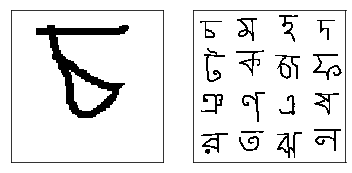

In [35]:
# Example of concat image visualization
pairs, targets = make_oneshot_task(16,"train","Bengali")
plot_oneshot_task(pairs)

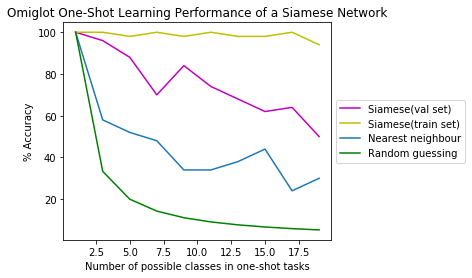

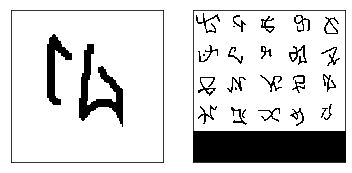

In [37]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = make_oneshot_task(20, "val", 'Atlantean')
plt.show()

plot_oneshot_task(inputs)